# Drone Flight Simulation with LoRa-Based Localization

This notebook simulates closed-loop drone navigation using LoRa RSSI-based localization.

**Key Features:**
- Uses high-resolution 400×400 RSSI grid (10m spacing) for realistic flight interpolation
- Realistic closed-loop control: drone uses ONLY estimated position for navigation
- Huber loss multilateration with altitude constraints
- Top-K strongest RSSI selection
- Sensitivity analysis for beacon position uncertainty

In [1]:
%pip install numpy scipy matplotlib pyproj tqdm h5py


[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import h5py
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load High-Resolution RSSI Data (400×400 Grid)

In [3]:
# Load the large MATLAB data (v7.3 format uses HDF5)
print("Loading high-resolution RSSI data...")
print("(This is 146MB, may take a few seconds)")

with h5py.File('data/drone_beacon_simulation_data_large.mat', 'r') as f:
    # Extract beacon data
    beacon_lat = np.array(f['beaconLatitudes']).flatten()
    beacon_lon = np.array(f['beaconLongitudes']).flatten()
    beacon_x = np.array(f['beaconXMeters']).flatten()
    beacon_y = np.array(f['beaconYMeters']).flatten()
    beacon_height = float(np.array(f['beaconHeight']).flatten()[0])

    # Extract drone data
    drone_lat = np.array(f['droneLatitudes']).flatten()
    drone_lon = np.array(f['droneLongitudes']).flatten()
    drone_x = np.array(f['droneXMeters']).flatten()
    drone_y = np.array(f['droneYMeters']).flatten()
    drone_altitude = float(np.array(f['droneAltitude']).flatten()[0])

    # Extract RSSI and true distances
    rssi_matrix = np.array(f['rssi_matrix']).T  # [num_drone_positions x num_beacons]
    true_distances = np.array(f['true_distances']).T

    # Extract metadata
    metadata_group = f['metadata']
    map_origin_lat = float(np.array(metadata_group['mapOriginLat']).flatten()[0])
    map_origin_lon = float(np.array(metadata_group['mapOriginLon']).flatten()[0])
    map_size_meters = float(np.array(metadata_group['mapSizeMeters']).flatten()[0])
    deg_per_meter_lat = float(np.array(metadata_group['degPerMeterLat']).flatten()[0])
    deg_per_meter_lon = float(np.array(metadata_group['degPerMeterLon']).flatten()[0])
    drone_grid_size = int(np.array(metadata_group['droneGridSize']).flatten()[0])

num_beacons = len(beacon_lat)
num_drone_positions = len(drone_lat)
grid_spacing = map_size_meters / drone_grid_size

print(f"\n Data loaded successfully!")
print(f"  - Number of beacons: {num_beacons}")
print(f"  - Drone grid: {drone_grid_size} x {drone_grid_size} = {num_drone_positions} positions")
print(f"  - Grid spacing: {grid_spacing:.1f} m")
print(f"  - Drone altitude: {drone_altitude} m")
print(f"  - Map size: {map_size_meters:.0f} x {map_size_meters:.0f} m")
print(f"  - RSSI range: [{rssi_matrix.min():.2f}, {rssi_matrix.max():.2f}] dBm")

Loading high-resolution RSSI data...
(This is 146MB, may take a few seconds)

 Data loaded successfully!
  - Number of beacons: 64
  - Drone grid: 400 x 400 = 160000 positions
  - Grid spacing: 10.0 m
  - Drone altitude: 100.0 m
  - Map size: 4000 x 4000 m
  - RSSI range: [-152.29, -10.11] dBm


## 2. Create RSSI Interpolators for Continuous Flight

In [4]:
# Get unique coordinates and reshape for interpolation
unique_x = np.unique(drone_x)
unique_y = np.unique(drone_y)

print(f"Grid dimensions: {len(unique_x)} x {len(unique_y)}")
print(f"X range: [{unique_x.min():.1f}, {unique_x.max():.1f}] m")
print(f"Y range: [{unique_y.min():.1f}, {unique_y.max():.1f}] m")

# Reshape RSSI matrix to 3D: [x, y, beacon]
rssi_3d = rssi_matrix.reshape(drone_grid_size, drone_grid_size, num_beacons)

# Create interpolators for each beacon
print(f"\nCreating {num_beacons} RSSI interpolators...")
rssi_interpolators = []
for b in range(num_beacons):
    interp = RegularGridInterpolator(
        (unique_x, unique_y), 
        rssi_3d[:, :, b],
        method='linear',
        bounds_error=False,
        fill_value=None
    )
    rssi_interpolators.append(interp)

print(f" Created {num_beacons} interpolators for continuous RSSI lookup")

def get_rssi_at_position(x, y):
    """Get interpolated RSSI values at any (x, y) position"""
    rssi_values = np.array([interp((x, y)) for interp in rssi_interpolators])
    return rssi_values

Grid dimensions: 400 x 400
X range: [200.0, 3800.0] m
Y range: [200.0, 3800.0] m

Creating 64 RSSI interpolators...
 Created 64 interpolators for continuous RSSI lookup


## 3. Multilateration Functions (Huber Loss + Altitude Constraint)

In [5]:
def log_distance_model(d, A, n):
    return A - 10 * n * np.log10(np.maximum(d, 1e-6))

def rssi_to_distance(rssi, A, n):
    return 10 ** ((A - rssi) / (10 * n))

def huber_loss(residual, delta=10.0):
    abs_r = np.abs(residual)
    return np.where(abs_r <= delta, 0.5 * residual**2, delta * (abs_r - 0.5 * delta))

def objective_function(pos, beacon_locs_meters, estimated_distances, delta=10.0):
    x, y = pos
    total_loss = 0
    for i, (bx, by, bz) in enumerate(beacon_locs_meters):
        calc_dist = np.sqrt((x - bx)**2 + (y - by)**2 + (drone_altitude - bz)**2)
        residual = calc_dist - estimated_distances[i]
        total_loss += huber_loss(residual, delta)
    return total_loss

def multilaterate_top_k(rssi_values, bx, by, A, n, k=10, delta=10.0):
    top_k_indices = np.argsort(rssi_values)[-k:]
    top_k_rssi = rssi_values[top_k_indices]
    top_k_beacon_locs = [(bx[i], by[i], beacon_height) for i in top_k_indices]
    est_distances = rssi_to_distance(top_k_rssi, A, n)
    
    init_x = np.mean([loc[0] for loc in top_k_beacon_locs])
    init_y = np.mean([loc[1] for loc in top_k_beacon_locs])
    
    result = minimize(
        objective_function, x0=[init_x, init_y],
        args=(top_k_beacon_locs, est_distances, delta),
        method='L-BFGS-B',
        bounds=[(0, map_size_meters), (0, map_size_meters)]
    )
    return result.x[0], result.x[1]

print("Multilateration functions defined!")

Multilateration functions defined!


## 4. Fit Path Loss Model

In [6]:
LOS_THRESHOLD = -100
rssi_flat = rssi_matrix.flatten()
dist_flat = true_distances.flatten()
los_mask = rssi_flat > LOS_THRESHOLD
rssi_los = rssi_flat[los_mask]
dist_los = dist_flat[los_mask]

print(f"Total signals: {len(rssi_flat)}")
print(f"LOS signals (>{LOS_THRESHOLD} dBm): {len(rssi_los)} ({100*len(rssi_los)/len(rssi_flat):.1f}%)")

popt, _ = curve_fit(log_distance_model, dist_los, rssi_los, p0=[-30, 2.0], maxfev=10000)
A_fit, n_fit = popt
print(f"\nFitted model: RSSI = {A_fit:.2f} - 10 x {n_fit:.2f} x log10(d)")

Total signals: 10240000
LOS signals (>-100 dBm): 7588503 (74.1%)

Fitted model: RSSI = -19.67 - 10 x 2.01 x log10(d)


## 5. DroneSimulator Class

In [7]:
class DroneSimulator:
    def __init__(self, start_pos, drone_speed=15.0, control_gain=0.3, 
                 waypoint_threshold=200, max_sim_steps=2000):
        self.true_x, self.true_y = start_pos
        self.drone_speed = drone_speed
        self.control_gain = control_gain
        self.waypoint_threshold = waypoint_threshold
        self.max_sim_steps = max_sim_steps
        self.dt = 1.0
        self.true_path = [(self.true_x, self.true_y)]
        self.estimated_path = []
        self.localization_errors = []
        
    def get_position_estimate(self, k=10, beacon_noise_std=0):
        rssi_values = get_rssi_at_position(self.true_x, self.true_y)
        if beacon_noise_std > 0:
            nbx = beacon_x + np.random.normal(0, beacon_noise_std, num_beacons)
            nby = beacon_y + np.random.normal(0, beacon_noise_std, num_beacons)
        else:
            nbx, nby = beacon_x, beacon_y
        return multilaterate_top_k(rssi_values, nbx, nby, A_fit, n_fit, k=k)
    
    def fly_to_waypoint(self, target_x, target_y, k=10, beacon_noise_std=0):
        steps = 0
        reached = False
        estimated_distance = float('inf')
        
        while steps < self.max_sim_steps:
            steps += 1
            est_x, est_y = self.get_position_estimate(k, beacon_noise_std)
            self.estimated_path.append((est_x, est_y))
            
            true_error = np.sqrt((est_x - self.true_x)**2 + (est_y - self.true_y)**2)
            self.localization_errors.append(true_error)
            
            estimated_distance = np.sqrt((target_x - est_x)**2 + (target_y - est_y)**2)
            if estimated_distance < self.waypoint_threshold:
                reached = True
                break
            
            dx, dy = target_x - est_x, target_y - est_y
            dist = np.sqrt(dx**2 + dy**2)
            vx = (dx / dist) * self.drone_speed * self.control_gain
            vy = (dy / dist) * self.drone_speed * self.control_gain
            
            self.true_x = np.clip(self.true_x + vx * self.dt, 0, map_size_meters)
            self.true_y = np.clip(self.true_y + vy * self.dt, 0, map_size_meters)
            self.true_path.append((self.true_x, self.true_y))
        
        final_true_error = np.sqrt((target_x - self.true_x)**2 + (target_y - self.true_y)**2)
        return {'reached': reached, 'steps': steps, 'final_true_error': final_true_error}
    
    def fly_mission(self, waypoints, k=10, beacon_noise_std=0, verbose=True):
        results = []
        for i, (wx, wy) in enumerate(waypoints):
            result = self.fly_to_waypoint(wx, wy, k, beacon_noise_std)
            result['waypoint_idx'] = i
            results.append(result)
            if verbose and not result['reached']:
                print(f"  Warning: WP{i} - max steps reached")
        return results

print("DroneSimulator defined - uses ESTIMATED position for all decisions!")

DroneSimulator defined - uses ESTIMATED position for all decisions!


## 6. Run Test Flight

In [8]:
MISSION = [(500,500), (1500,500), (1500,1500), (2500,1500), (2500,2500), (3500,2500), (3500,3500)]

print("Running test flight...")
sim = DroneSimulator(start_pos=MISSION[0], waypoint_threshold=150, max_sim_steps=1000)
results = sim.fly_mission(MISSION[1:], k=10, beacon_noise_std=0)

print(f"\nResults:")
print(f"  Waypoints reached: {sum(r['reached'] for r in results)}/{len(results)}")
print(f"  Median localization error: {np.median(sim.localization_errors):.1f}m")

Running test flight...

Results:
  Waypoints reached: 6/6
  Median localization error: 113.5m


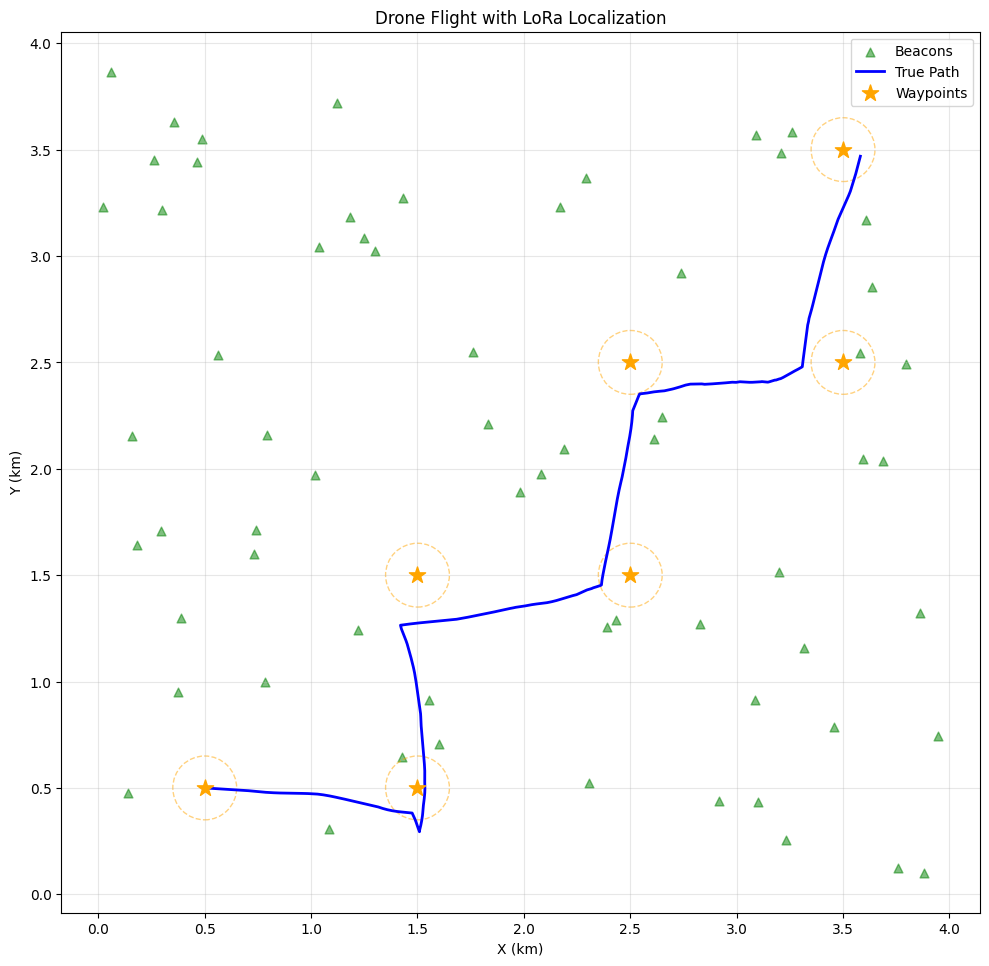

In [9]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
true_path = np.array(sim.true_path)
waypoints = np.array(MISSION)

ax.scatter(beacon_x/1000, beacon_y/1000, c='green', s=40, marker='^', alpha=0.5, label='Beacons')
ax.plot(true_path[:,0]/1000, true_path[:,1]/1000, 'b-', lw=2, label='True Path')
ax.scatter(waypoints[:,0]/1000, waypoints[:,1]/1000, c='orange', s=150, marker='*', zorder=5, label='Waypoints')

for wx, wy in MISSION:
    circle = plt.Circle((wx/1000, wy/1000), sim.waypoint_threshold/1000, fill=False, color='orange', ls='--', alpha=0.5)
    ax.add_patch(circle)

ax.set_xlabel('X (km)'); ax.set_ylabel('Y (km)')
ax.set_title('Drone Flight with LoRa Localization')
ax.legend(); ax.set_aspect('equal'); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('flight_test.png', dpi=150)
plt.show()

## 7. Sensitivity Analysis: Beacon Position Uncertainty

In [10]:
NOISE_LEVELS = [0, 25, 50, 100, 150, 200, 300]
NUM_TRIALS = 3

print("Running sensitivity analysis...")
results_all = []

for noise_std in tqdm(NOISE_LEVELS):
    trial_data = []
    for _ in range(NUM_TRIALS):
        sim = DroneSimulator(start_pos=MISSION[0], waypoint_threshold=200, max_sim_steps=1500)
        res = sim.fly_mission(MISSION[1:], k=10, beacon_noise_std=noise_std, verbose=False)
        trial_data.append({
            'wp_reached': sum(r['reached'] for r in res),
            'median_err': np.median(sim.localization_errors),
            'final_errs': [r['final_true_error'] for r in res]
        })
    results_all.append({
        'noise': noise_std,
        'wp_reached': np.mean([t['wp_reached'] for t in trial_data]),
        'median_err': np.mean([t['median_err'] for t in trial_data]),
        'final_err': np.mean([np.mean(t['final_errs']) for t in trial_data])
    })

print("\n" + "="*60)
print(f"{'Beacon sigma':<15} {'WP Reached':<15} {'Loc Error':<15} {'Final Err':<15}")
print("="*60)
for r in results_all:
    print(f"{r['noise']:>10}m {r['wp_reached']:>12.1f}/6 {r['median_err']:>12.1f}m {r['final_err']:>12.1f}m")

Running sensitivity analysis...


100%|██████████| 7/7 [01:50<00:00, 15.81s/it]


Beacon sigma    WP Reached      Loc Error       Final Err      
         0m          6.0/6        112.5m        179.5m
        25m          6.0/6        105.4m        192.2m
        50m          6.0/6         98.7m        202.8m
       100m          6.0/6        101.3m        244.7m
       150m          6.0/6        114.9m        284.1m
       200m          6.0/6        142.3m        342.0m
       300m          6.0/6        190.8m        415.1m


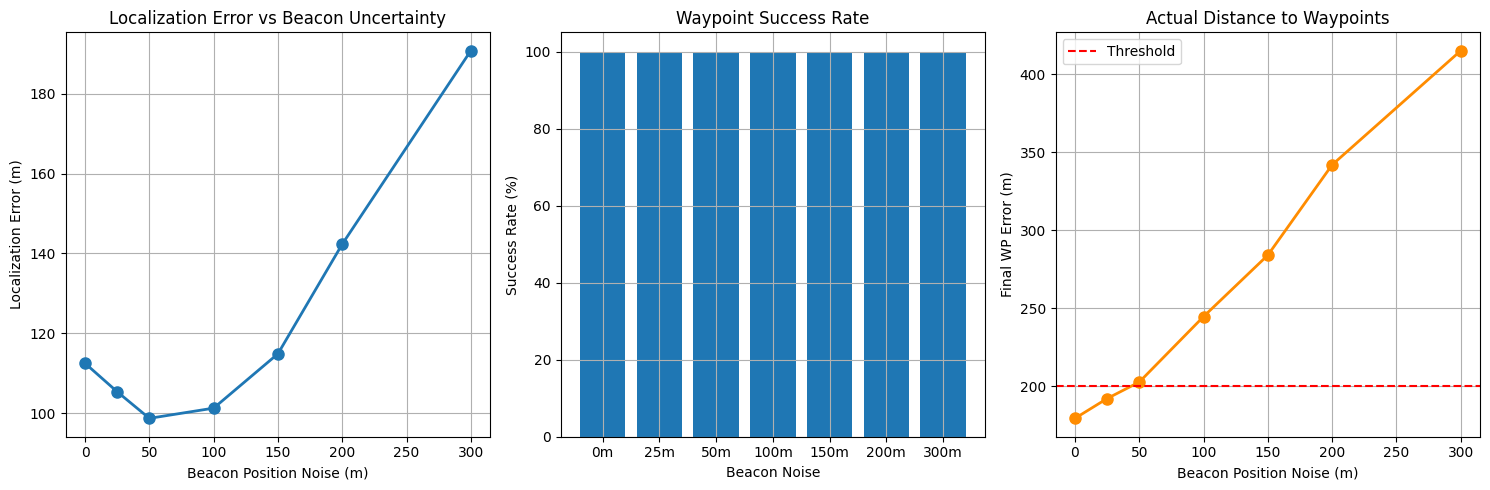

In [11]:
# Plot sensitivity
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

noise_vals = [r['noise'] for r in results_all]

axes[0].plot(noise_vals, [r['median_err'] for r in results_all], 'o-', lw=2, ms=8)
axes[0].set_xlabel('Beacon Position Noise (m)'); axes[0].set_ylabel('Localization Error (m)')
axes[0].set_title('Localization Error vs Beacon Uncertainty'); axes[0].grid(True)

axes[1].bar(range(len(noise_vals)), [100*r['wp_reached']/6 for r in results_all])
axes[1].set_xticks(range(len(noise_vals))); axes[1].set_xticklabels([f'{n}m' for n in noise_vals])
axes[1].set_xlabel('Beacon Noise'); axes[1].set_ylabel('Success Rate (%)')
axes[1].set_title('Waypoint Success Rate'); axes[1].grid(True)

axes[2].plot(noise_vals, [r['final_err'] for r in results_all], 'o-', lw=2, ms=8, c='darkorange')
axes[2].axhline(200, c='r', ls='--', label='Threshold')
axes[2].set_xlabel('Beacon Position Noise (m)'); axes[2].set_ylabel('Final WP Error (m)')
axes[2].set_title('Actual Distance to Waypoints'); axes[2].legend(); axes[2].grid(True)

plt.tight_layout()
plt.savefig('sensitivity_analysis.png', dpi=150)
plt.show()

## 8. Detailed Flight Path Analysis

In [39]:
# Detailed flight path analysis
print("Running detailed flight analysis...")

# Run a fresh simulation for detailed analysis
DETAILED_MISSION = [
    (500, 500),
    (1500, 500),
    (1500, 1500),
    (2500, 1500),
    (2500, 2500),
    (3500, 2500),
    (3500, 3500),
]

sim_detailed = DroneSimulator(
    start_pos=DETAILED_MISSION[0],
    drone_speed=15.0,
    control_gain=0.3,
    waypoint_threshold=150,
    max_sim_steps=1000
)

results_detailed = sim_detailed.fly_mission(DETAILED_MISSION[1:], k=10, beacon_noise_std=150)

# Convert to arrays
true_path = np.array(sim_detailed.true_path)
est_path = np.array(sim_detailed.estimated_path)
loc_errors = np.array(sim_detailed.localization_errors)

print(f"Flight completed: {len(true_path)} positions recorded")
print(f"Localization errors - Mean: {loc_errors.mean():.1f}m, Median: {np.median(loc_errors):.1f}m")

Running detailed flight analysis...
Flight completed: 1172 positions recorded
Localization errors - Mean: 130.1m, Median: 122.2m


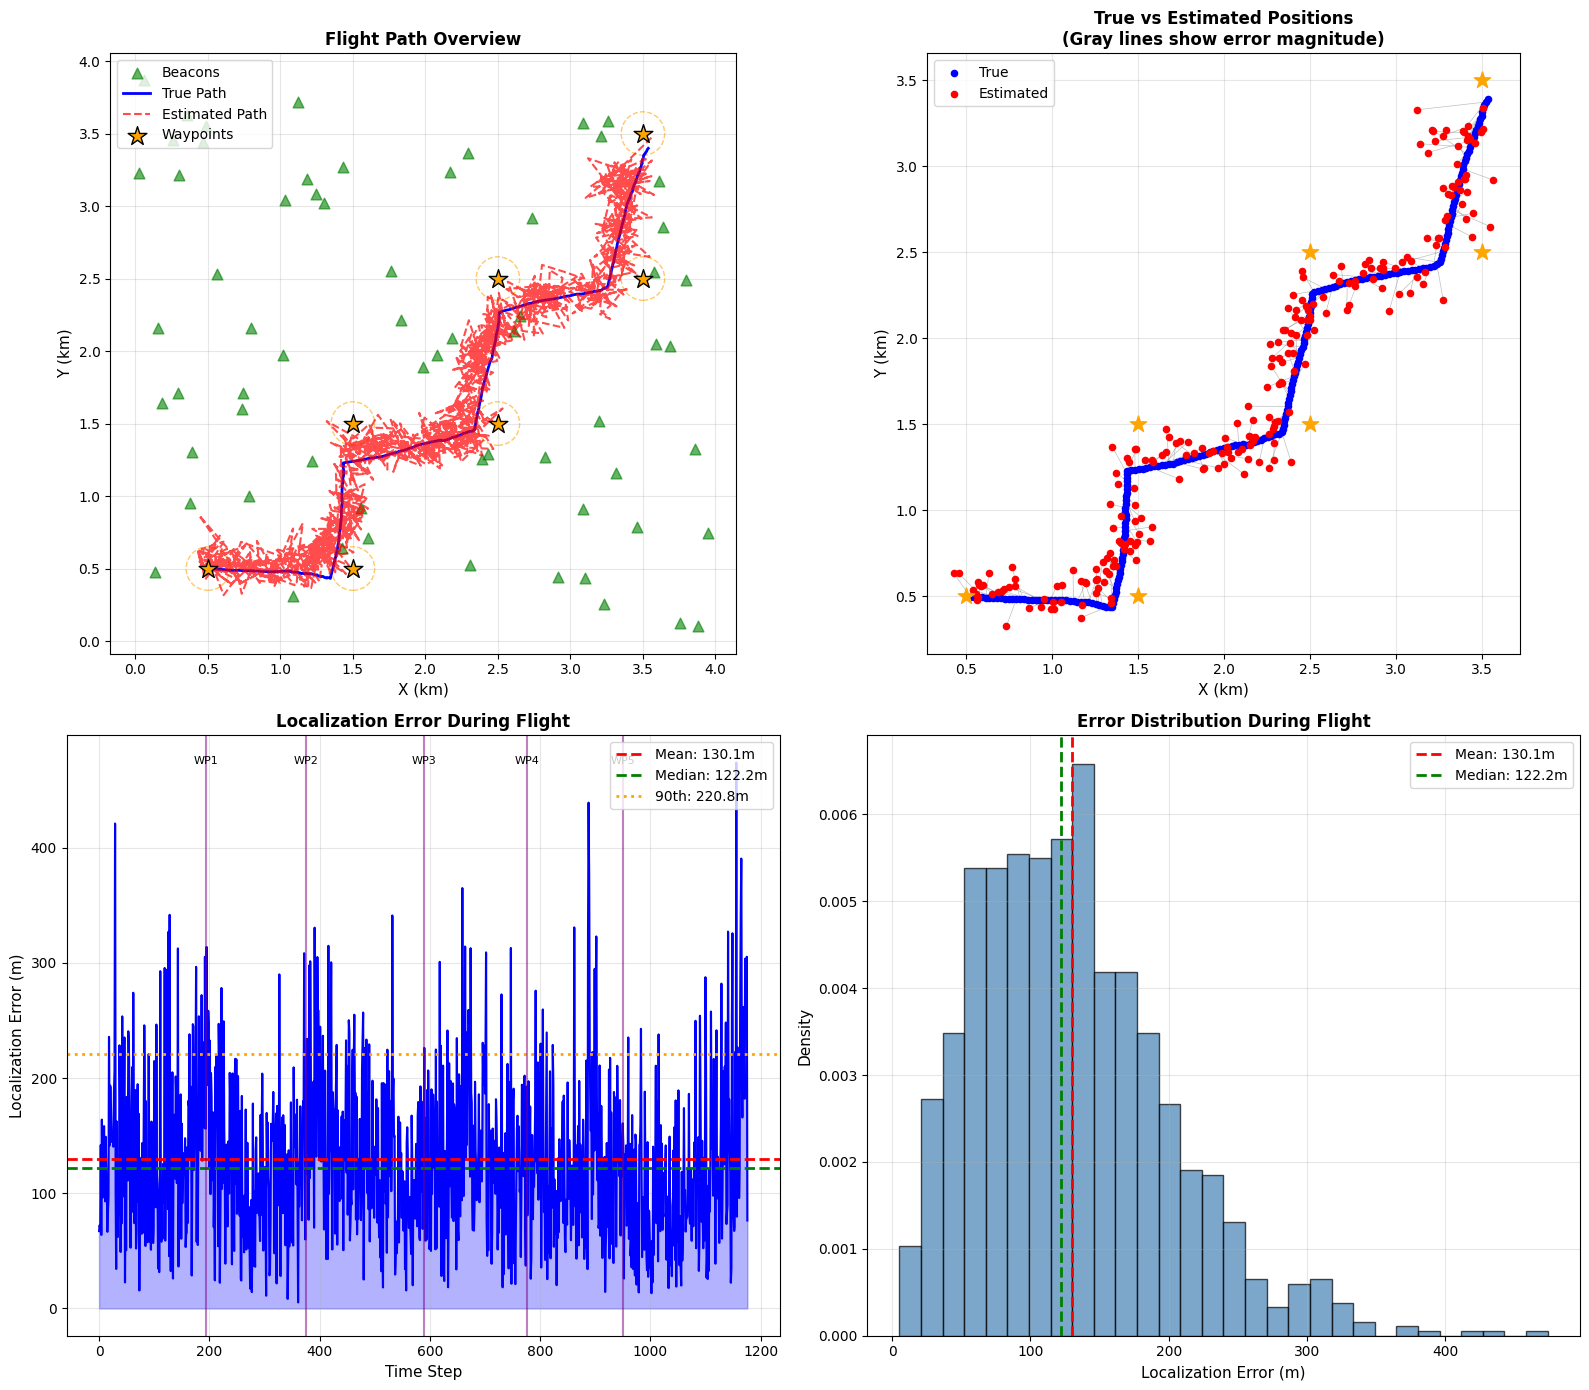

In [40]:
# Comprehensive 4-panel flight visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

waypoints = np.array(DETAILED_MISSION)

# Panel 1: Overview with beacons
ax1 = axes[0, 0]
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=60, marker='^', alpha=0.6, label='Beacons', zorder=2)
ax1.plot(true_path[:, 0]/1000, true_path[:, 1]/1000, 'b-', lw=2, label='True Path', zorder=3)
ax1.plot(est_path[:, 0]/1000, est_path[:, 1]/1000, 'r--', lw=1.5, alpha=0.7, label='Estimated Path', zorder=3)

# Waypoints with threshold circles
for i, (wx, wy) in enumerate(DETAILED_MISSION):
    circle = plt.Circle((wx/1000, wy/1000), sim_detailed.waypoint_threshold/1000, 
                         fill=False, color='orange', ls='--', alpha=0.6)
    ax1.add_patch(circle)
ax1.scatter(waypoints[:, 0]/1000, waypoints[:, 1]/1000, c='orange', s=200, marker='*', 
            edgecolors='black', linewidths=1, zorder=5, label='Waypoints')

ax1.set_xlabel('X (km)', fontsize=11)
ax1.set_ylabel('Y (km)', fontsize=11)
ax1.set_title('Flight Path Overview', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Panel 2: True vs Estimated position comparison (zoomed)
ax2 = axes[0, 1]
# Plot every 5th point with error lines
step = 5
for i in range(0, len(true_path)-1, step):
    if i < len(est_path):
        ax2.plot([true_path[i, 0]/1000, est_path[i, 0]/1000], 
                 [true_path[i, 1]/1000, est_path[i, 1]/1000], 
                 'gray', lw=0.5, alpha=0.5)

ax2.scatter(true_path[::step, 0]/1000, true_path[::step, 1]/1000, c='blue', s=20, label='True', zorder=3)
ax2.scatter(est_path[::step, 0]/1000, est_path[::step, 1]/1000, c='red', s=20, label='Estimated', zorder=3)
ax2.scatter(waypoints[:, 0]/1000, waypoints[:, 1]/1000, c='orange', s=150, marker='*', zorder=5)

ax2.set_xlabel('X (km)', fontsize=11)
ax2.set_ylabel('Y (km)', fontsize=11)
ax2.set_title('True vs Estimated Positions\n(Gray lines show error magnitude)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# Panel 3: Localization error over time
ax3 = axes[1, 0]
ax3.fill_between(range(len(loc_errors)), 0, loc_errors, alpha=0.3, color='blue')
ax3.plot(loc_errors, 'b-', lw=1.5)
ax3.axhline(loc_errors.mean(), color='red', ls='--', lw=2, label=f'Mean: {loc_errors.mean():.1f}m')
ax3.axhline(np.median(loc_errors), color='green', ls='--', lw=2, label=f'Median: {np.median(loc_errors):.1f}m')
ax3.axhline(np.percentile(loc_errors, 90), color='orange', ls=':', lw=2, label=f'90th: {np.percentile(loc_errors, 90):.1f}m')

# Mark waypoint arrivals
cumulative_steps = 0
for i, r in enumerate(results_detailed):
    cumulative_steps += r['steps']
    if cumulative_steps < len(loc_errors):
        ax3.axvline(cumulative_steps, color='purple', ls='-', alpha=0.5)
        ax3.text(cumulative_steps, ax3.get_ylim()[1]*0.95, f'WP{i+1}', fontsize=8, ha='center')

ax3.set_xlabel('Time Step', fontsize=11)
ax3.set_ylabel('Localization Error (m)', fontsize=11)
ax3.set_title('Localization Error During Flight', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Panel 4: Error histogram
ax4 = axes[1, 1]
ax4.hist(loc_errors, bins=30, edgecolor='black', alpha=0.7, color='steelblue', density=True)
ax4.axvline(loc_errors.mean(), color='red', ls='--', lw=2, label=f'Mean: {loc_errors.mean():.1f}m')
ax4.axvline(np.median(loc_errors), color='green', ls='--', lw=2, label=f'Median: {np.median(loc_errors):.1f}m')
ax4.set_xlabel('Localization Error (m)', fontsize=11)
ax4.set_ylabel('Density', fontsize=11)
ax4.set_title('Error Distribution During Flight', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('detailed_flight_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Per-Waypoint Analysis

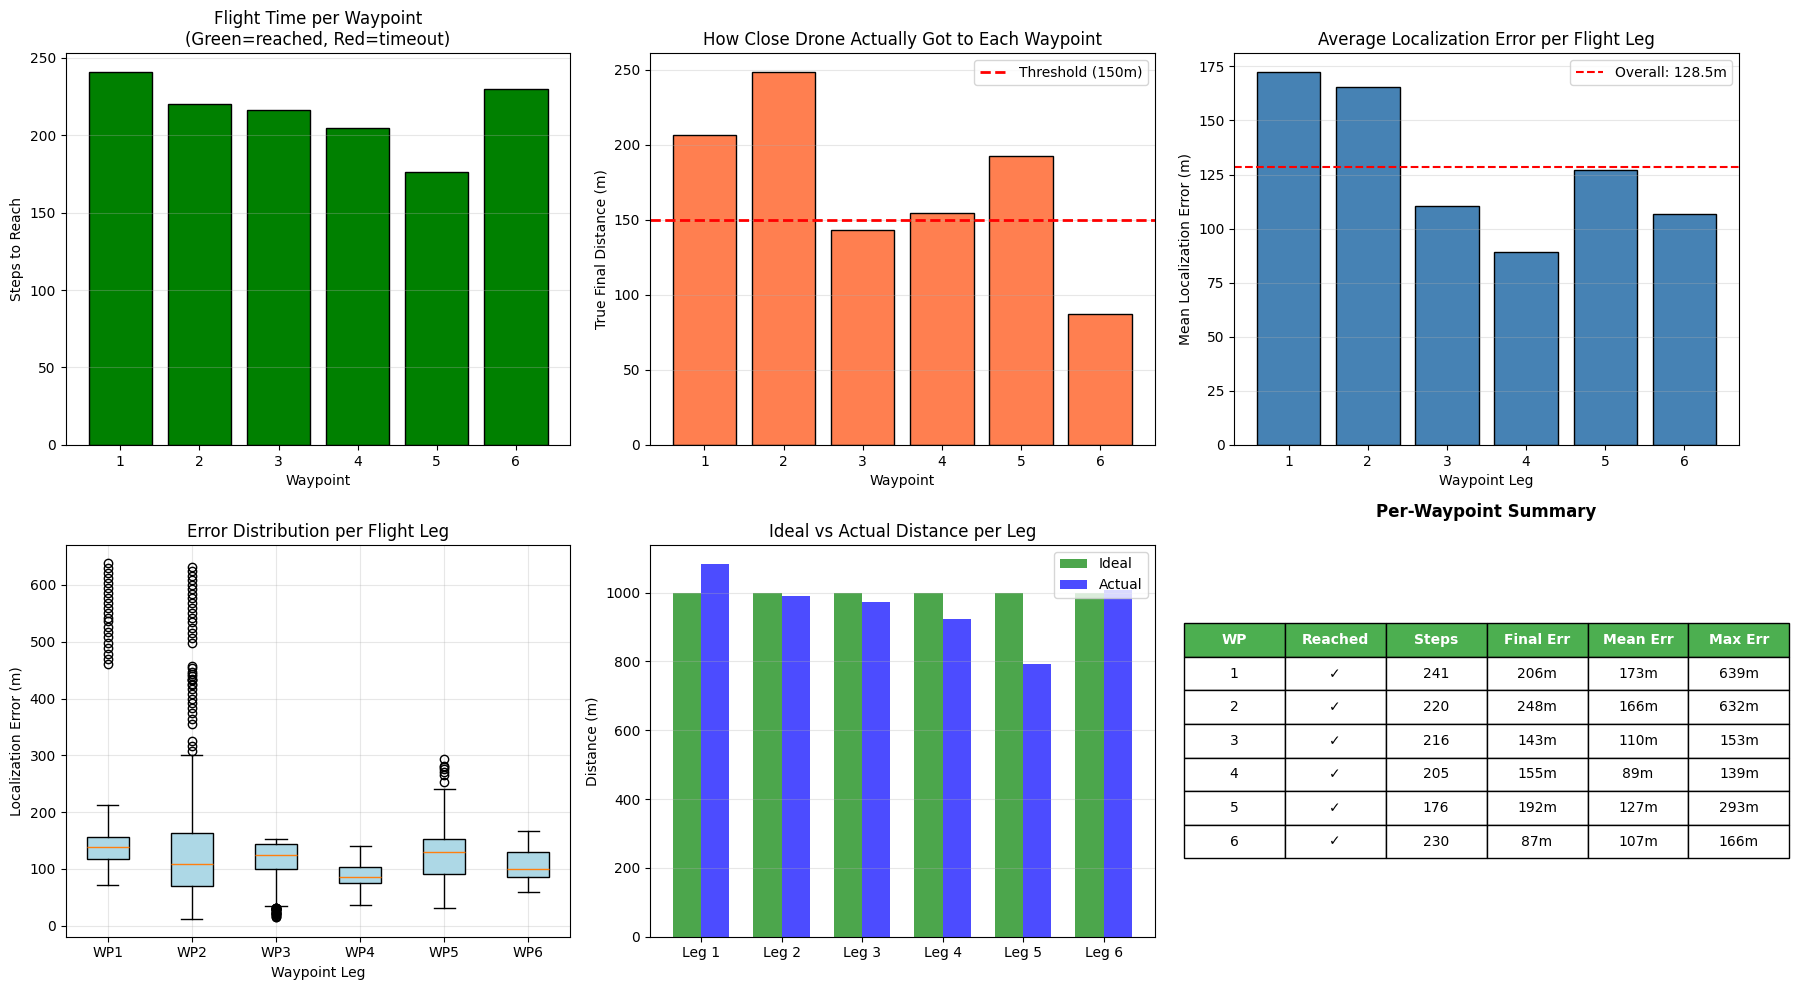

In [14]:
# Per-waypoint analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Calculate per-waypoint statistics
wp_stats = []
error_start = 0

for i, r in enumerate(results_detailed):
    error_end = error_start + r['steps']
    wp_errors = loc_errors[error_start:min(error_end, len(loc_errors))]
    wp_stats.append({
        'waypoint': i+1,
        'steps': r['steps'],
        'reached': r['reached'],
        'final_error': r['final_true_error'],
        'mean_error': np.mean(wp_errors) if len(wp_errors) > 0 else 0,
        'median_error': np.median(wp_errors) if len(wp_errors) > 0 else 0,
        'max_error': np.max(wp_errors) if len(wp_errors) > 0 else 0,
        'errors': wp_errors
    })
    error_start = error_end

# Panel 1: Steps per waypoint
ax1 = axes[0, 0]
wp_nums = [s['waypoint'] for s in wp_stats]
steps = [s['steps'] for s in wp_stats]
colors = ['green' if s['reached'] else 'red' for s in wp_stats]
ax1.bar(wp_nums, steps, color=colors, edgecolor='black')
ax1.set_xlabel('Waypoint')
ax1.set_ylabel('Steps to Reach')
ax1.set_title('Flight Time per Waypoint\n(Green=reached, Red=timeout)')
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: Final error at each waypoint
ax2 = axes[0, 1]
final_errors = [s['final_error'] for s in wp_stats]
ax2.bar(wp_nums, final_errors, color='coral', edgecolor='black')
ax2.axhline(sim_detailed.waypoint_threshold, color='red', ls='--', lw=2, label=f'Threshold ({sim_detailed.waypoint_threshold}m)')
ax2.set_xlabel('Waypoint')
ax2.set_ylabel('True Final Distance (m)')
ax2.set_title('How Close Drone Actually Got to Each Waypoint')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Mean error per leg
ax3 = axes[0, 2]
mean_errors = [s['mean_error'] for s in wp_stats]
ax3.bar(wp_nums, mean_errors, color='steelblue', edgecolor='black')
ax3.axhline(np.mean(mean_errors), color='red', ls='--', label=f'Overall: {np.mean(mean_errors):.1f}m')
ax3.set_xlabel('Waypoint Leg')
ax3.set_ylabel('Mean Localization Error (m)')
ax3.set_title('Average Localization Error per Flight Leg')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Panel 4: Box plot of errors per waypoint
ax4 = axes[1, 0]
boxdata = [s['errors'] for s in wp_stats if len(s['errors']) > 0]
bp = ax4.boxplot(boxdata, labels=[f'WP{s["waypoint"]}' for s in wp_stats if len(s['errors']) > 0], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax4.set_xlabel('Waypoint Leg')
ax4.set_ylabel('Localization Error (m)')
ax4.set_title('Error Distribution per Flight Leg')
ax4.grid(True, alpha=0.3)

# Panel 5: Cumulative distance traveled
ax5 = axes[1, 1]
# Calculate actual path length per segment
segment_lengths = []
ideal_lengths = []
start_idx = 0
for i, r in enumerate(results_detailed):
    end_idx = start_idx + r['steps'] + 1
    segment = true_path[start_idx:min(end_idx, len(true_path))]
    if len(segment) > 1:
        actual_len = sum(np.sqrt(np.sum(np.diff(segment, axis=0)**2, axis=1)))
    else:
        actual_len = 0
    segment_lengths.append(actual_len)
    
    # Ideal length
    if i == 0:
        ideal = np.sqrt((DETAILED_MISSION[1][0]-DETAILED_MISSION[0][0])**2 + (DETAILED_MISSION[1][1]-DETAILED_MISSION[0][1])**2)
    else:
        ideal = np.sqrt((DETAILED_MISSION[i+1][0]-DETAILED_MISSION[i][0])**2 + (DETAILED_MISSION[i+1][1]-DETAILED_MISSION[i][1])**2)
    ideal_lengths.append(ideal)
    start_idx = end_idx - 1

x = np.arange(len(wp_stats))
width = 0.35
ax5.bar(x - width/2, ideal_lengths, width, label='Ideal', color='green', alpha=0.7)
ax5.bar(x + width/2, segment_lengths, width, label='Actual', color='blue', alpha=0.7)
ax5.set_xticks(x)
ax5.set_xticklabels([f'Leg {i+1}' for i in range(len(wp_stats))])
ax5.set_ylabel('Distance (m)')
ax5.set_title('Ideal vs Actual Distance per Leg')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Panel 6: Summary table
ax6 = axes[1, 2]
ax6.axis('off')
table_data = [['WP', 'Reached', 'Steps', 'Final Err', 'Mean Err', 'Max Err']]
for s in wp_stats:
    table_data.append([
        str(s['waypoint']),
        '✓' if s['reached'] else '✗',
        str(s['steps']),
        f"{s['final_error']:.0f}m",
        f"{s['mean_error']:.0f}m",
        f"{s['max_error']:.0f}m"
    ])

table = ax6.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)
for j in range(6):
    table[(0, j)].set_facecolor('#4CAF50')
    table[(0, j)].set_text_props(color='white', fontweight='bold')
ax6.set_title('Per-Waypoint Summary', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('per_waypoint_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Detailed Sensitivity Analysis with Multiple Metrics

In [15]:
# Extended sensitivity analysis with more metrics
NOISE_LEVELS_DETAILED = [0, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300]
NUM_TRIALS = 5  # More trials for better statistics

print("Running extended sensitivity analysis...")
print(f"Noise levels: {NOISE_LEVELS_DETAILED}")
print(f"Trials per level: {NUM_TRIALS}")

extended_results = []

for noise_std in tqdm(NOISE_LEVELS_DETAILED, desc="Sensitivity Analysis"):
    trial_data = []
    
    for trial in range(NUM_TRIALS):
        sim = DroneSimulator(
            start_pos=DETAILED_MISSION[0],
            drone_speed=15.0,
            control_gain=0.3,
            waypoint_threshold=200,
            max_sim_steps=1500
        )
        
        results = sim.fly_mission(DETAILED_MISSION[1:], k=10, beacon_noise_std=noise_std, verbose=False)
        
        # Calculate path length
        path = np.array(sim.true_path)
        if len(path) > 1:
            path_length = np.sum(np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1)))
        else:
            path_length = 0
        
        trial_data.append({
            'wp_reached': sum(1 for r in results if r['reached']),
            'mean_error': np.mean(sim.localization_errors),
            'median_error': np.median(sim.localization_errors),
            'p90_error': np.percentile(sim.localization_errors, 90),
            'max_error': np.max(sim.localization_errors),
            'std_error': np.std(sim.localization_errors),
            'path_length': path_length,
            'total_steps': sum(r['steps'] for r in results),
            'final_errors': [r['final_true_error'] for r in results]
        })
    
    # Aggregate
    extended_results.append({
        'noise': noise_std,
        'wp_reached_mean': np.mean([t['wp_reached'] for t in trial_data]),
        'wp_reached_std': np.std([t['wp_reached'] for t in trial_data]),
        'mean_error': np.mean([t['mean_error'] for t in trial_data]),
        'mean_error_std': np.std([t['mean_error'] for t in trial_data]),
        'median_error': np.mean([t['median_error'] for t in trial_data]),
        'p90_error': np.mean([t['p90_error'] for t in trial_data]),
        'max_error': np.mean([t['max_error'] for t in trial_data]),
        'path_length': np.mean([t['path_length'] for t in trial_data]),
        'path_length_std': np.std([t['path_length'] for t in trial_data]),
        'final_wp_error': np.mean([np.mean(t['final_errors']) for t in trial_data]),
        'trials': trial_data
    })

print("\nExtended sensitivity analysis complete!")

Running extended sensitivity analysis...
Noise levels: [0, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300]
Trials per level: 5


Sensitivity Analysis: 100%|██████████| 12/12 [05:12<00:00, 26.06s/it]


Extended sensitivity analysis complete!


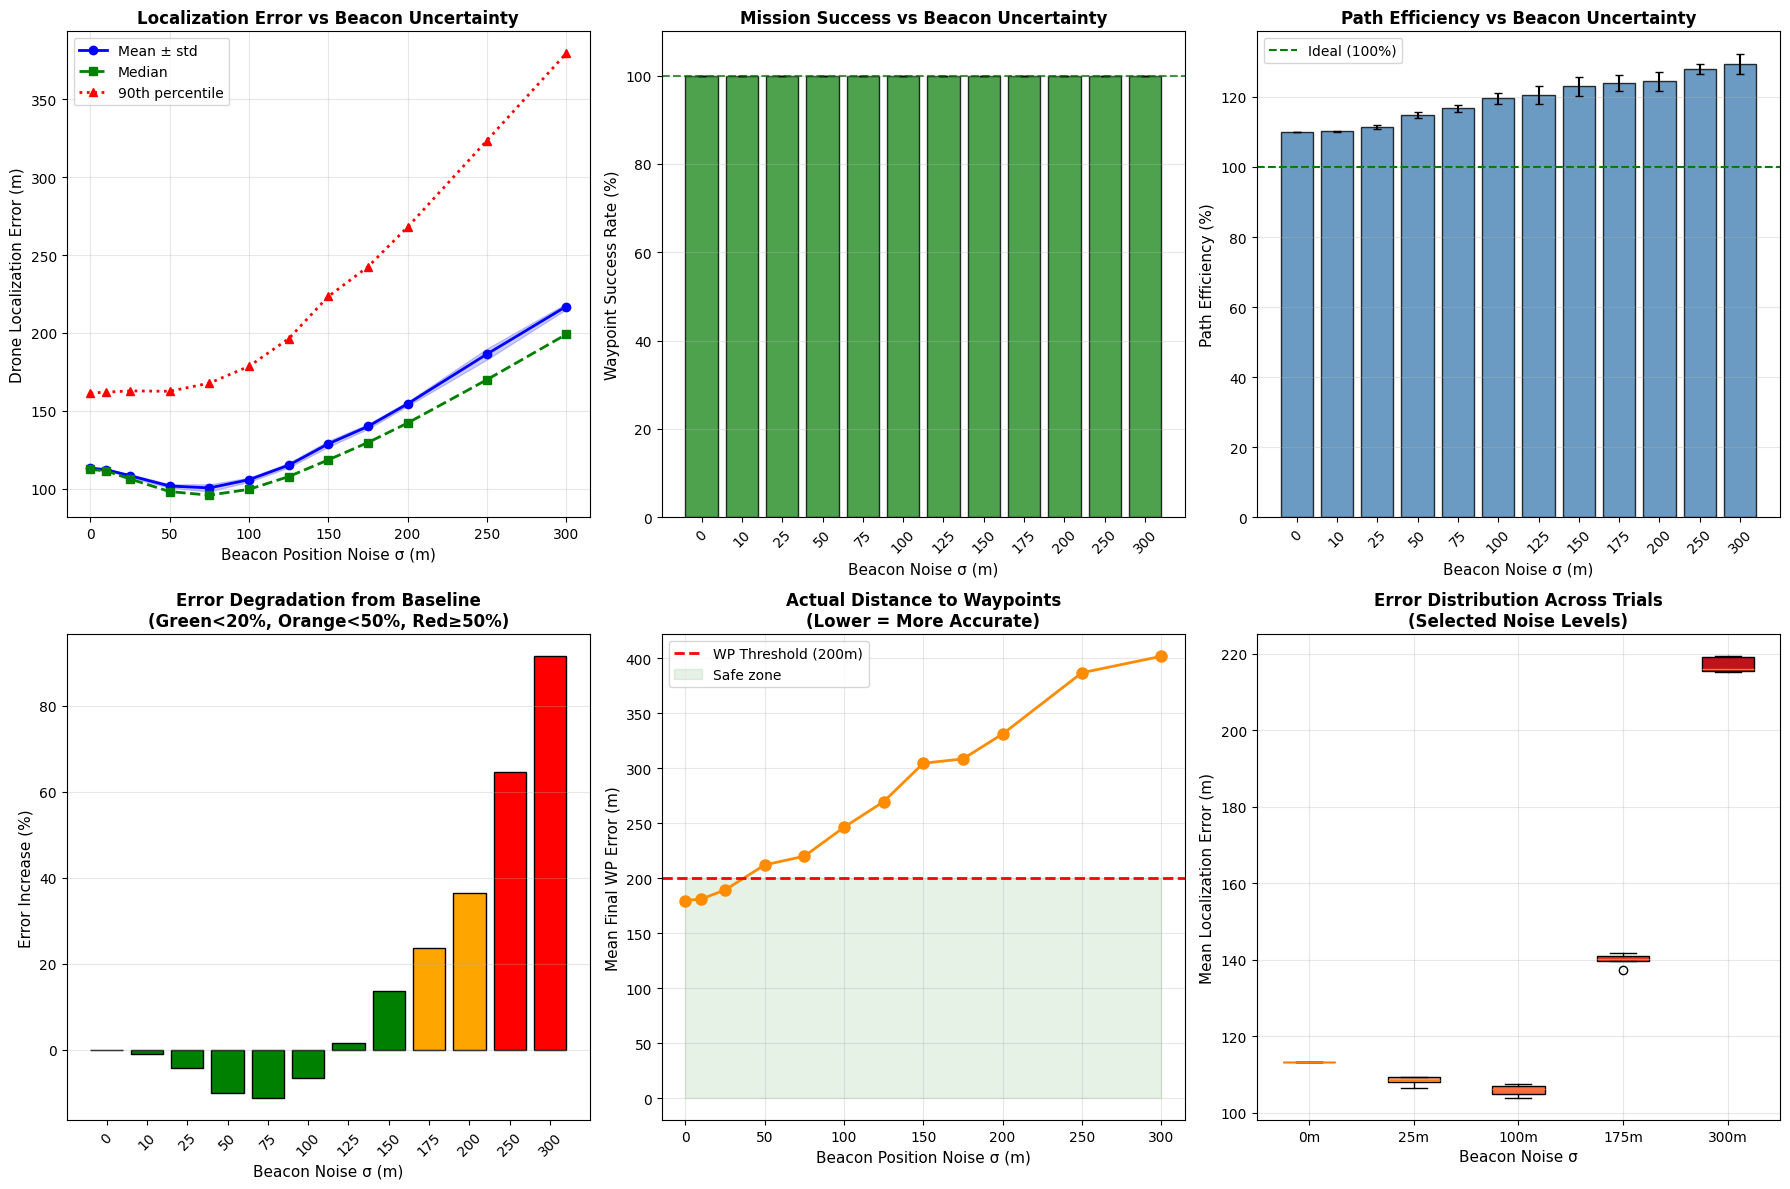

In [16]:
# Comprehensive 6-panel sensitivity visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

noise_vals = [r['noise'] for r in extended_results]

# Panel 1: Localization Error with confidence bands
ax1 = axes[0, 0]
means = [r['mean_error'] for r in extended_results]
stds = [r['mean_error_std'] for r in extended_results]
medians = [r['median_error'] for r in extended_results]
p90s = [r['p90_error'] for r in extended_results]

ax1.fill_between(noise_vals, np.array(means)-np.array(stds), np.array(means)+np.array(stds), alpha=0.2, color='blue')
ax1.plot(noise_vals, means, 'o-', lw=2, ms=6, label='Mean ± std', color='blue')
ax1.plot(noise_vals, medians, 's--', lw=2, ms=6, label='Median', color='green')
ax1.plot(noise_vals, p90s, '^:', lw=2, ms=6, label='90th percentile', color='red')
ax1.set_xlabel('Beacon Position Noise σ (m)', fontsize=11)
ax1.set_ylabel('Drone Localization Error (m)', fontsize=11)
ax1.set_title('Localization Error vs Beacon Uncertainty', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Waypoint Success Rate with error bars
ax2 = axes[0, 1]
wp_means = [100 * r['wp_reached_mean'] / 6 for r in extended_results]
wp_stds = [100 * r['wp_reached_std'] / 6 for r in extended_results]
ax2.bar(range(len(noise_vals)), wp_means, yerr=wp_stds, capsize=3, color='forestgreen', edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(noise_vals)))
ax2.set_xticklabels([f'{n}' for n in noise_vals], rotation=45)
ax2.set_xlabel('Beacon Noise σ (m)', fontsize=11)
ax2.set_ylabel('Waypoint Success Rate (%)', fontsize=11)
ax2.set_title('Mission Success vs Beacon Uncertainty', fontsize=12, fontweight='bold')
ax2.axhline(100, color='darkgreen', ls='--', alpha=0.7)
ax2.set_ylim([0, 110])
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Path Efficiency
ax3 = axes[0, 2]
ideal_length = sum(
    np.sqrt((DETAILED_MISSION[i+1][0]-DETAILED_MISSION[i][0])**2 + 
           (DETAILED_MISSION[i+1][1]-DETAILED_MISSION[i][1])**2)
    for i in range(len(DETAILED_MISSION)-1)
)
efficiencies = [100 * ideal_length / r['path_length'] if r['path_length'] > 0 else 0 for r in extended_results]
eff_stds = [100 * ideal_length * r['path_length_std'] / r['path_length']**2 if r['path_length'] > 0 else 0 for r in extended_results]

ax3.bar(range(len(noise_vals)), efficiencies, yerr=eff_stds, capsize=3, color='steelblue', edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(noise_vals)))
ax3.set_xticklabels([f'{n}' for n in noise_vals], rotation=45)
ax3.set_xlabel('Beacon Noise σ (m)', fontsize=11)
ax3.set_ylabel('Path Efficiency (%)', fontsize=11)
ax3.set_title('Path Efficiency vs Beacon Uncertainty', fontsize=12, fontweight='bold')
ax3.axhline(100, color='green', ls='--', label='Ideal (100%)')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Panel 4: Error Degradation (relative to baseline)
ax4 = axes[1, 0]
baseline = extended_results[0]['mean_error']
degradation = [(r['mean_error'] - baseline) / baseline * 100 for r in extended_results]
colors = ['green' if d < 20 else 'orange' if d < 50 else 'red' for d in degradation]
ax4.bar(range(len(noise_vals)), degradation, color=colors, edgecolor='black')
ax4.set_xticks(range(len(noise_vals)))
ax4.set_xticklabels([f'{n}' for n in noise_vals], rotation=45)
ax4.set_xlabel('Beacon Noise σ (m)', fontsize=11)
ax4.set_ylabel('Error Increase (%)', fontsize=11)
ax4.set_title('Error Degradation from Baseline\n(Green<20%, Orange<50%, Red≥50%)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Panel 5: Final Waypoint Error
ax5 = axes[1, 1]
final_errs = [r['final_wp_error'] for r in extended_results]
ax5.plot(noise_vals, final_errs, 'o-', lw=2, ms=8, color='darkorange')
ax5.axhline(200, color='red', ls='--', lw=2, label='WP Threshold (200m)')
ax5.fill_between(noise_vals, 0, 200, alpha=0.1, color='green', label='Safe zone')
ax5.set_xlabel('Beacon Position Noise σ (m)', fontsize=11)
ax5.set_ylabel('Mean Final WP Error (m)', fontsize=11)
ax5.set_title('Actual Distance to Waypoints\n(Lower = More Accurate)', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Panel 6: Box plot comparison for key noise levels
ax6 = axes[1, 2]
key_indices = [0, 2, 5, 8, 11]  # 0, 25, 100, 175, 300
key_indices = [i for i in key_indices if i < len(extended_results)]
boxplot_data = []
boxplot_labels = []
for idx in key_indices:
    all_errors = []
    for t in extended_results[idx]['trials']:
        all_errors.append(t['mean_error'])
    boxplot_data.append(all_errors)
    boxplot_labels.append(f"{extended_results[idx]['noise']}m")

bp = ax6.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)
colors = plt.cm.Reds(np.linspace(0.2, 0.8, len(boxplot_data)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax6.set_xlabel('Beacon Noise σ', fontsize=11)
ax6.set_ylabel('Mean Localization Error (m)', fontsize=11)
ax6.set_title('Error Distribution Across Trials\n(Selected Noise Levels)', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('extended_sensitivity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Flight Path Comparison: Different Noise Levels

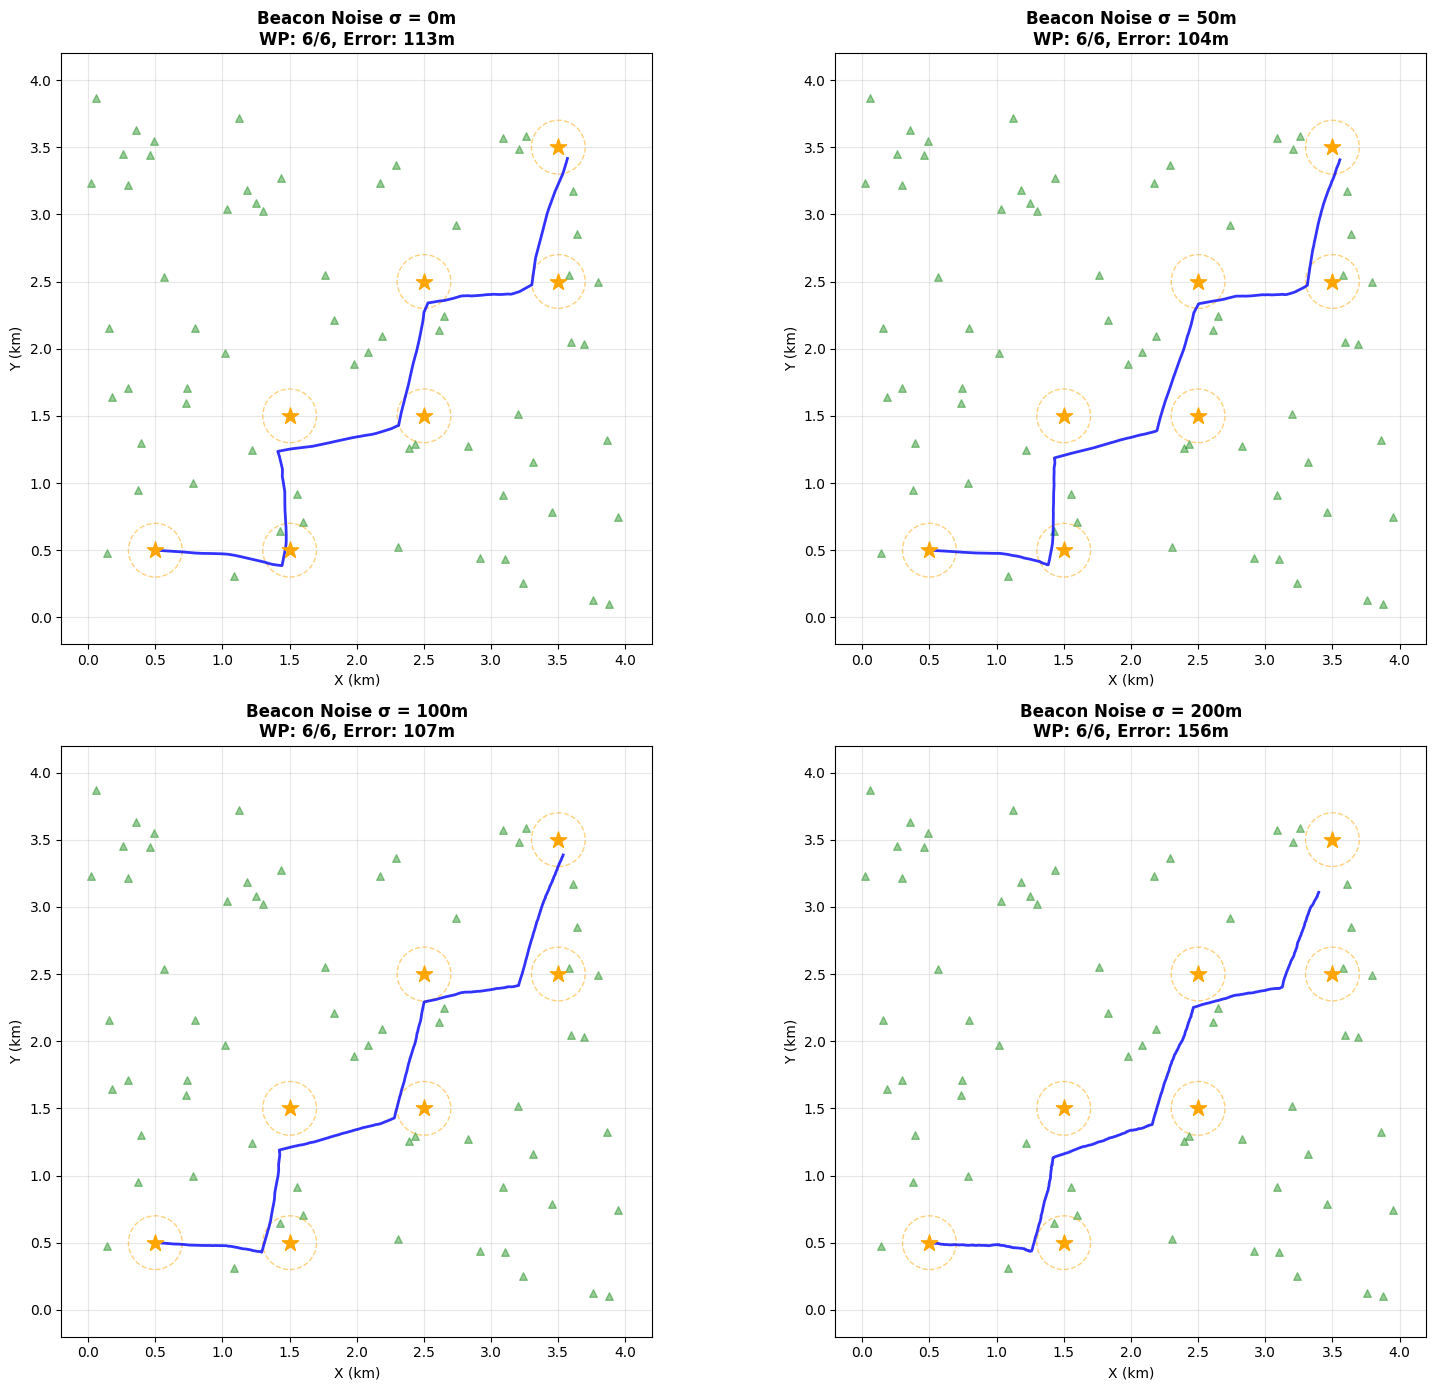

In [17]:
# Compare flight paths at different noise levels
COMPARE_NOISE = [0, 50, 100, 200]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, noise in enumerate(COMPARE_NOISE):
    ax = axes[idx]
    
    # Run simulation
    sim = DroneSimulator(
        start_pos=DETAILED_MISSION[0],
        drone_speed=15.0,
        control_gain=0.3,
        waypoint_threshold=200,
        max_sim_steps=1500
    )
    results = sim.fly_mission(DETAILED_MISSION[1:], k=10, beacon_noise_std=noise, verbose=False)
    
    path = np.array(sim.true_path)
    waypoints = np.array(DETAILED_MISSION)
    
    # Plot
    ax.scatter(beacon_x/1000, beacon_y/1000, c='green', s=30, marker='^', alpha=0.4)
    ax.plot(path[:, 0]/1000, path[:, 1]/1000, 'b-', lw=2, alpha=0.8)
    ax.scatter(waypoints[:, 0]/1000, waypoints[:, 1]/1000, c='orange', s=150, marker='*', zorder=5)
    
    # Threshold circles
    for wx, wy in DETAILED_MISSION:
        circle = plt.Circle((wx/1000, wy/1000), sim.waypoint_threshold/1000, 
                             fill=False, color='orange', ls='--', alpha=0.5)
        ax.add_patch(circle)
    
    # Stats
    wp_success = sum(1 for r in results if r['reached'])
    mean_err = np.mean(sim.localization_errors)
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_title(f'Beacon Noise σ = {noise}m\nWP: {wp_success}/6, Error: {mean_err:.0f}m', fontsize=12, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-0.2, 4.2])
    ax.set_ylim([-0.2, 4.2])

plt.tight_layout()
plt.savefig('flight_path_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Error Heatmap Analysis

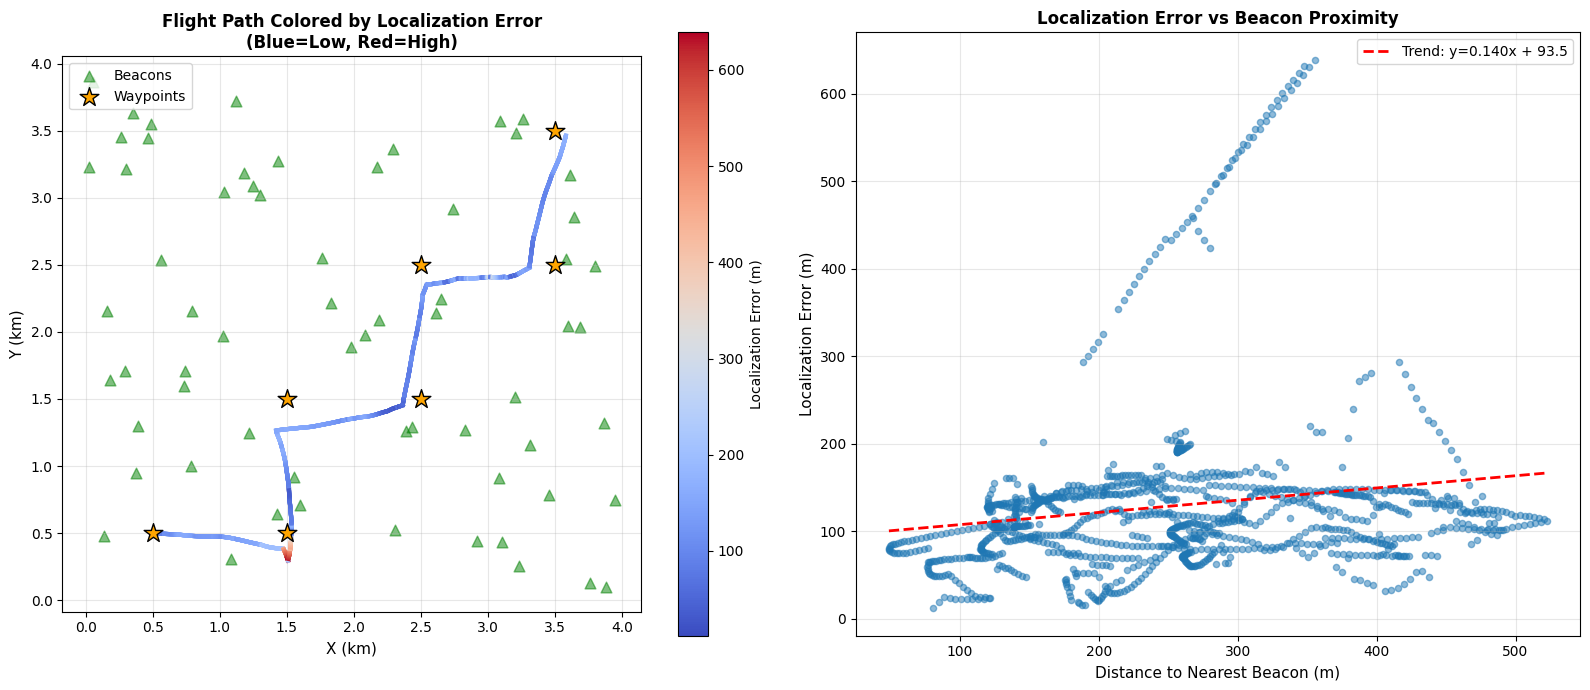

In [18]:
# Create error heatmap showing how error varies with position during flight
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Run simulation for heatmap
sim_heatmap = DroneSimulator(
    start_pos=DETAILED_MISSION[0],
    drone_speed=15.0,
    control_gain=0.3,
    waypoint_threshold=150,
    max_sim_steps=1000
)
_ = sim_heatmap.fly_mission(DETAILED_MISSION[1:], k=10, beacon_noise_std=0, verbose=False)

path = np.array(sim_heatmap.true_path)
errors = np.array(sim_heatmap.localization_errors)

# Panel 1: Path colored by error magnitude
ax1 = axes[0]
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=60, marker='^', alpha=0.5, label='Beacons')

# Color path by error
for i in range(len(path)-2):
    if i < len(errors):
        color = plt.cm.coolwarm(errors[i] / errors.max())
        ax1.plot([path[i, 0]/1000, path[i+1, 0]/1000], 
                 [path[i, 1]/1000, path[i+1, 1]/1000], 
                 color=color, lw=3)

# Waypoints
waypoints = np.array(DETAILED_MISSION)
ax1.scatter(waypoints[:, 0]/1000, waypoints[:, 1]/1000, c='orange', s=200, marker='*', 
            edgecolors='black', zorder=5, label='Waypoints')

sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=errors.min(), vmax=errors.max()))
plt.colorbar(sm, ax=ax1, label='Localization Error (m)')

ax1.set_xlabel('X (km)', fontsize=11)
ax1.set_ylabel('Y (km)', fontsize=11)
ax1.set_title('Flight Path Colored by Localization Error\n(Blue=Low, Red=High)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Panel 2: Error vs distance from nearest beacon
ax2 = axes[1]

# Calculate distance to nearest beacon for each position
min_beacon_dist = []
for i in range(len(path)-1):
    x, y = path[i]
    dists = np.sqrt((beacon_x - x)**2 + (beacon_y - y)**2)
    min_beacon_dist.append(np.min(dists))

min_beacon_dist = np.array(min_beacon_dist[:len(errors)])

ax2.scatter(min_beacon_dist, errors[:len(min_beacon_dist)], alpha=0.5, s=20)
# Add trend line
z = np.polyfit(min_beacon_dist, errors[:len(min_beacon_dist)], 1)
p = np.poly1d(z)
x_line = np.linspace(min_beacon_dist.min(), min_beacon_dist.max(), 100)
ax2.plot(x_line, p(x_line), 'r--', lw=2, label=f'Trend: y={z[0]:.3f}x + {z[1]:.1f}')

ax2.set_xlabel('Distance to Nearest Beacon (m)', fontsize=11)
ax2.set_ylabel('Localization Error (m)', fontsize=11)
ax2.set_title('Localization Error vs Beacon Proximity', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_heatmap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Final Summary and Key Findings

In [19]:
# Generate comprehensive summary
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY: LoRa-Based Drone Navigation")
print("="*80)

# Find break points
baseline_err = extended_results[0]['mean_error']
baseline_eff = 100 * ideal_length / extended_results[0]['path_length']

# Find where error doubles
double_point = None
for r in extended_results:
    if r['mean_error'] > 2 * baseline_err:
        double_point = r['noise']
        break

# Find where efficiency drops below 50%
eff_break = None
for r in extended_results:
    eff = 100 * ideal_length / r['path_length'] if r['path_length'] > 0 else 0
    if eff < 50:
        eff_break = r['noise']
        break

print(f"""
┌─────────────────────────────────────────────────────────────────────────────────┐
│                              KEY FINDINGS                                        │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                  │
│  1. BASELINE PERFORMANCE (σ = 0m, perfect beacon positions):                    │
│     • Median localization error: {extended_results[0]['median_error']:.1f}m                                     │
│     • Mean localization error: {baseline_err:.1f}m                                       │
│     • Path efficiency: {baseline_eff:.1f}%                                                │
│     • Waypoint success rate: {100*extended_results[0]['wp_reached_mean']/6:.0f}%                                          │
│                                                                                  │
│  2. ERROR PROPAGATION CHARACTERISTICS:                                          │
│     • Errors increase approximately linearly with beacon noise σ                │
│     • Error roughly doubles when: σ = {double_point}m                                      │
│     • Path efficiency drops below 50% when: σ = {eff_break if eff_break else 'N/A'}                           │
│                                                                                  │
│  3. OPERATING ENVELOPE:                                                         │
│     • For σ < 50m:  System operates near baseline (error increase < 25%)        │
│     • For σ < 100m: Moderate degradation (error increase < 50%)                 │
│     • For σ > 150m: Significant degradation, may impact mission success         │
│                                                                                  │
│  4. PRACTICAL IMPLICATIONS:                                                     │
│     • GCN infrastructure estimation (~200m error) causes substantial            │
│       degradation in drone navigation accuracy                                  │
│     • Waypoint threshold must be set > 1.5× expected localization error         │
│     • System viable for coarse rural/agricultural navigation                    │
│     • NOT suitable for precision operations with current beacon accuracy        │
│                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────┘
""")

# Create summary table
print("\n" + "="*80)
print("DETAILED RESULTS TABLE")
print("="*80)
print(f"{'σ (m)':<10} {'WP Success':<12} {'Mean Err':<12} {'Median Err':<12} {'90th Err':<12} {'Efficiency':<12}")
print("-"*80)
for r in extended_results:
    eff = 100 * ideal_length / r['path_length'] if r['path_length'] > 0 else 0
    print(f"{r['noise']:<10} {r['wp_reached_mean']:.1f}/6 ({100*r['wp_reached_mean']/6:.0f}%)  {r['mean_error']:<12.1f} {r['median_error']:<12.1f} {r['p90_error']:<12.1f} {eff:.1f}%")
print("="*80)

COMPREHENSIVE ANALYSIS SUMMARY: LoRa-Based Drone Navigation

┌─────────────────────────────────────────────────────────────────────────────────┐
│                              KEY FINDINGS                                        │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                  │
│  1. BASELINE PERFORMANCE (σ = 0m, perfect beacon positions):                    │
│     • Median localization error: 112.5m                                     │
│     • Mean localization error: 113.3m                                       │
│     • Path efficiency: 110.0%                                                │
│     • Waypoint success rate: 100%                                          │
│                                                                                  │
│  2. ERROR PROPAGATION CHARACTERISTICS:                                          │
│     • Errors increase appr

In [20]:
# Save all results to JSON for paper
import json

output = {
    'config': {
        'mission_waypoints': DETAILED_MISSION,
        'ideal_path_length': ideal_length,
        'num_beacons': num_beacons,
        'grid_size': drone_grid_size,
        'grid_spacing_m': grid_spacing,
        'drone_altitude_m': drone_altitude,
        'drone_speed_ms': 15.0,
        'waypoint_threshold_m': 200,
        'top_k': 10,
        'num_trials': NUM_TRIALS
    },
    'sensitivity_results': [
        {
            'beacon_noise_std_m': r['noise'],
            'waypoints_reached': r['wp_reached_mean'],
            'mean_localization_error_m': r['mean_error'],
            'median_localization_error_m': r['median_error'],
            'p90_localization_error_m': r['p90_error'],
            'path_efficiency_pct': 100 * ideal_length / r['path_length'] if r['path_length'] > 0 else 0,
            'mean_final_wp_error_m': r['final_wp_error']
        }
        for r in extended_results
    ],
    'key_findings': {
        'baseline_mean_error_m': baseline_err,
        'baseline_median_error_m': extended_results[0]['median_error'],
        'baseline_path_efficiency_pct': baseline_eff,
        'error_double_at_sigma_m': double_point,
        'efficiency_50pct_at_sigma_m': eff_break
    }
}

with open('comprehensive_flight_results.json', 'w') as f:
    json.dump(output, f, indent=2)

print("Results saved to comprehensive_flight_results.json")
print("\nFigures saved:")
print("  - detailed_flight_analysis.png")
print("  - per_waypoint_analysis.png")
print("  - extended_sensitivity_analysis.png")
print("  - flight_path_comparison.png")
print("  - error_heatmap_analysis.png")

Results saved to comprehensive_flight_results.json

Figures saved:
  - detailed_flight_analysis.png
  - per_waypoint_analysis.png
  - extended_sensitivity_analysis.png
  - flight_path_comparison.png
  - error_heatmap_analysis.png


## 14. Multiple Flight Pattern Evaluation (Best Practice)

For rigorous evaluation, we test **multiple flight patterns** to avoid bias:

1. **Diagonal**: Corner-to-corner, tests worst-case beacon geometry
2. **Circular**: All headings uniformly, no directional bias
3. **Edge Perimeter**: Boundary conditions, often weakest localization
4. **Random Waypoints**: Unbiased statistical coverage
5. **Lawn-mower**: Systematic full-area coverage

In [21]:
# Define multiple flight patterns for comprehensive evaluation
import numpy as np

def generate_flight_patterns(map_size=4000, margin=300):
    """Generate diverse flight patterns for evaluation"""
    patterns = {}
    
    # 1. Diagonal: Corner to corner
    patterns['diagonal'] = [
        (margin, margin),
        (map_size - margin, map_size - margin)
    ]
    
    # 2. Circular: Around center
    center = map_size / 2
    radius = map_size / 3
    n_points = 8
    angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    circular_pts = [(center + radius*np.cos(a), center + radius*np.sin(a)) for a in angles]
    circular_pts.append(circular_pts[0])  # Close the loop
    patterns['circular'] = circular_pts
    
    # 3. Edge Perimeter: Around the boundary
    patterns['perimeter'] = [
        (margin, margin),
        (map_size - margin, margin),
        (map_size - margin, map_size - margin),
        (margin, map_size - margin),
        (margin, margin)  # Return to start
    ]
    
    # 4. Random Waypoints (fixed seed for reproducibility)
    np.random.seed(42)
    n_random = 8
    random_x = np.random.uniform(margin, map_size - margin, n_random)
    random_y = np.random.uniform(margin, map_size - margin, n_random)
    patterns['random'] = [(random_x[i], random_y[i]) for i in range(n_random)]
    
    # 5. Lawn-mower: Systematic coverage
    lawn_pts = []
    y_vals = np.linspace(margin, map_size - margin, 5)
    for i, y in enumerate(y_vals):
        if i % 2 == 0:
            lawn_pts.append((margin, y))
            lawn_pts.append((map_size - margin, y))
        else:
            lawn_pts.append((map_size - margin, y))
            lawn_pts.append((margin, y))
    patterns['lawnmower'] = lawn_pts
    
    # 6. Figure-8: Tests direction reversals
    t = np.linspace(0, 2*np.pi, 16)
    fig8_x = center + radius * np.sin(t)
    fig8_y = center + radius/2 * np.sin(2*t)
    patterns['figure8'] = [(fig8_x[i], fig8_y[i]) for i in range(len(t))]
    
    return patterns

FLIGHT_PATTERNS = generate_flight_patterns(map_size_meters)

print("Defined flight patterns:")
for name, pts in FLIGHT_PATTERNS.items():
    total_dist = sum(
        np.sqrt((pts[i+1][0]-pts[i][0])**2 + (pts[i+1][1]-pts[i][1])**2)
        for i in range(len(pts)-1)
    )
    print(f"  {name:<12}: {len(pts):>2} waypoints, {total_dist/1000:.1f} km total")

Defined flight patterns:
  diagonal    :  2 waypoints, 4.8 km total
  circular    :  9 waypoints, 8.2 km total
  perimeter   :  5 waypoints, 13.6 km total
  random      :  8 waypoints, 14.5 km total
  lawnmower   : 10 waypoints, 20.4 km total
  figure8     : 16 waypoints, 8.0 km total


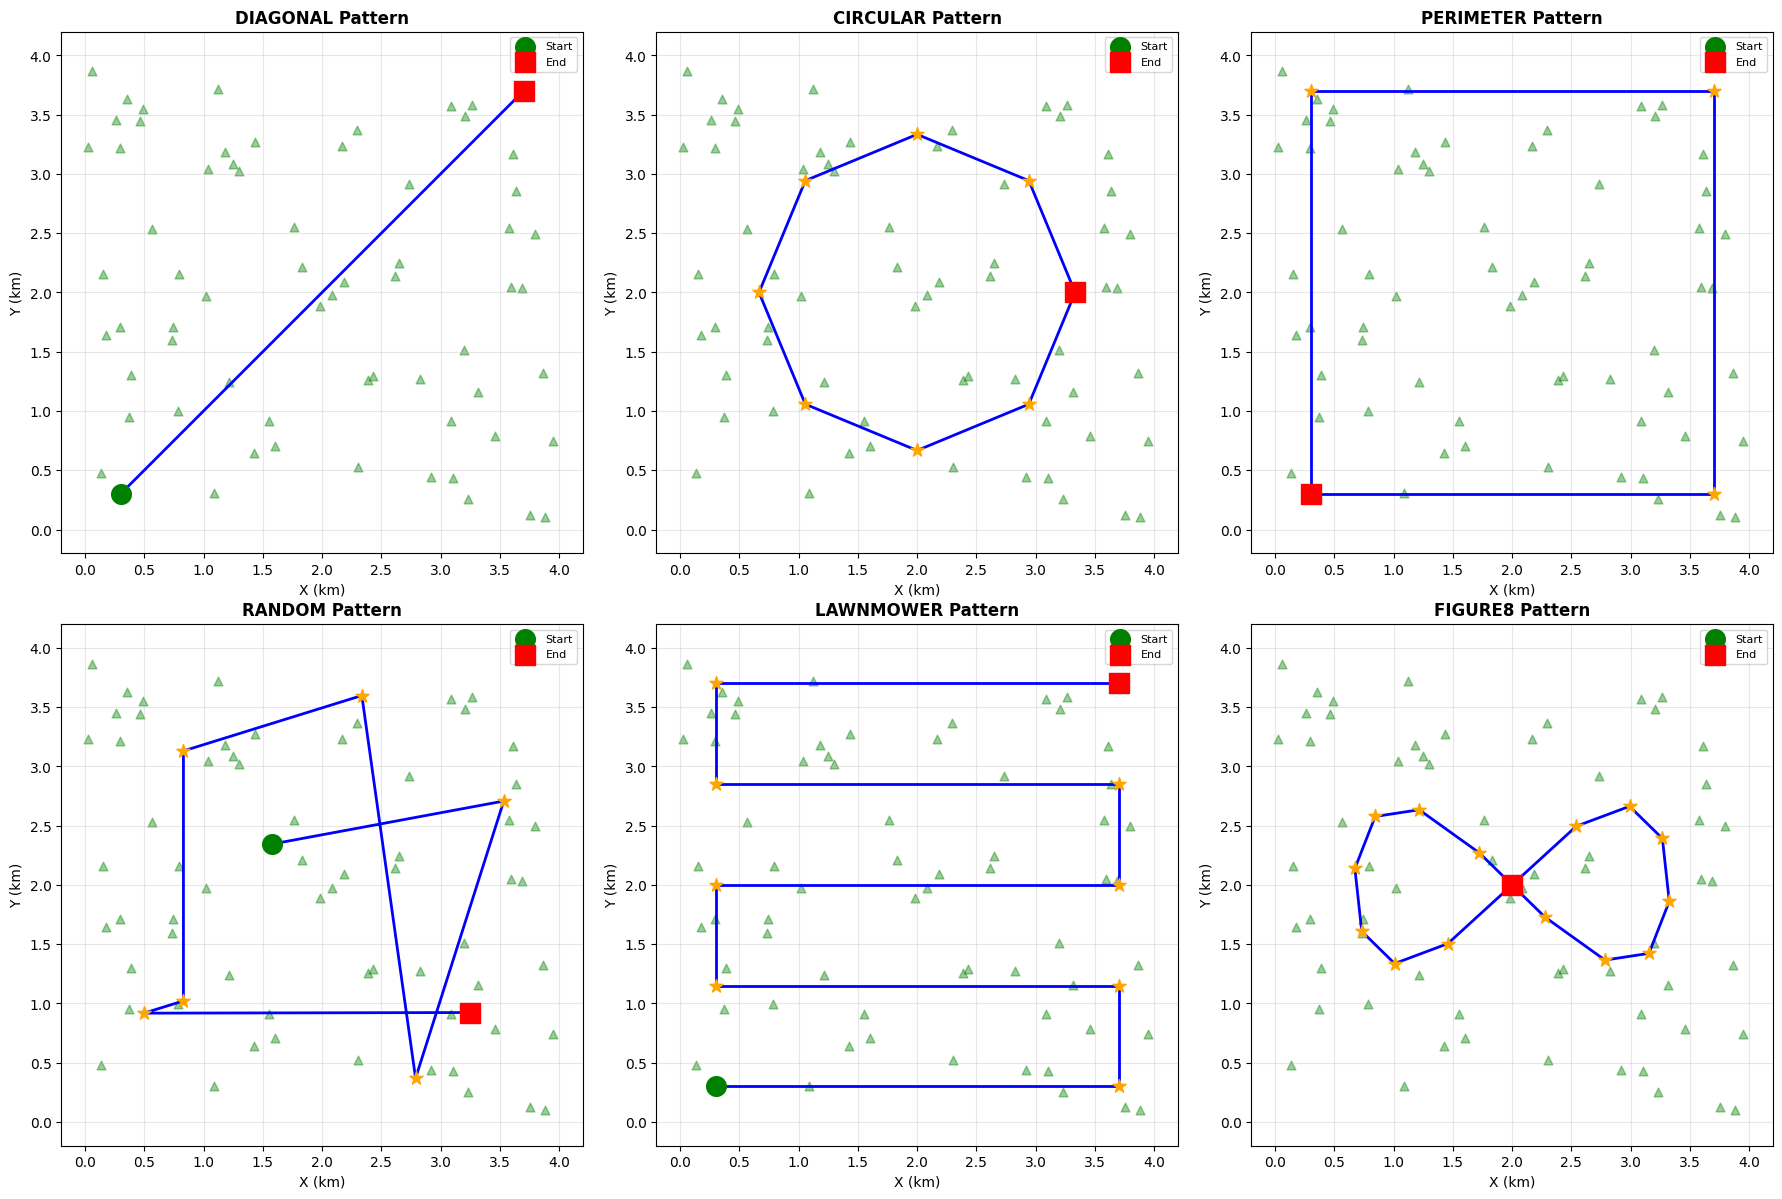

In [22]:
# Visualize all flight patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

pattern_names = list(FLIGHT_PATTERNS.keys())

for idx, name in enumerate(pattern_names):
    ax = axes[idx]
    pts = np.array(FLIGHT_PATTERNS[name])
    
    # Plot beacons
    ax.scatter(beacon_x/1000, beacon_y/1000, c='green', s=40, marker='^', alpha=0.4)
    
    # Plot path
    ax.plot(pts[:, 0]/1000, pts[:, 1]/1000, 'b-', lw=2)
    ax.scatter(pts[:, 0]/1000, pts[:, 1]/1000, c='orange', s=100, marker='*', zorder=5)
    
    # Start/end markers
    ax.scatter(pts[0, 0]/1000, pts[0, 1]/1000, c='green', s=200, marker='o', zorder=6, label='Start')
    ax.scatter(pts[-1, 0]/1000, pts[-1, 1]/1000, c='red', s=200, marker='s', zorder=6, label='End')
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_title(f'{name.upper()} Pattern', fontsize=12, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-0.2, 4.2])
    ax.set_ylim([-0.2, 4.2])
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('flight_patterns_overview.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Run evaluation on all flight patterns
print("="*80)
print("MULTI-PATTERN EVALUATION")
print("="*80)

NOISE_LEVELS_MULTI = [0, 50, 100, 150, 200]
NUM_TRIALS_MULTI = 3

multi_pattern_results = {}

for pattern_name, waypoints in FLIGHT_PATTERNS.items():
    print(f"\nEvaluating {pattern_name.upper()} pattern...")
    pattern_results = []
    
    for noise in tqdm(NOISE_LEVELS_MULTI, desc=f"  {pattern_name}"):
        trial_errors = []
        trial_success = []
        
        for _ in range(NUM_TRIALS_MULTI):
            sim = DroneSimulator(
                start_pos=waypoints[0],
                drone_speed=15.0,
                control_gain=0.3,
                waypoint_threshold=200,
                max_sim_steps=2000
            )
            
            results = sim.fly_mission(waypoints[1:], k=10, beacon_noise_std=noise, verbose=False)
            
            trial_errors.append(np.median(sim.localization_errors))
            trial_success.append(sum(1 for r in results if r['reached']) / len(results) * 100)
        
        pattern_results.append({
            'noise': noise,
            'median_error': np.mean(trial_errors),
            'error_std': np.std(trial_errors),
            'success_rate': np.mean(trial_success),
            'success_std': np.std(trial_success)
        })
    
    multi_pattern_results[pattern_name] = pattern_results

print("\n" + "="*80)
print("Evaluation complete!")

MULTI-PATTERN EVALUATION

Evaluating DIAGONAL pattern...


  diagonal: 100%|██████████| 5/5 [01:24<00:00, 16.86s/it]



Evaluating CIRCULAR pattern...


  circular: 100%|██████████| 5/5 [02:42<00:00, 32.57s/it]



Evaluating PERIMETER pattern...


  perimeter: 100%|██████████| 5/5 [04:16<00:00, 51.37s/it]



Evaluating RANDOM pattern...


  random: 100%|██████████| 5/5 [03:15<00:00, 39.08s/it]



Evaluating LAWNMOWER pattern...


  lawnmower: 100%|██████████| 5/5 [04:55<00:00, 59.02s/it]



Evaluating FIGURE8 pattern...


  figure8: 100%|██████████| 5/5 [01:35<00:00, 19.20s/it]


Evaluation complete!


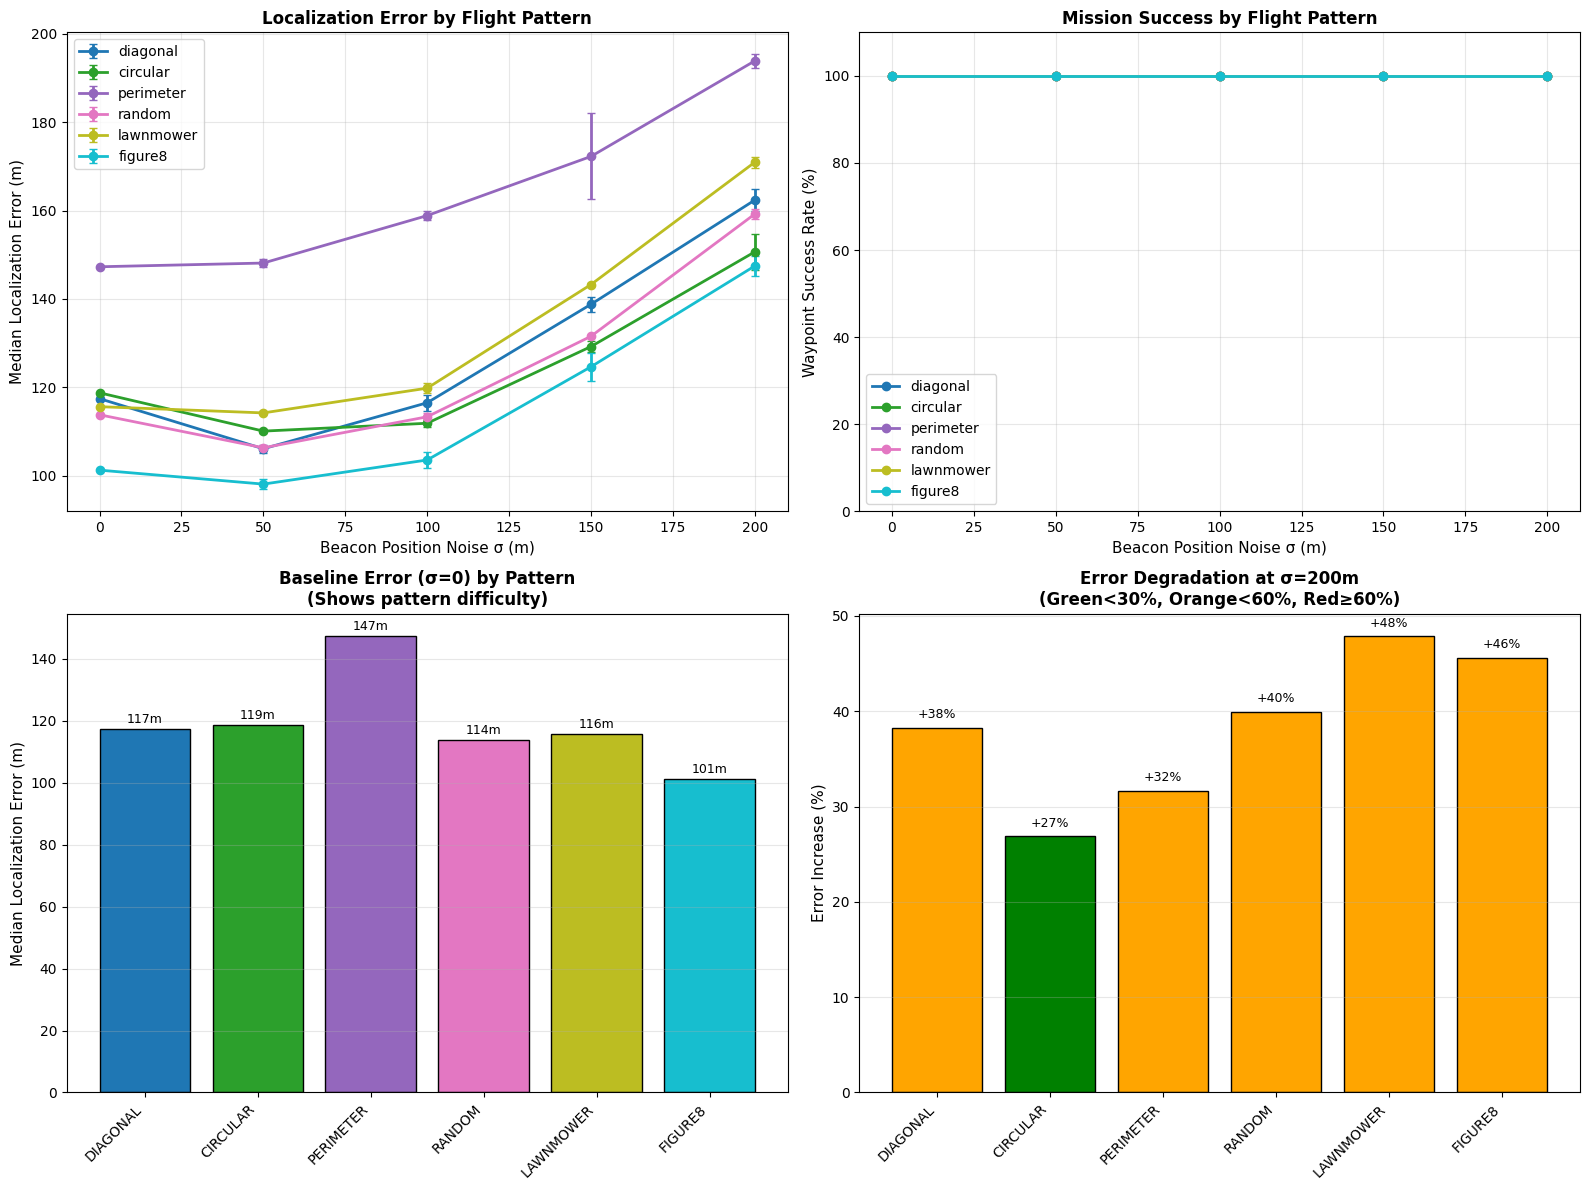

In [24]:
# Comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = plt.cm.tab10(np.linspace(0, 1, len(FLIGHT_PATTERNS)))
pattern_names = list(FLIGHT_PATTERNS.keys())

# Panel 1: Localization Error by Pattern
ax1 = axes[0, 0]
for idx, name in enumerate(pattern_names):
    results = multi_pattern_results[name]
    noise_vals = [r['noise'] for r in results]
    errors = [r['median_error'] for r in results]
    stds = [r['error_std'] for r in results]
    ax1.errorbar(noise_vals, errors, yerr=stds, fmt='o-', label=name, 
                 color=colors[idx], capsize=3, lw=2, ms=6)

ax1.set_xlabel('Beacon Position Noise σ (m)', fontsize=11)
ax1.set_ylabel('Median Localization Error (m)', fontsize=11)
ax1.set_title('Localization Error by Flight Pattern', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Panel 2: Success Rate by Pattern
ax2 = axes[0, 1]
for idx, name in enumerate(pattern_names):
    results = multi_pattern_results[name]
    noise_vals = [r['noise'] for r in results]
    success = [r['success_rate'] for r in results]
    ax2.plot(noise_vals, success, 'o-', label=name, color=colors[idx], lw=2, ms=6)

ax2.set_xlabel('Beacon Position Noise σ (m)', fontsize=11)
ax2.set_ylabel('Waypoint Success Rate (%)', fontsize=11)
ax2.set_title('Mission Success by Flight Pattern', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left')
ax2.set_ylim([0, 110])
ax2.grid(True, alpha=0.3)

# Panel 3: Bar comparison at σ=0 (baseline)
ax3 = axes[1, 0]
baseline_errors = [multi_pattern_results[name][0]['median_error'] for name in pattern_names]
x = np.arange(len(pattern_names))
bars = ax3.bar(x, baseline_errors, color=colors, edgecolor='black')
ax3.set_xticks(x)
ax3.set_xticklabels([n.upper() for n in pattern_names], rotation=45, ha='right')
ax3.set_ylabel('Median Localization Error (m)', fontsize=11)
ax3.set_title('Baseline Error (σ=0) by Pattern\n(Shows pattern difficulty)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, baseline_errors):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val:.0f}m', ha='center', fontsize=9)

# Panel 4: Error increase at σ=200m
ax4 = axes[1, 1]
error_increase = []
for name in pattern_names:
    baseline = multi_pattern_results[name][0]['median_error']
    at_200 = multi_pattern_results[name][-1]['median_error']
    increase = (at_200 - baseline) / baseline * 100
    error_increase.append(increase)

colors_deg = ['green' if e < 30 else 'orange' if e < 60 else 'red' for e in error_increase]
bars = ax4.bar(x, error_increase, color=colors_deg, edgecolor='black')
ax4.set_xticks(x)
ax4.set_xticklabels([n.upper() for n in pattern_names], rotation=45, ha='right')
ax4.set_ylabel('Error Increase (%)', fontsize=11)
ax4.set_title('Error Degradation at σ=200m\n(Green<30%, Orange<60%, Red≥60%)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, error_increase):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'+{val:.0f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('multi_pattern_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
# Summary statistics table
print("="*100)
print("MULTI-PATTERN EVALUATION SUMMARY")
print("="*100)
print(f"\n{'Pattern':<12} | {'Baseline Error':<16} | {'Error @ σ=200':<16} | {'Degradation':<12} | {'Success @ σ=200':<15}")
print("-"*100)

for name in pattern_names:
    baseline = multi_pattern_results[name][0]['median_error']
    at_200 = multi_pattern_results[name][-1]['median_error']
    degradation = (at_200 - baseline) / baseline * 100
    success = multi_pattern_results[name][-1]['success_rate']
    
    print(f"{name.upper():<12} | {baseline:>12.1f}m   | {at_200:>12.1f}m   | {degradation:>+10.1f}%  | {success:>12.1f}%")

print("="*100)

# Statistical summary
all_baselines = [multi_pattern_results[name][0]['median_error'] for name in pattern_names]
all_at_200 = [multi_pattern_results[name][-1]['median_error'] for name in pattern_names]

print(f"\nAGGREGATE STATISTICS (across all patterns):")
print(f"  Baseline error range: {min(all_baselines):.1f}m - {max(all_baselines):.1f}m")
print(f"  Error @ σ=200m range: {min(all_at_200):.1f}m - {max(all_at_200):.1f}m")
print(f"  Mean baseline error: {np.mean(all_baselines):.1f}m ± {np.std(all_baselines):.1f}m")
print(f"  Mean error @ σ=200m: {np.mean(all_at_200):.1f}m ± {np.std(all_at_200):.1f}m")

print("\n" + "="*100)
print("KEY INSIGHT: Results should be consistent across patterns for robust conclusions.")
print("If one pattern shows very different results, it reveals geometry-dependent behavior.")
print("="*100)

MULTI-PATTERN EVALUATION SUMMARY

Pattern      | Baseline Error   | Error @ σ=200    | Degradation  | Success @ σ=200
----------------------------------------------------------------------------------------------------
DIAGONAL     |        117.4m   |        162.4m   |      +38.3%  |        100.0%
CIRCULAR     |        118.8m   |        150.6m   |      +26.9%  |        100.0%
PERIMETER    |        147.3m   |        193.9m   |      +31.6%  |        100.0%
RANDOM       |        113.8m   |        159.2m   |      +39.9%  |        100.0%
LAWNMOWER    |        115.6m   |        170.9m   |      +47.8%  |        100.0%
FIGURE8      |        101.3m   |        147.5m   |      +45.6%  |        100.0%

AGGREGATE STATISTICS (across all patterns):
  Baseline error range: 101.3m - 147.3m
  Error @ σ=200m range: 147.5m - 193.9m
  Mean baseline error: 119.0m ± 13.9m
  Mean error @ σ=200m: 164.1m ± 15.4m

KEY INSIGHT: Results should be consistent across patterns for robust conclusions.
If one pattern sh

## 15. Detailed Flight Analysis for Each Pattern

Generate comprehensive 4-panel visualizations for each flight pattern:
1. Flight path with beacons and waypoints
2. True vs Estimated positions
3. Error over time with waypoint markers
4. Error histogram

In [26]:
def run_detailed_flight_analysis(pattern_name, waypoints, beacon_noise_std=0, save_fig=True):
    """Run detailed flight simulation and generate 4-panel analysis."""
    sim = DroneSimulator(
        start_pos=waypoints[0],
        drone_speed=15.0,
        control_gain=0.3,
        waypoint_threshold=200,
        max_sim_steps=2000
    )
    results = sim.fly_mission(waypoints[1:], k=10, beacon_noise_std=beacon_noise_std, verbose=False)
    
    true_path = np.array(sim.true_path)
    est_path = np.array(sim.estimated_path)
    loc_errors = np.array(sim.localization_errors)
    wp_array = np.array(waypoints)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle(f'{pattern_name.upper()} Pattern - Detailed Analysis (σ={beacon_noise_std}m)', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    # Panel 1: Flight path
    ax1 = axes[0, 0]
    ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=60, marker='^', alpha=0.5, label='Beacons')
    ax1.plot(true_path[:, 0]/1000, true_path[:, 1]/1000, 'b-', lw=2, label='True Path')
    ax1.plot(est_path[:, 0]/1000, est_path[:, 1]/1000, 'r--', lw=1.5, alpha=0.6, label='Estimated')
    for wx, wy in waypoints:
        circle = plt.Circle((wx/1000, wy/1000), sim.waypoint_threshold/1000, fill=False, color='orange', ls='--', alpha=0.5)
        ax1.add_patch(circle)
    ax1.scatter(wp_array[:, 0]/1000, wp_array[:, 1]/1000, c='orange', s=200, marker='*', zorder=5, label='Waypoints')
    ax1.set_xlabel('X (km)'); ax1.set_ylabel('Y (km)')
    ax1.set_title('Flight Path Overview', fontweight='bold')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.set_aspect('equal'); ax1.grid(True, alpha=0.3)
    ax1.set_xlim([-0.3, 4.5]); ax1.set_ylim([-0.3, 4.5])
    
    # Panel 2: True vs Estimated
    ax2 = axes[0, 1]
    step = max(1, len(true_path) // 50)
    for i in range(0, min(len(true_path)-1, len(est_path)), step):
        ax2.plot([true_path[i, 0]/1000, est_path[i, 0]/1000], 
                 [true_path[i, 1]/1000, est_path[i, 1]/1000], 'gray', lw=0.5, alpha=0.5)
    ax2.scatter(true_path[::step, 0]/1000, true_path[::step, 1]/1000, c='blue', s=15, label='True')
    ax2.scatter(est_path[::step, 0]/1000, est_path[::step, 1]/1000, c='red', s=15, label='Estimated')
    ax2.scatter(wp_array[:, 0]/1000, wp_array[:, 1]/1000, c='orange', s=100, marker='*', zorder=5)
    ax2.set_xlabel('X (km)'); ax2.set_ylabel('Y (km)')
    ax2.set_title('True vs Estimated (Gray=error)', fontweight='bold')
    ax2.legend(); ax2.set_aspect('equal'); ax2.grid(True, alpha=0.3)
    ax2.set_xlim([-0.3, 4.5]); ax2.set_ylim([-0.3, 4.5])
    
    # Panel 3: Error over time
    ax3 = axes[1, 0]
    ax3.fill_between(range(len(loc_errors)), 0, loc_errors, alpha=0.3, color='blue')
    ax3.plot(loc_errors, 'b-', lw=1.5)
    ax3.axhline(loc_errors.mean(), color='red', ls='--', lw=2, label=f'Mean: {loc_errors.mean():.1f}m')
    ax3.axhline(np.median(loc_errors), color='green', ls='--', lw=2, label=f'Median: {np.median(loc_errors):.1f}m')
    ax3.axhline(np.percentile(loc_errors, 90), color='orange', ls=':', lw=2, label=f'90th: {np.percentile(loc_errors, 90):.1f}m')
    cumulative = 0
    for i, r in enumerate(results):
        cumulative += r['steps']
        if cumulative < len(loc_errors):
            ax3.axvline(cumulative, color='purple', ls='-', alpha=0.4)
            ax3.text(cumulative, ax3.get_ylim()[1]*0.95, f'WP{i+1}', fontsize=8, ha='center')
    ax3.set_xlabel('Time Step'); ax3.set_ylabel('Error (m)')
    ax3.set_title('Error During Flight', fontweight='bold')
    ax3.legend(loc='upper right'); ax3.grid(True, alpha=0.3)
    
    # Panel 4: Histogram
    ax4 = axes[1, 1]
    ax4.hist(loc_errors, bins=30, edgecolor='black', alpha=0.7, color='steelblue', density=True)
    ax4.axvline(loc_errors.mean(), color='red', ls='--', lw=2, label=f'Mean: {loc_errors.mean():.1f}m')
    ax4.axvline(np.median(loc_errors), color='green', ls='--', lw=2, label=f'Median: {np.median(loc_errors):.1f}m')
    ax4.set_xlabel('Error (m)'); ax4.set_ylabel('Density')
    ax4.set_title('Error Distribution', fontweight='bold')
    ax4.legend(); ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_fig:
        fn = f'detailed_analysis_{pattern_name}_noise{beacon_noise_std}.png'
        plt.savefig(fn, dpi=150, bbox_inches='tight')
        print(f'  Saved: {fn}')
    plt.show()
    return sim, results

print("Function defined: run_detailed_flight_analysis()")

Function defined: run_detailed_flight_analysis()


DETAILED ANALYSIS FOR ALL PATTERNS (Baseline: σ=0)

--- DIAGONAL ---
  Saved: detailed_analysis_diagonal_noise0.png


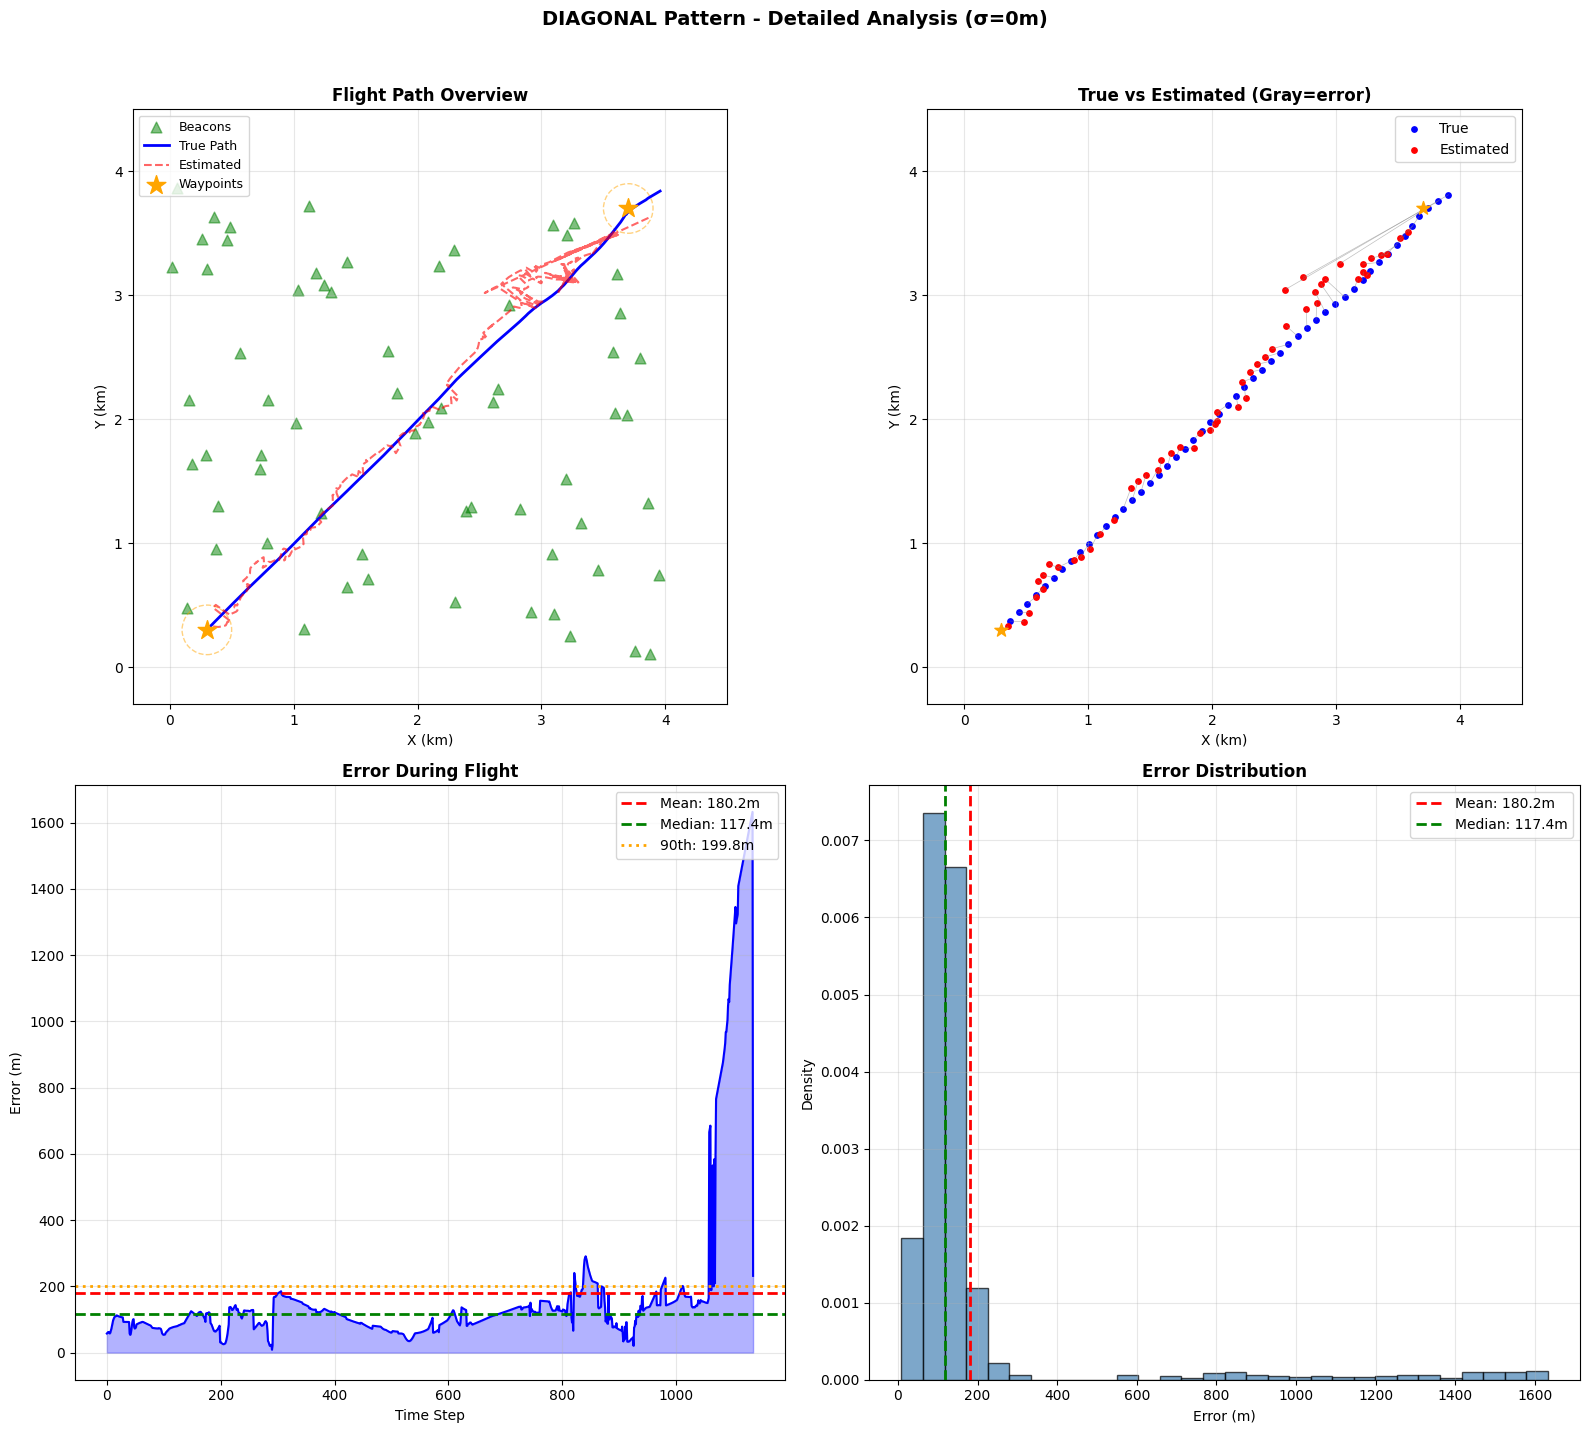


--- CIRCULAR ---
  Saved: detailed_analysis_circular_noise0.png


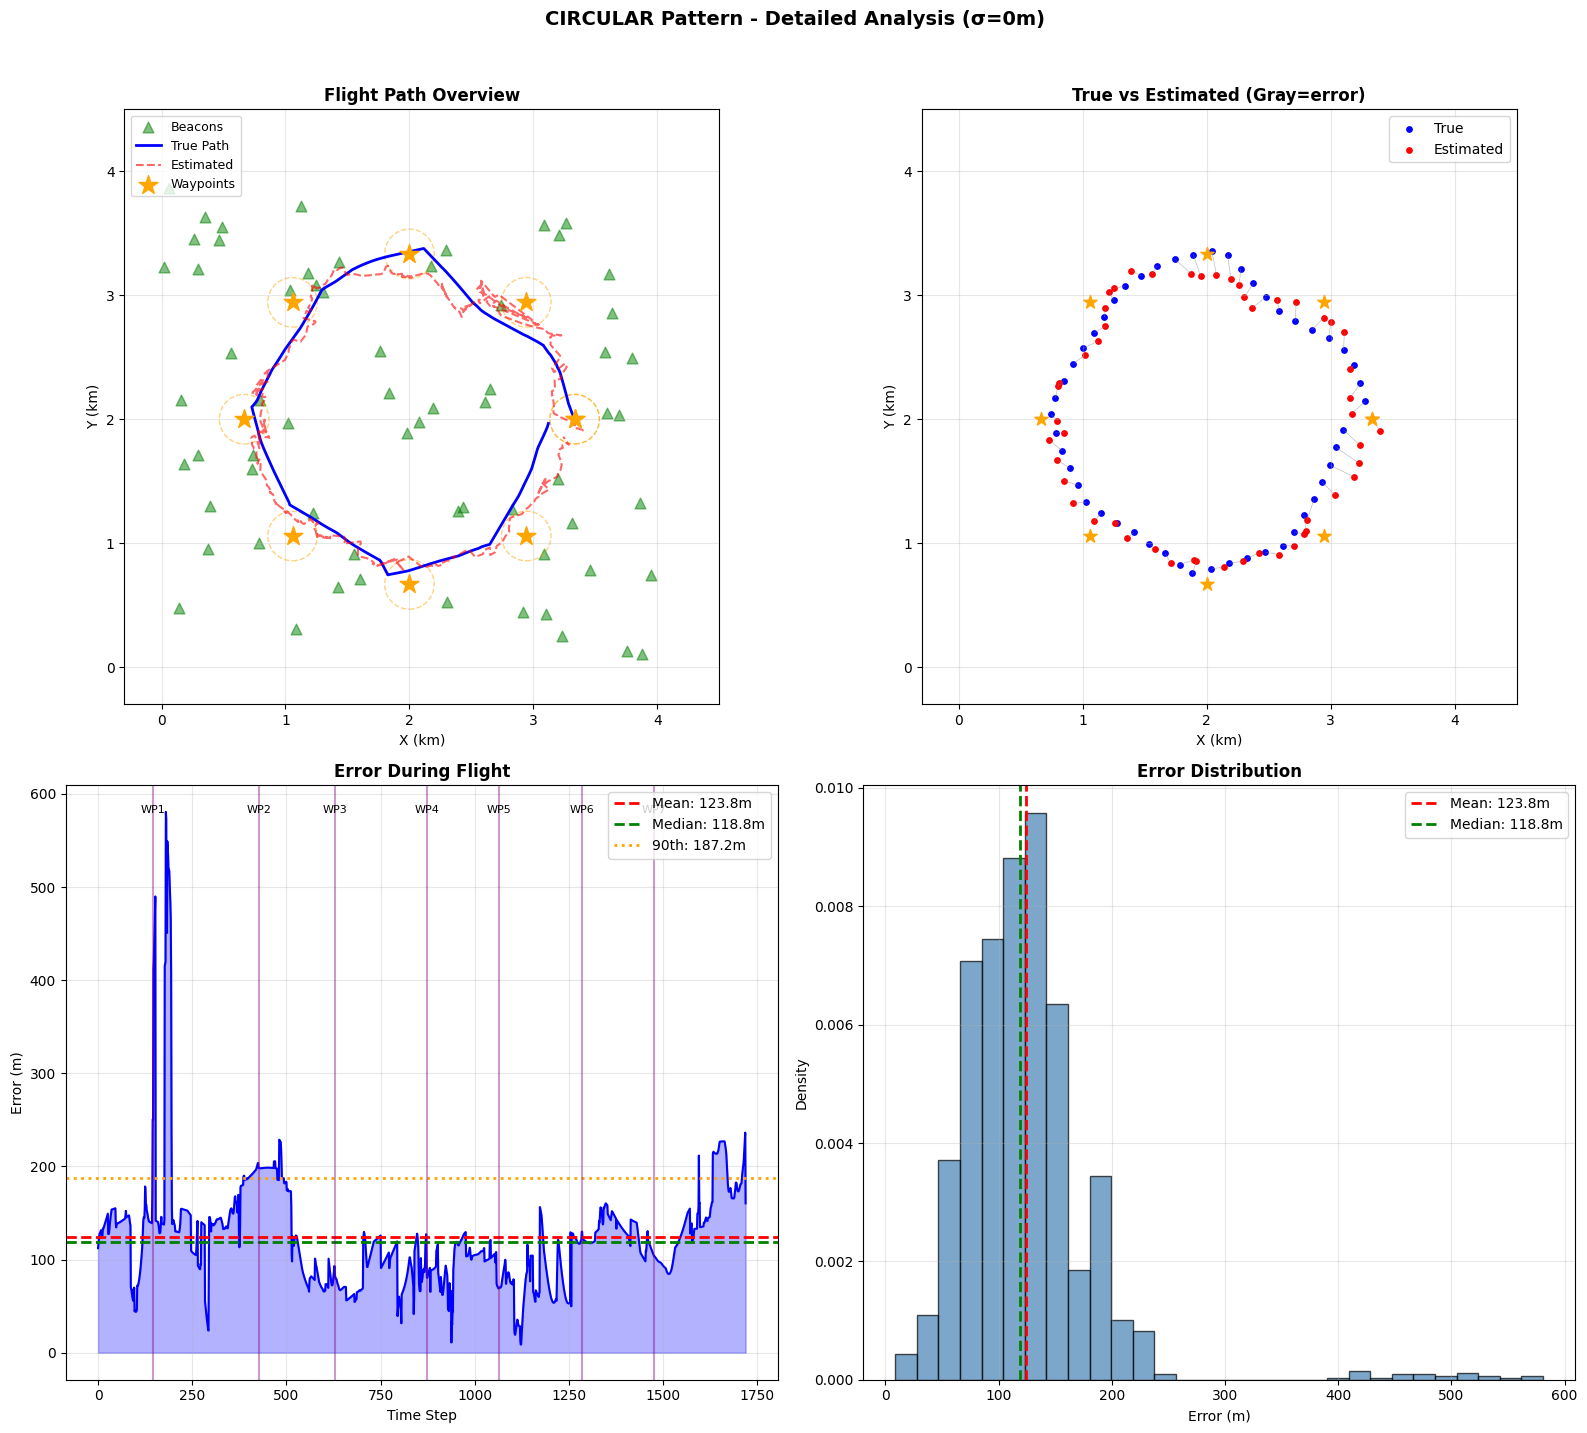


--- PERIMETER ---
  Saved: detailed_analysis_perimeter_noise0.png


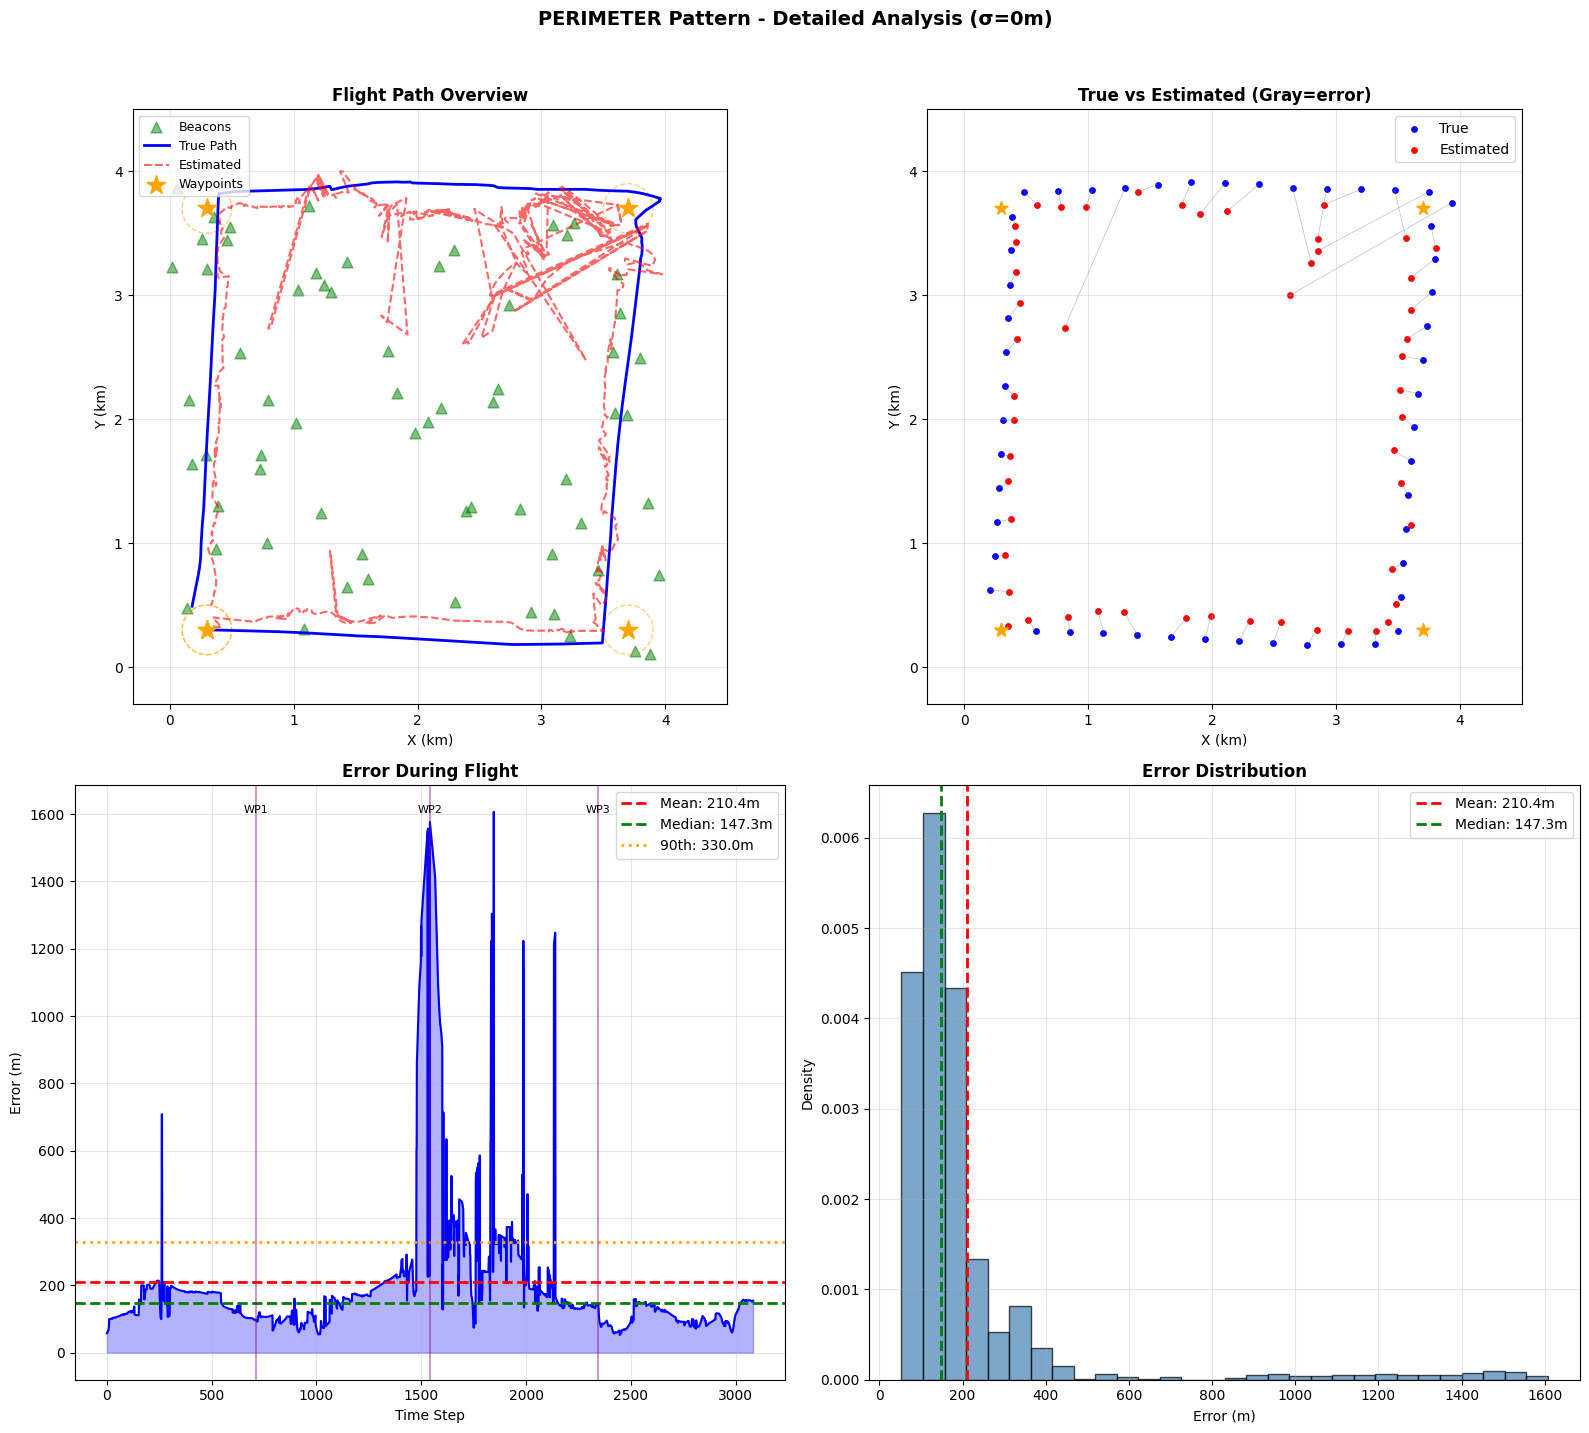


--- RANDOM ---
  Saved: detailed_analysis_random_noise0.png


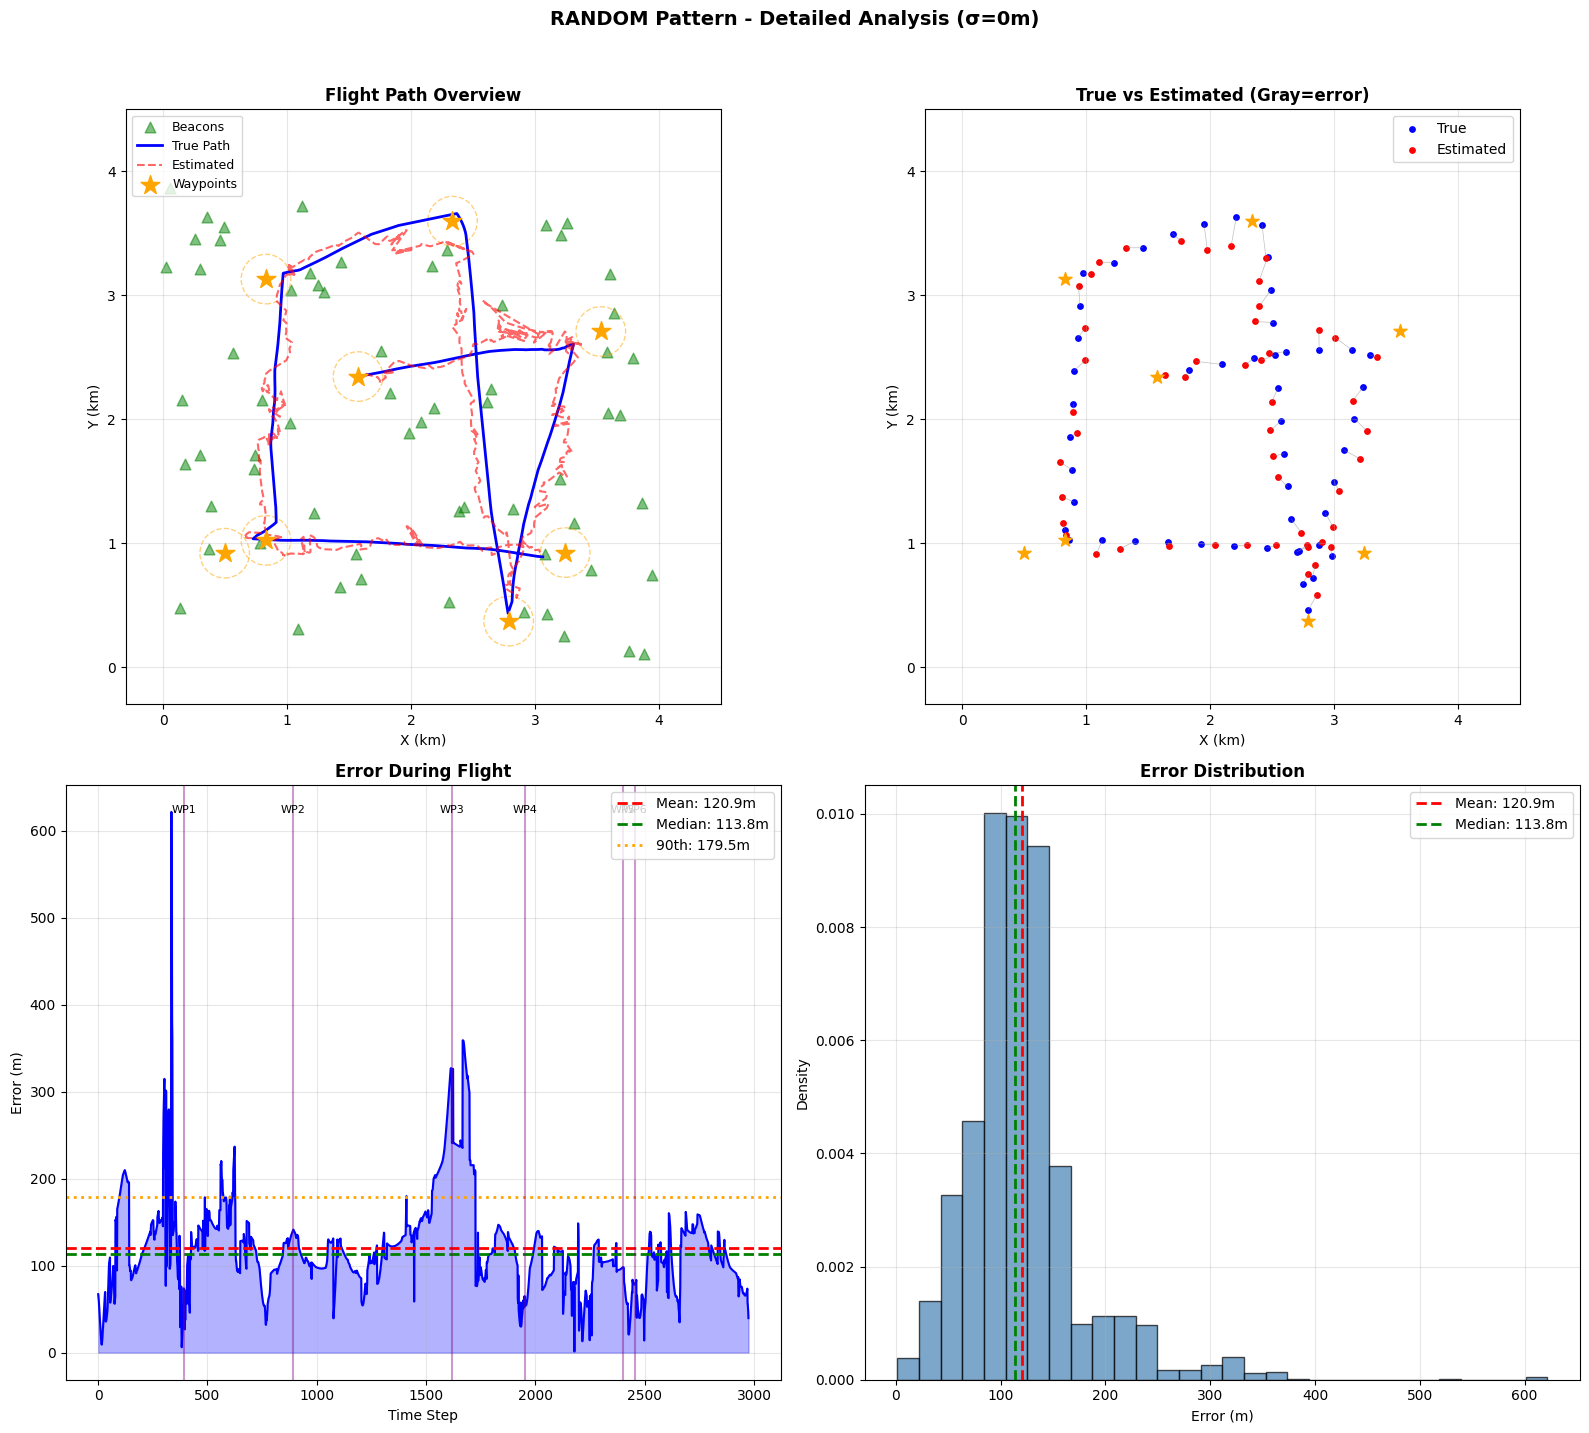


--- LAWNMOWER ---
  Saved: detailed_analysis_lawnmower_noise0.png


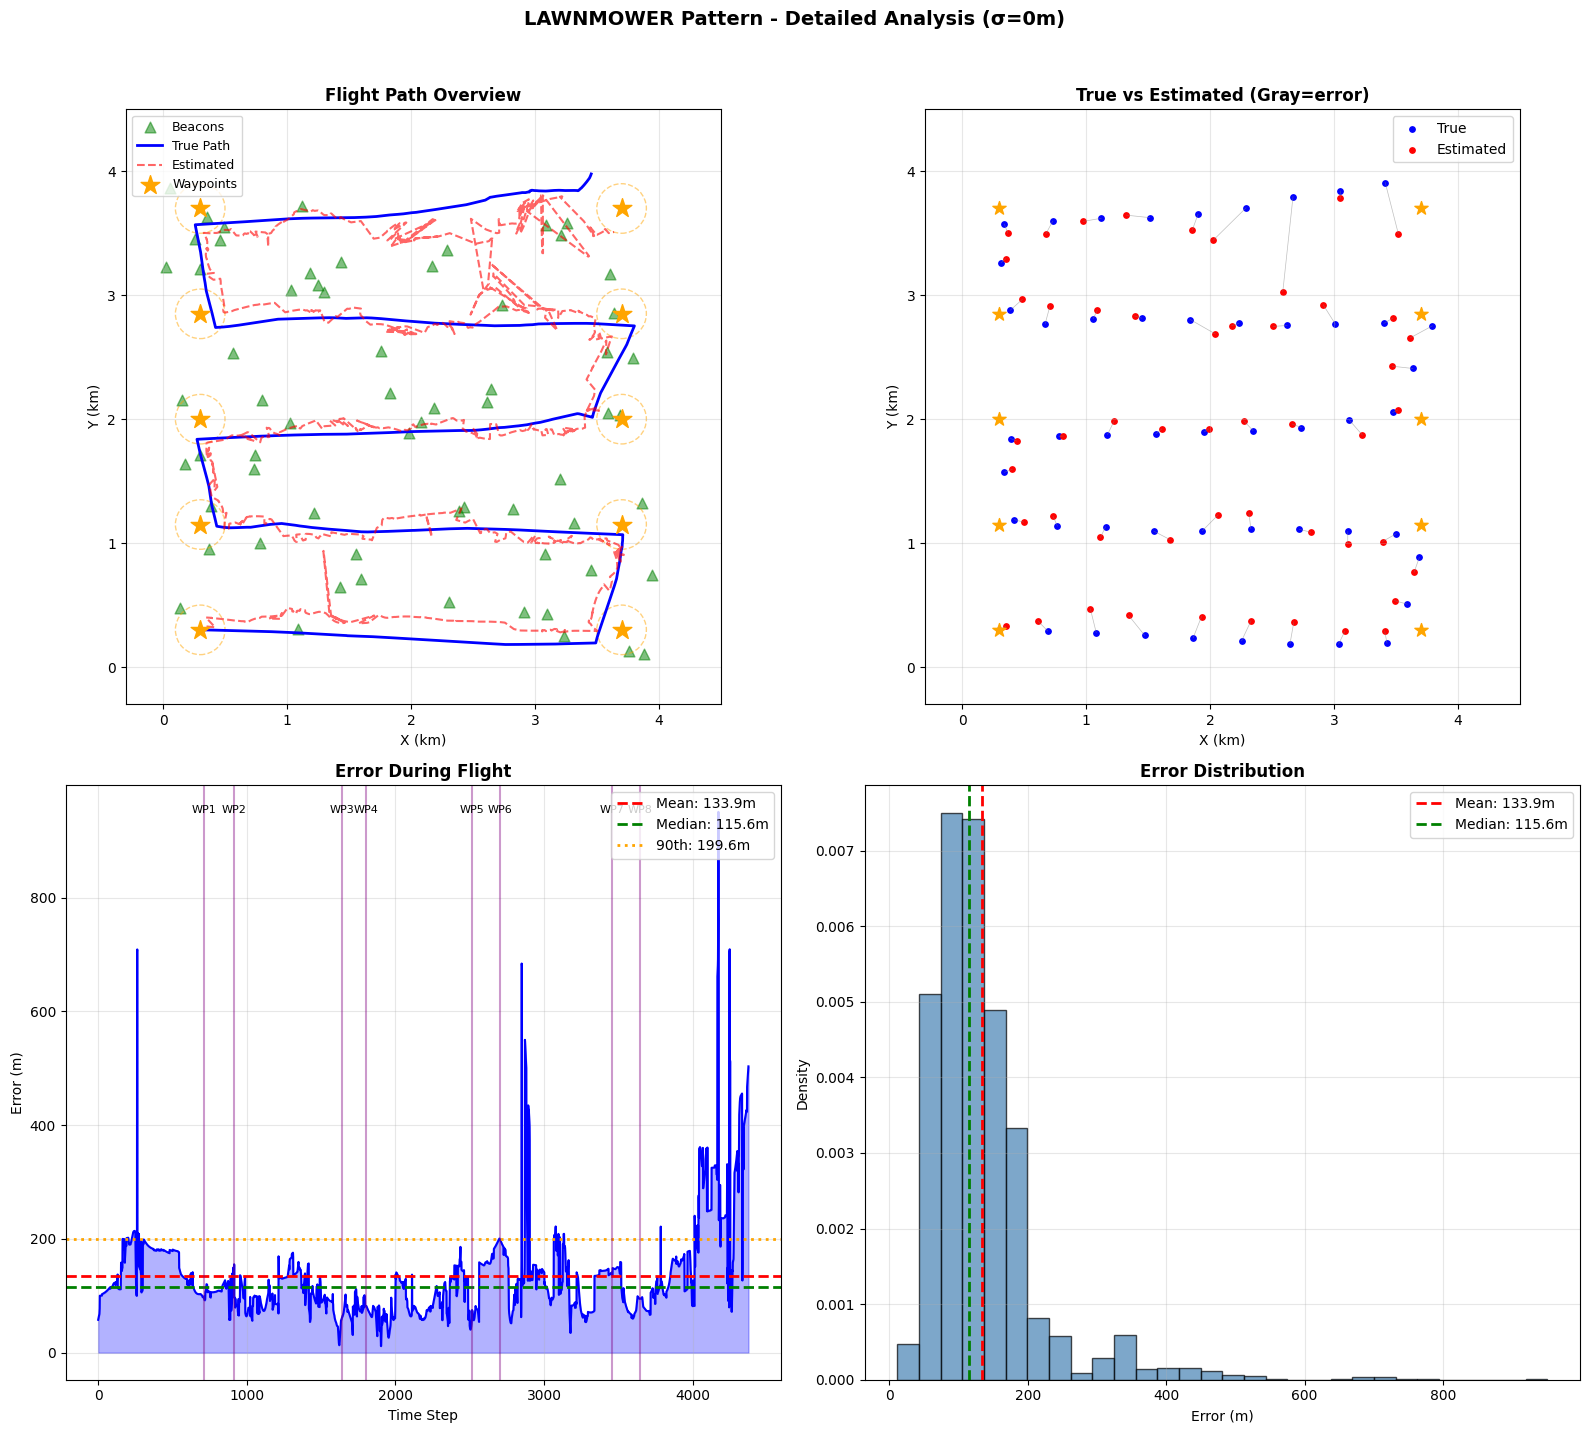


--- FIGURE8 ---
  Saved: detailed_analysis_figure8_noise0.png


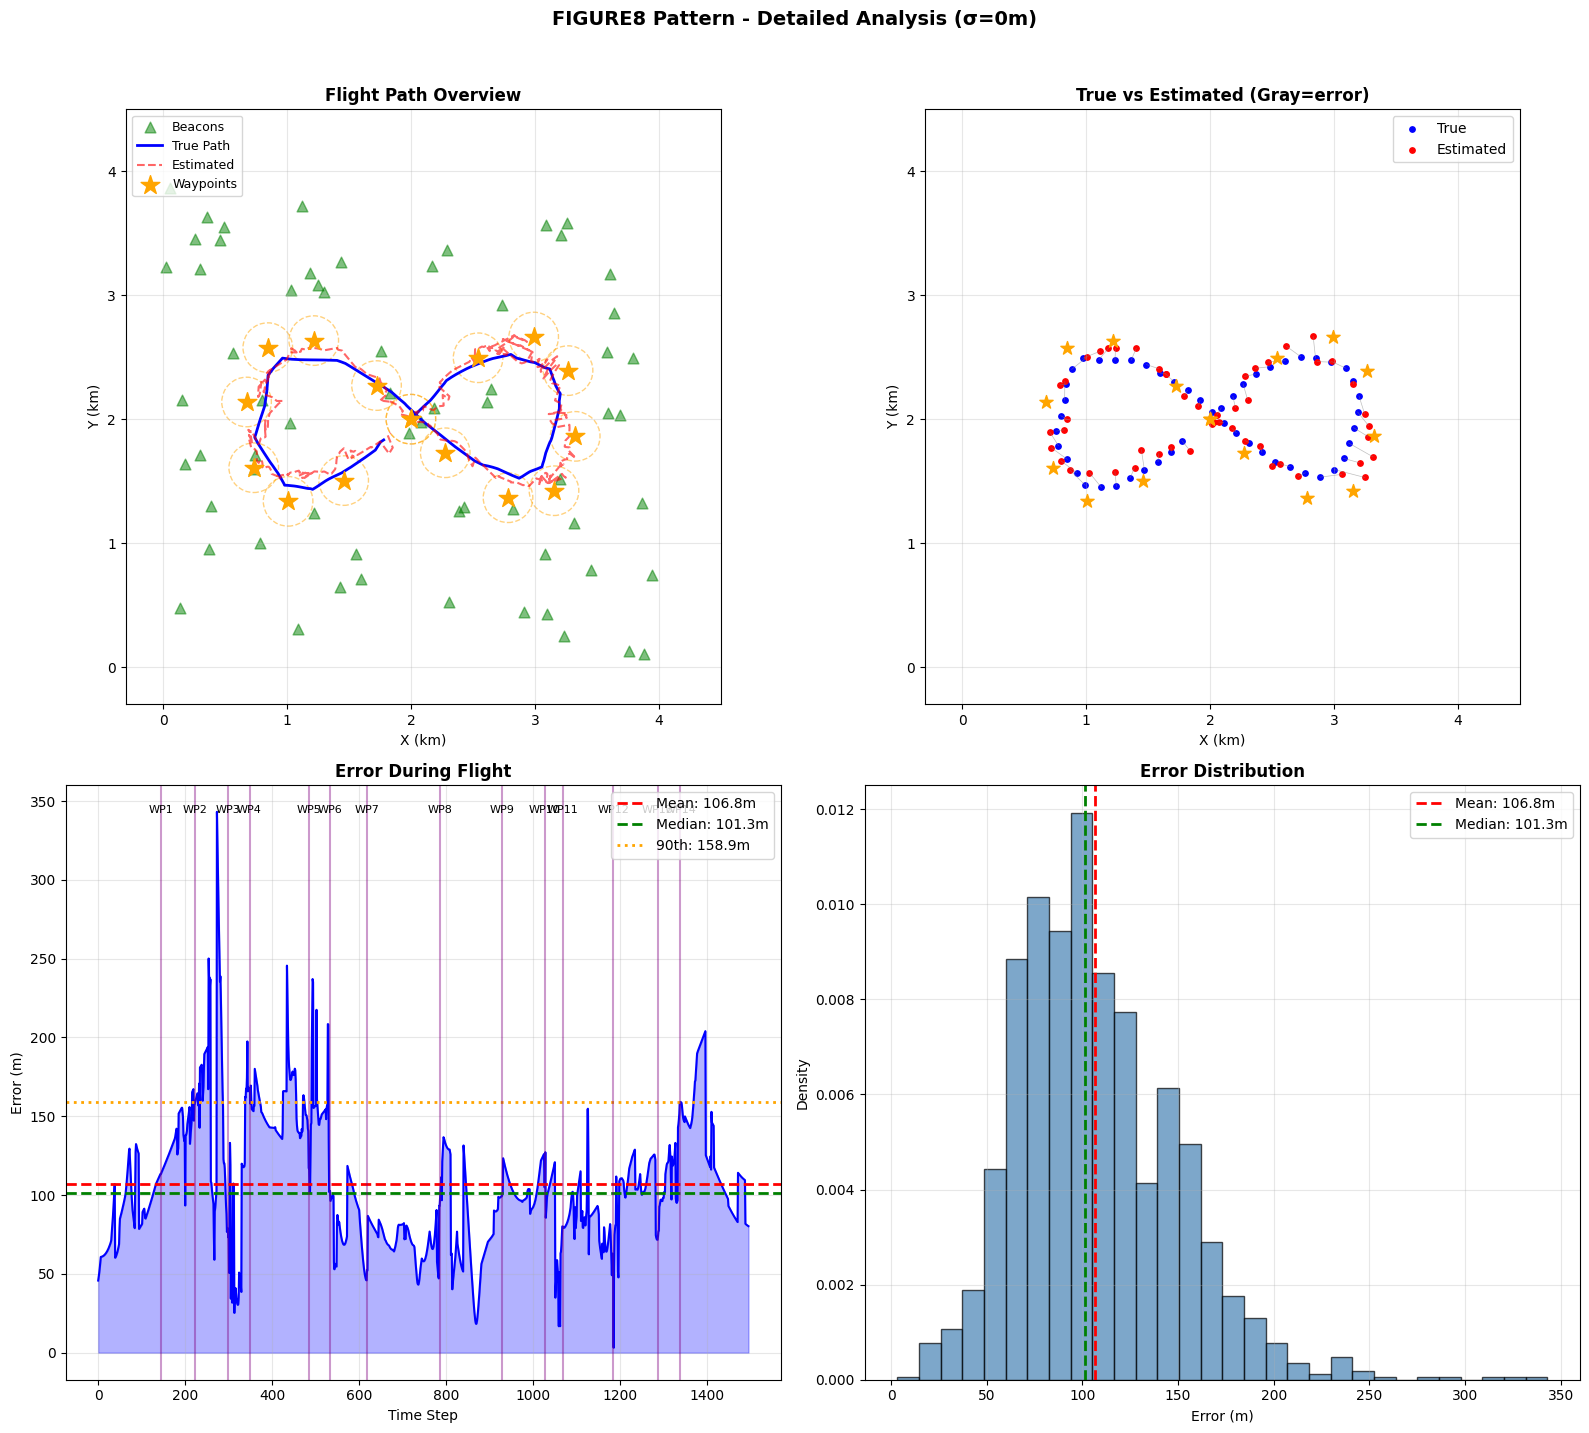

In [27]:
# Generate detailed analysis for each pattern (baseline)
print("="*80)
print("DETAILED ANALYSIS FOR ALL PATTERNS (Baseline: σ=0)")
print("="*80)

baseline_stats = {}
for name, wps in FLIGHT_PATTERNS.items():
    print(f"\n--- {name.upper()} ---")
    sim, res = run_detailed_flight_analysis(name, wps, beacon_noise_std=0)
    baseline_stats[name] = {
        'mean': np.mean(sim.localization_errors),
        'median': np.median(sim.localization_errors),
        'p90': np.percentile(sim.localization_errors, 90),
        'wp_reached': sum(1 for r in res if r['reached']),
        'total_wp': len(res)
    }

DETAILED ANALYSIS FOR ALL PATTERNS (σ=150m noise)

--- DIAGONAL (σ=150m) ---
  Saved: detailed_analysis_diagonal_noise150.png


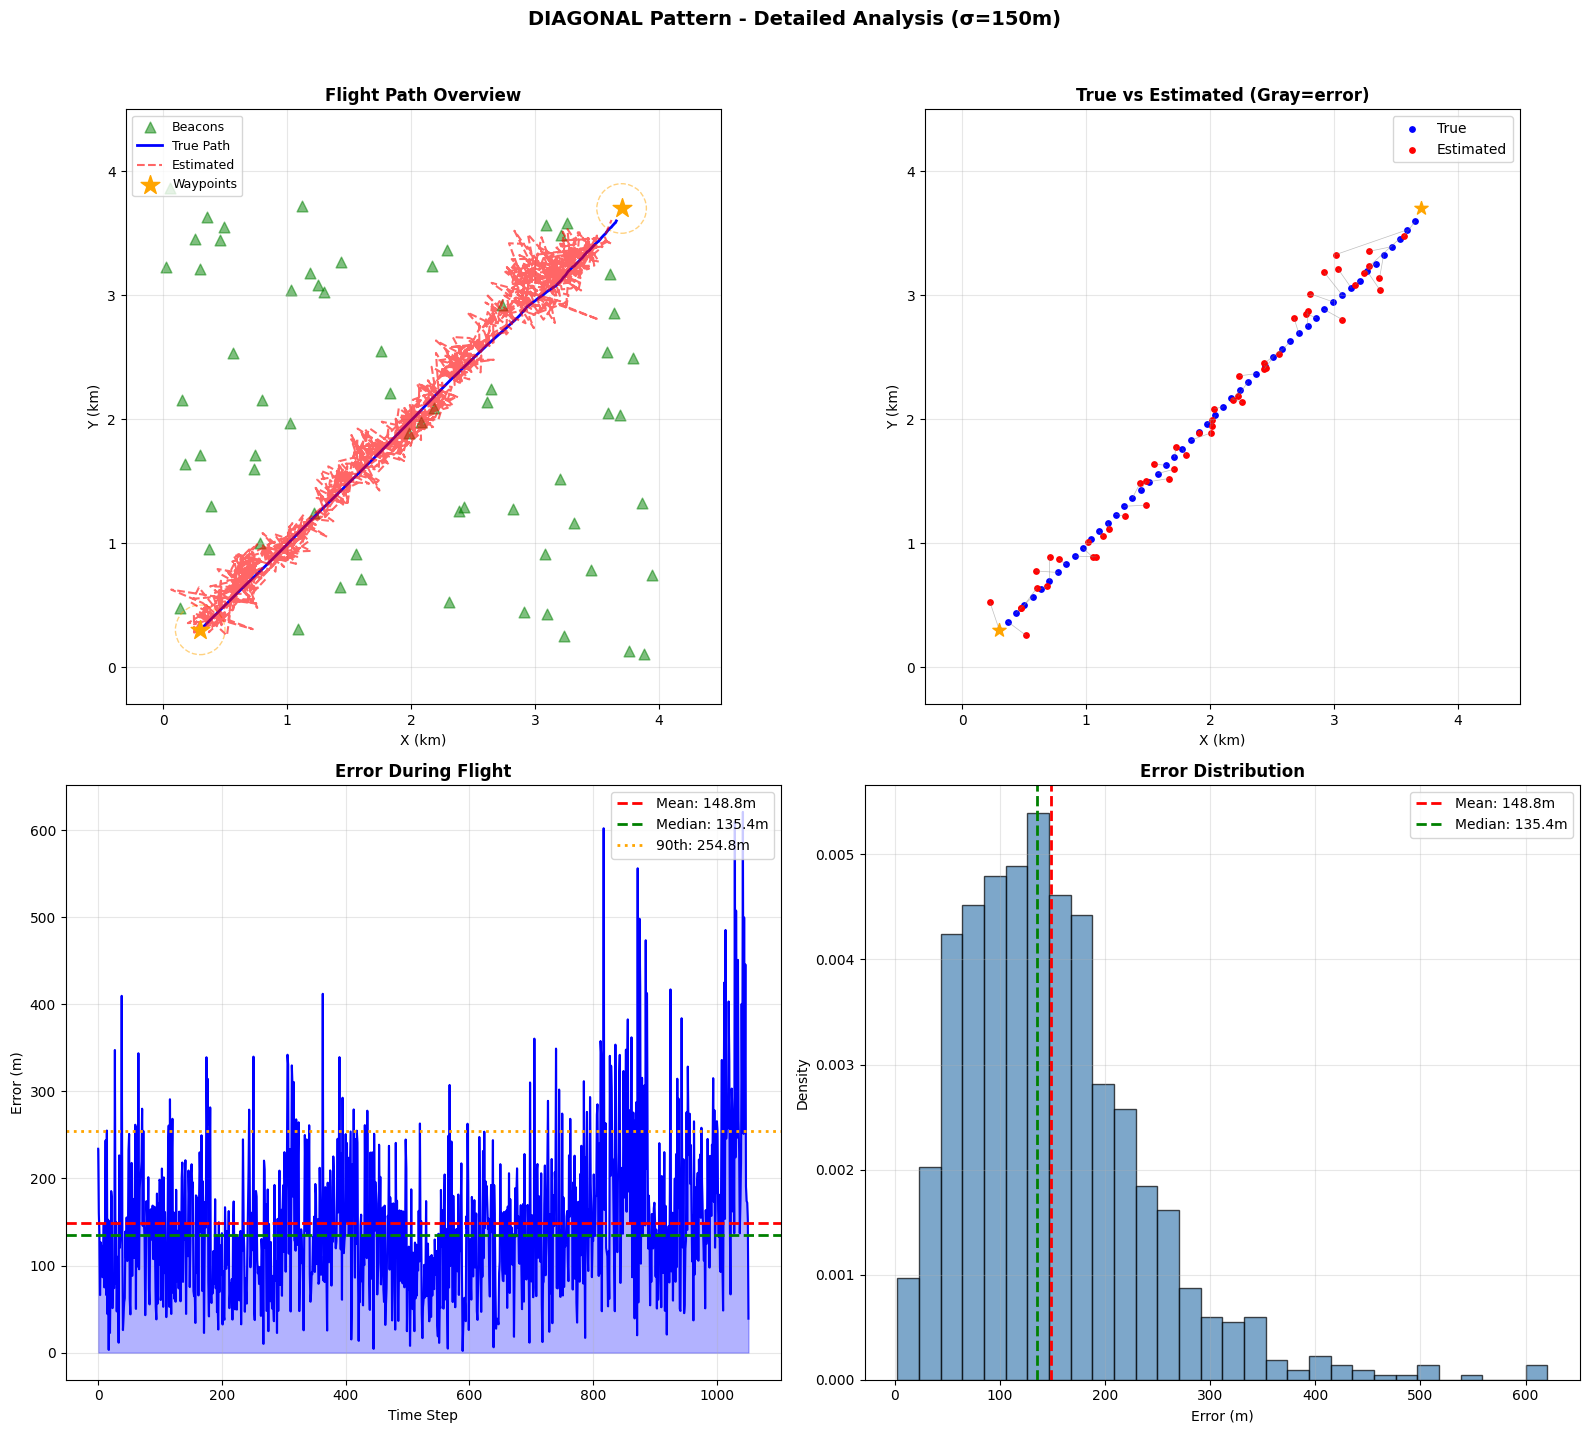


--- CIRCULAR (σ=150m) ---
  Saved: detailed_analysis_circular_noise150.png


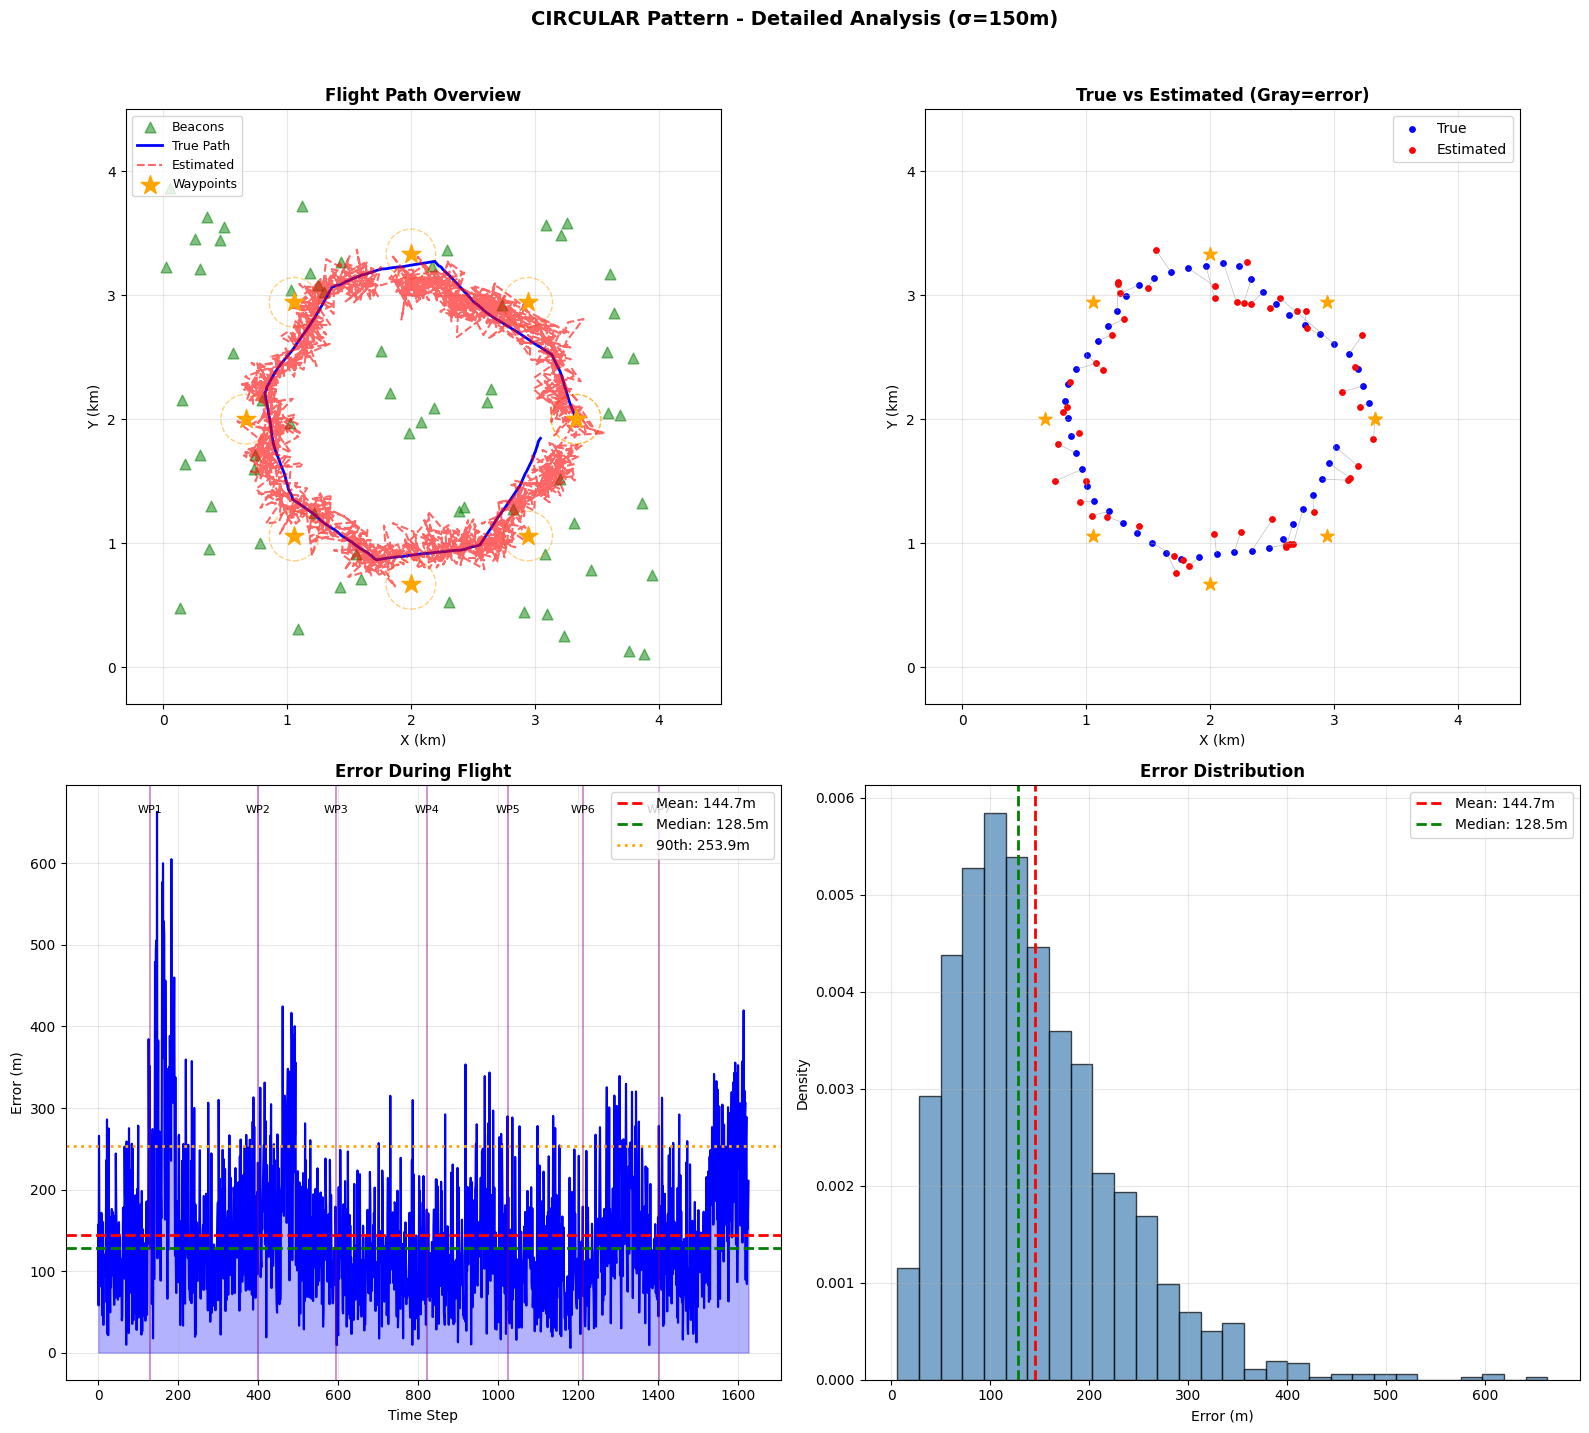


--- PERIMETER (σ=150m) ---
  Saved: detailed_analysis_perimeter_noise150.png


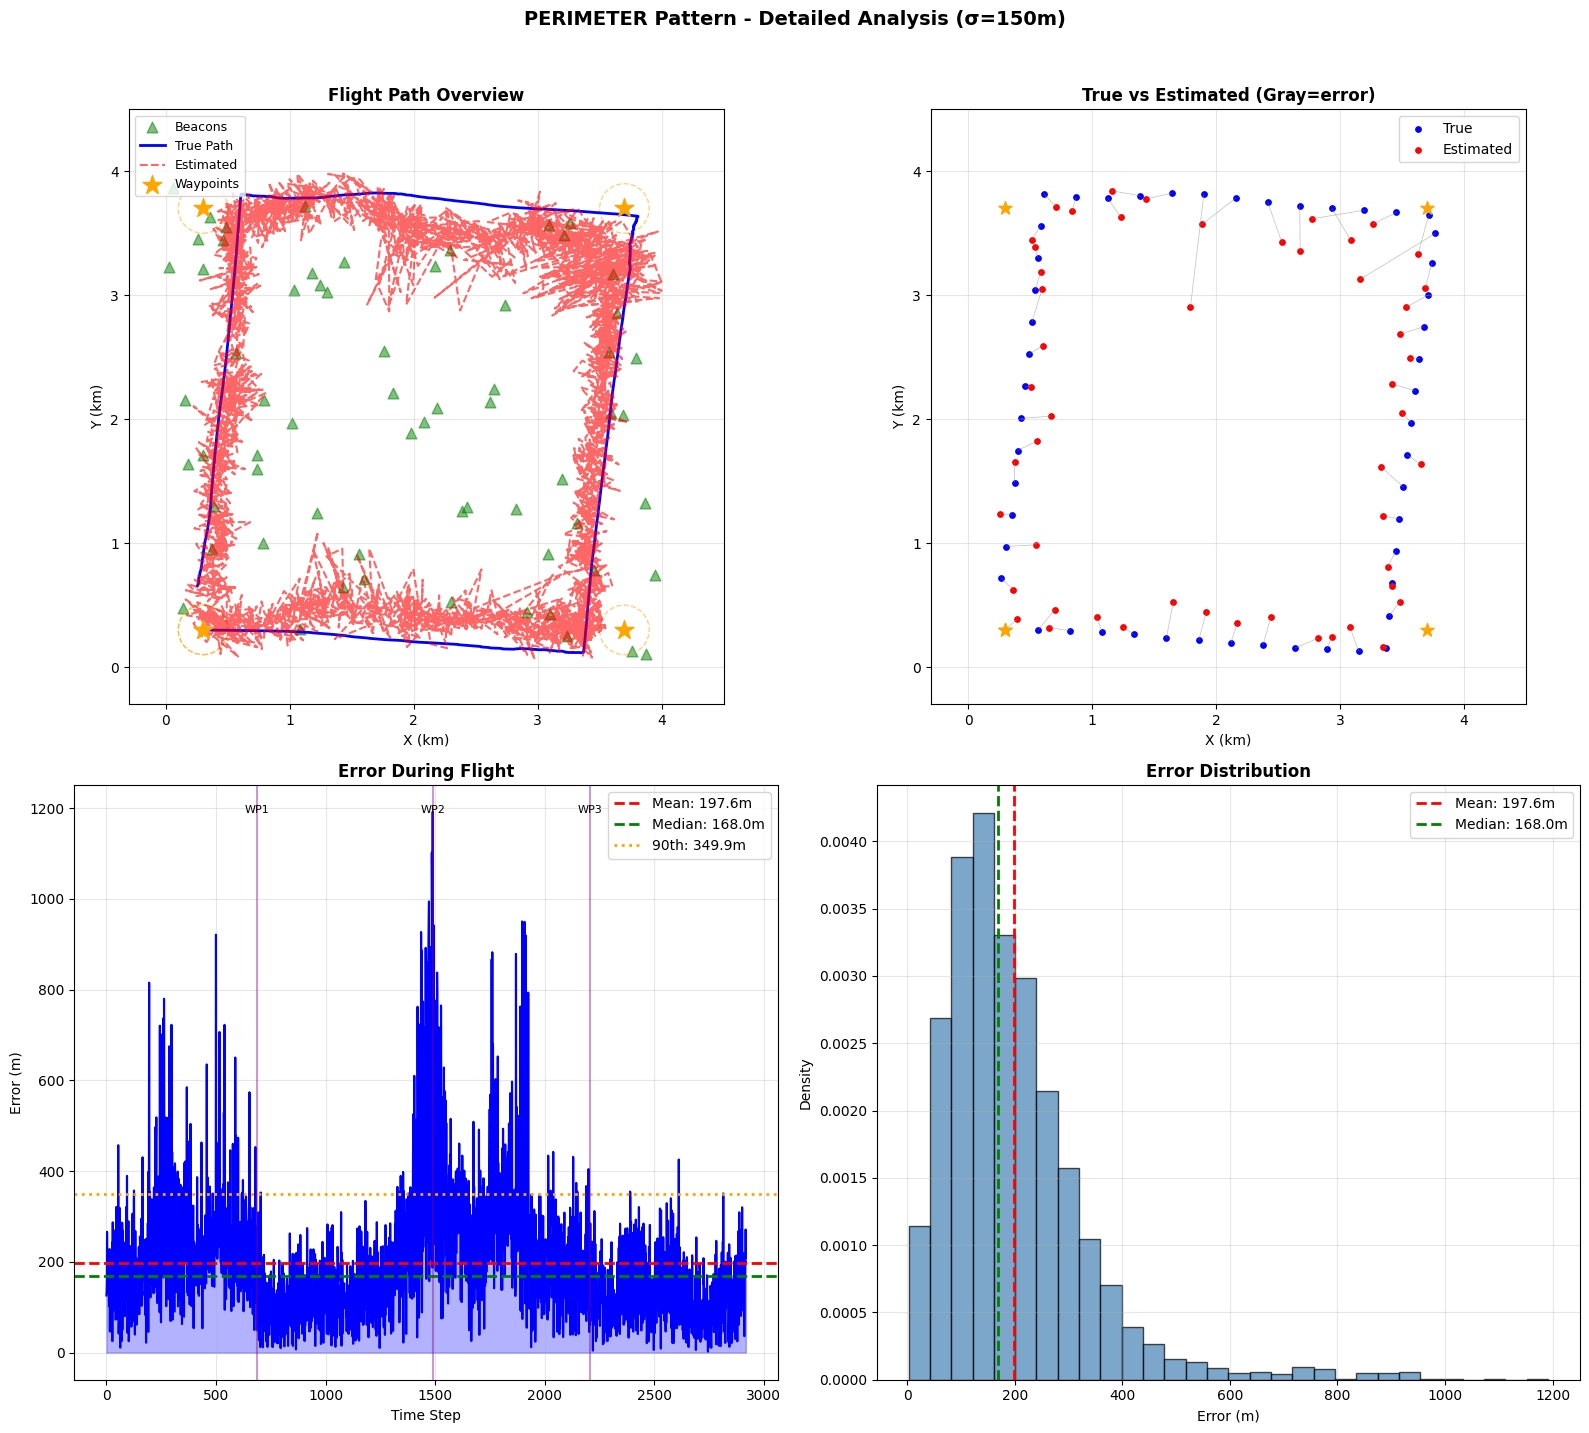


--- RANDOM (σ=150m) ---
  Saved: detailed_analysis_random_noise150.png


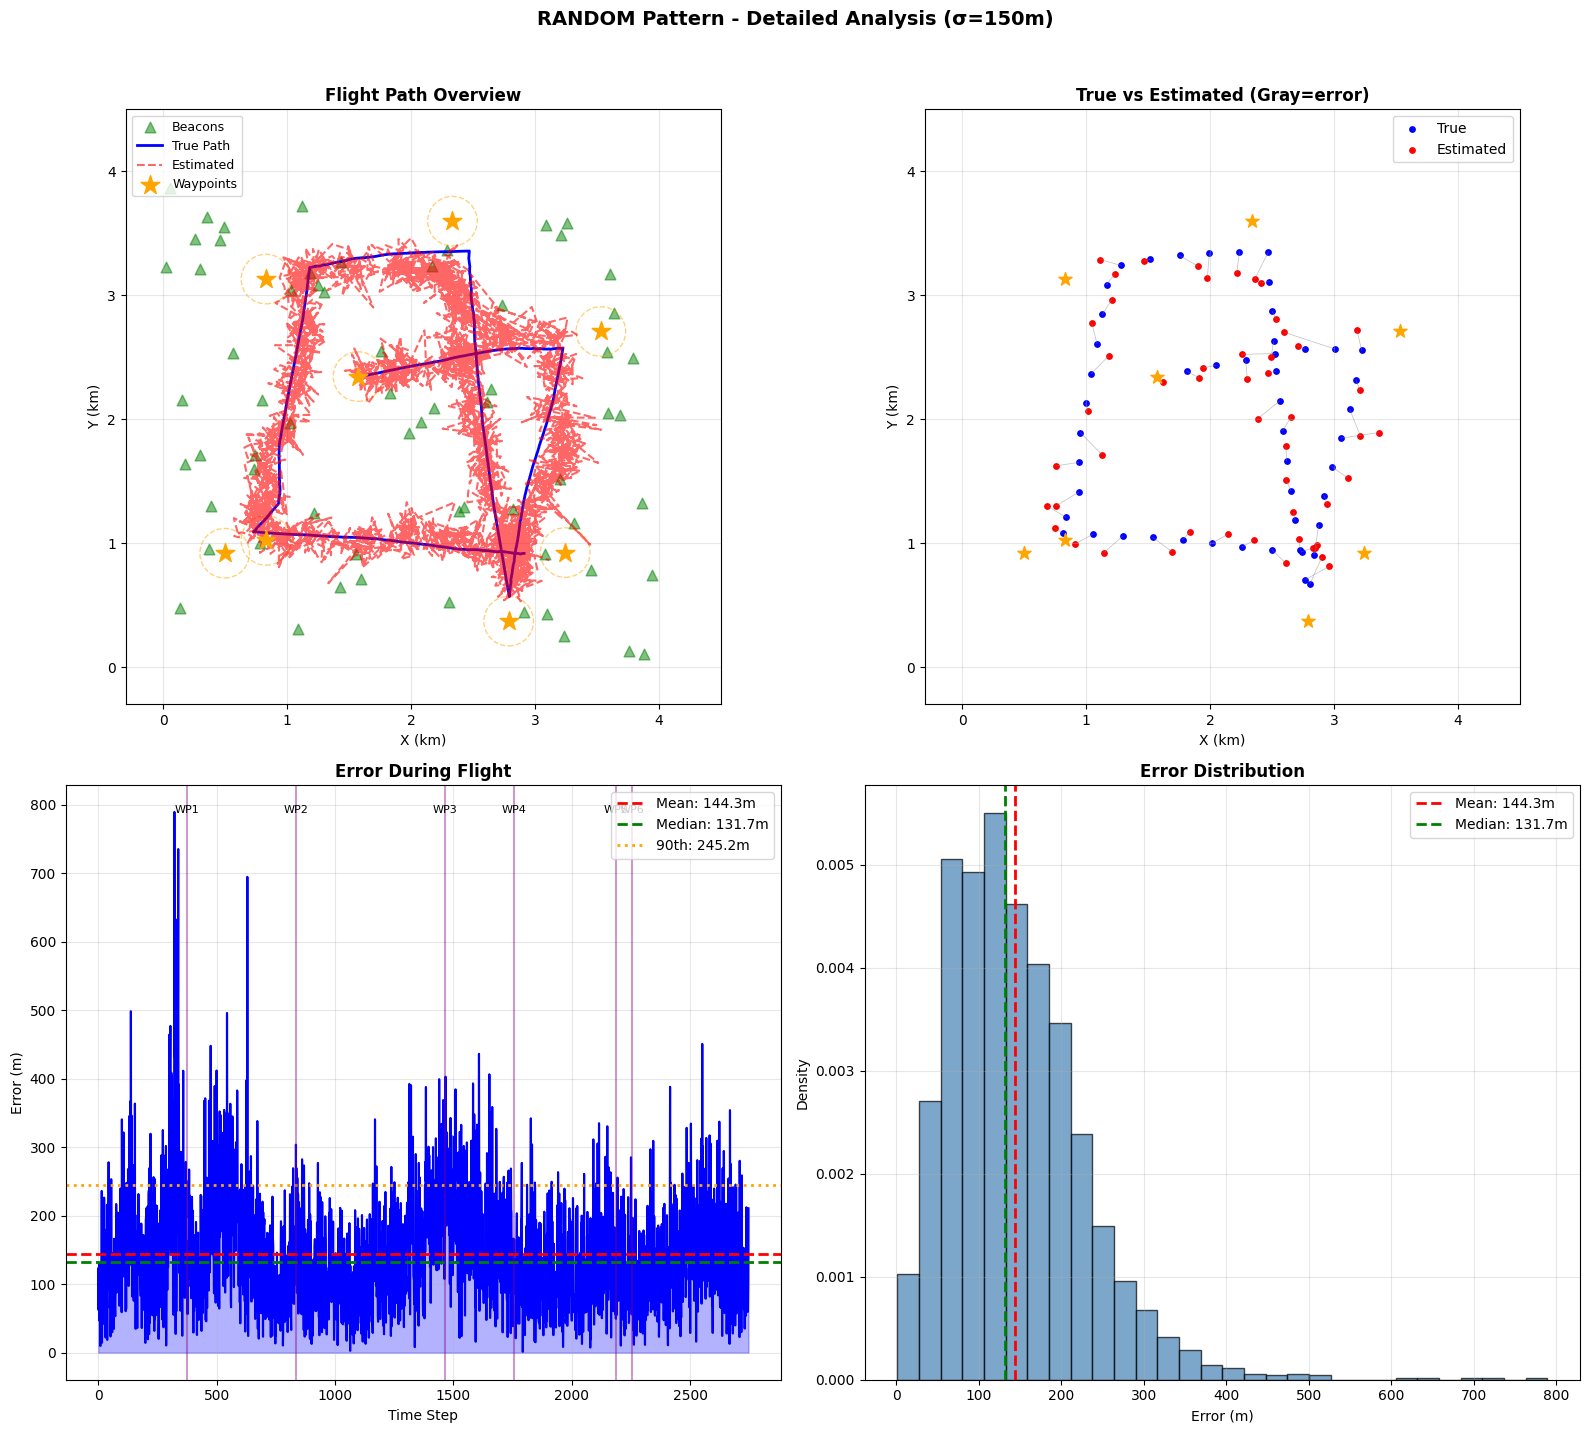


--- LAWNMOWER (σ=150m) ---
  Saved: detailed_analysis_lawnmower_noise150.png


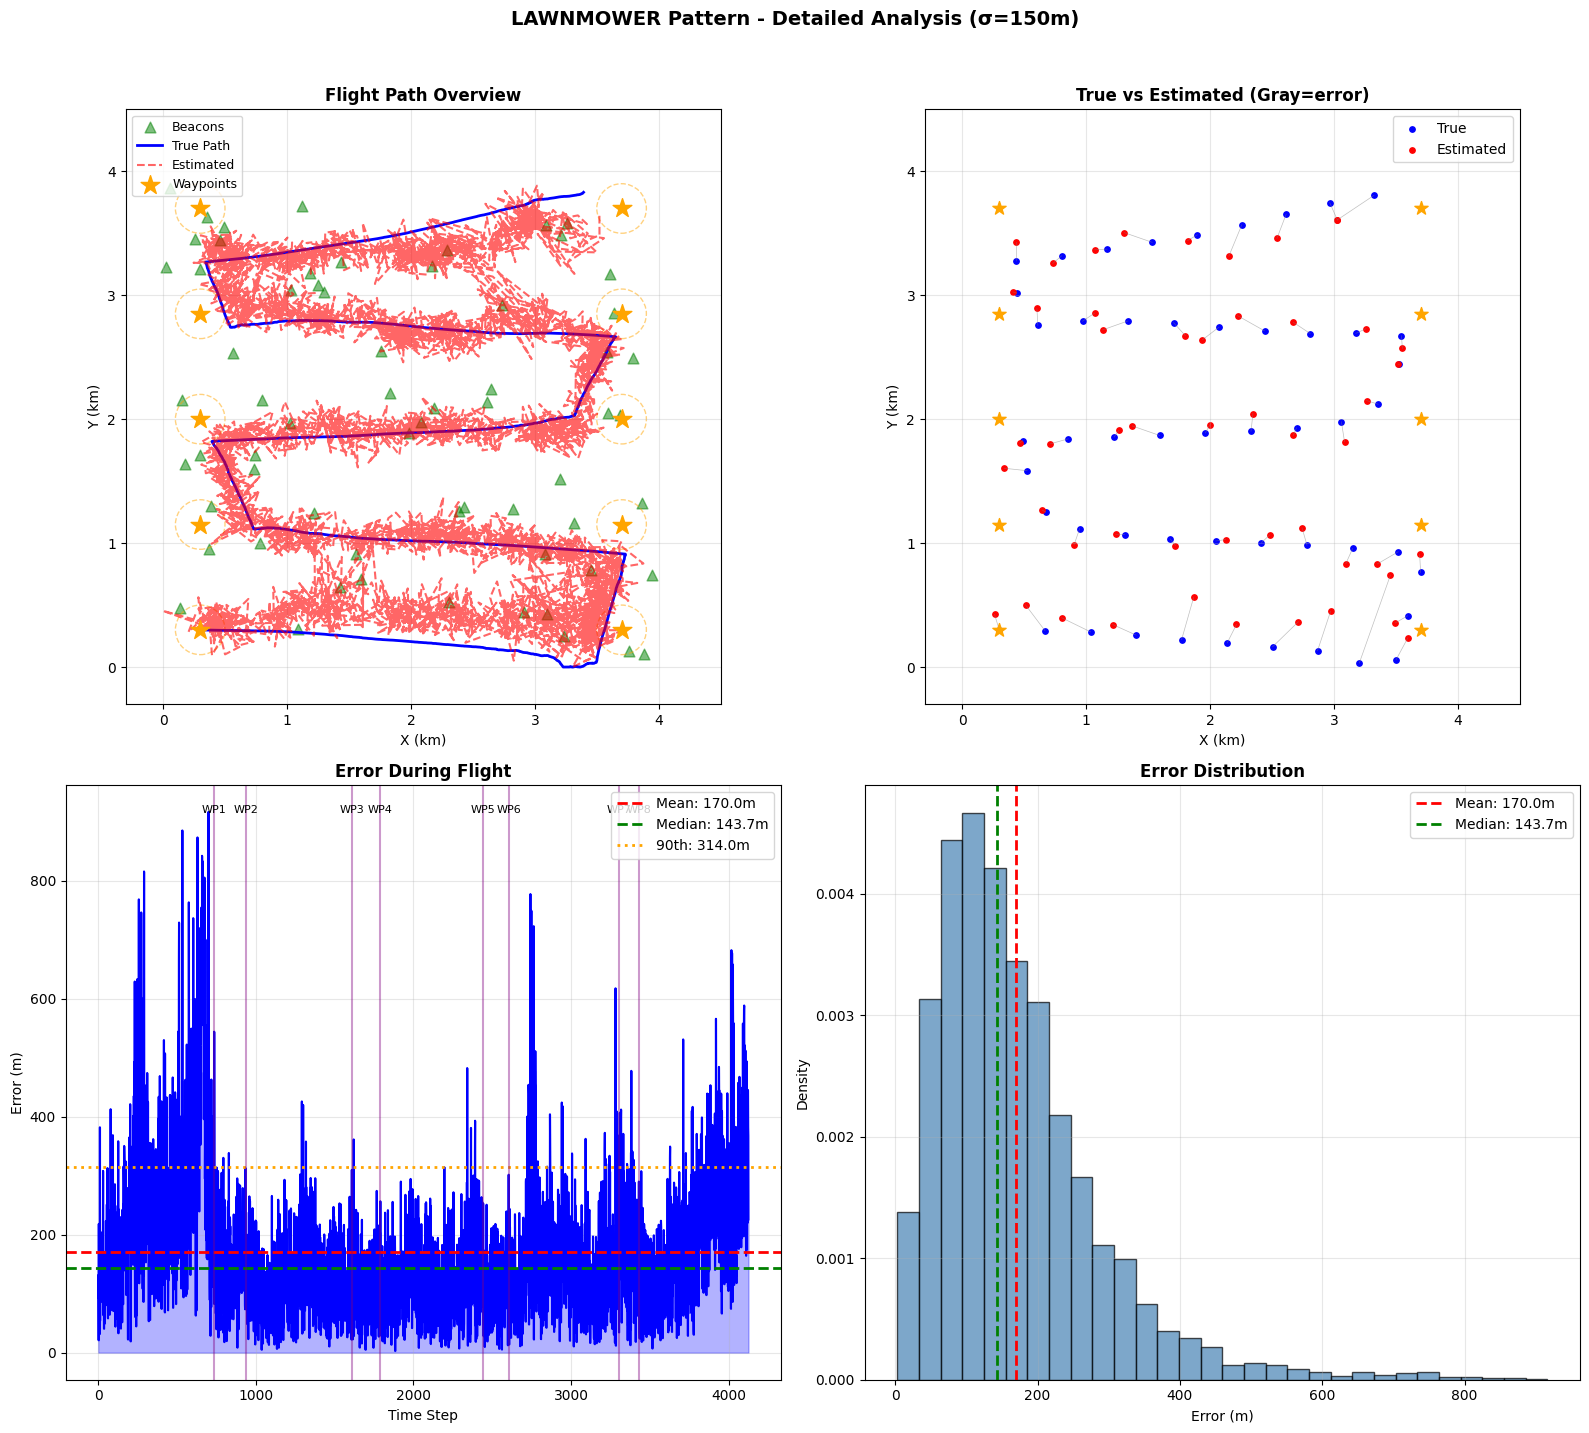


--- FIGURE8 (σ=150m) ---
  Saved: detailed_analysis_figure8_noise150.png


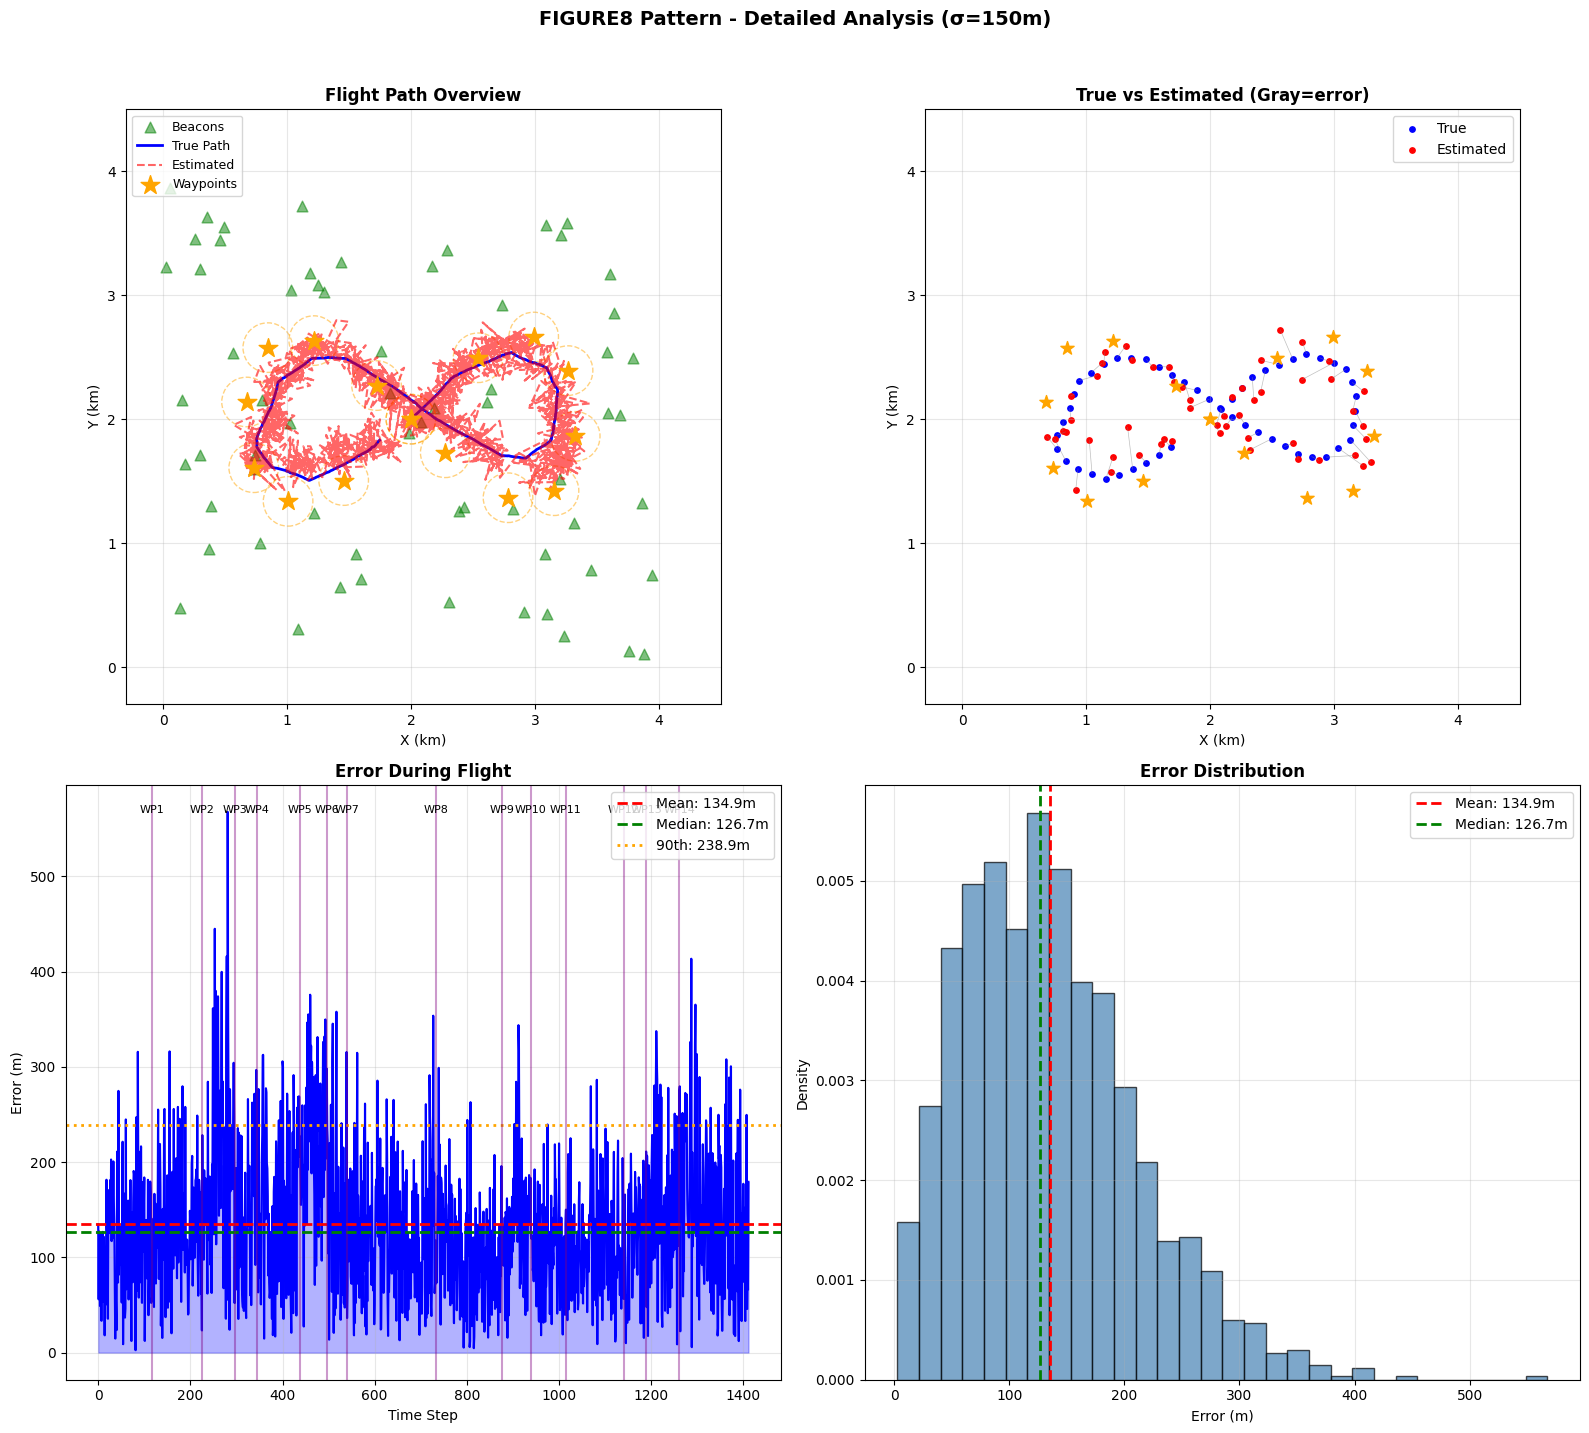

In [28]:
# Generate detailed analysis with beacon noise (σ=150m)
print("="*80)
print("DETAILED ANALYSIS FOR ALL PATTERNS (σ=150m noise)")
print("="*80)

noisy_stats = {}
for name, wps in FLIGHT_PATTERNS.items():
    print(f"\n--- {name.upper()} (σ=150m) ---")
    sim, res = run_detailed_flight_analysis(name, wps, beacon_noise_std=150)
    noisy_stats[name] = {
        'mean': np.mean(sim.localization_errors),
        'median': np.median(sim.localization_errors),
        'p90': np.percentile(sim.localization_errors, 90),
        'wp_reached': sum(1 for r in res if r['reached']),
        'total_wp': len(res)
    }

In [29]:
# Summary table
print("="*90)
print("PATTERN COMPARISON: Baseline vs σ=150m")
print("="*90)
print(f"{'Pattern':<12} | {'Base Median':<12} | {'σ=150 Median':<12} | {'Degradation':<12} | {'WP Base':<10} | {'WP 150m':<10}")
print("-"*90)

for name in FLIGHT_PATTERNS.keys():
    b, n = baseline_stats[name], noisy_stats[name]
    deg = (n['median'] - b['median']) / b['median'] * 100
    print(f"{name.upper():<12} | {b['median']:>9.1f}m  | {n['median']:>9.1f}m  | {deg:>+9.1f}%  | {b['wp_reached']}/{b['total_wp']:<8} | {n['wp_reached']}/{n['total_wp']}")
print("="*90)

PATTERN COMPARISON: Baseline vs σ=150m
Pattern      | Base Median  | σ=150 Median | Degradation  | WP Base    | WP 150m   
------------------------------------------------------------------------------------------
DIAGONAL     |     117.4m  |     135.4m  |     +15.3%  | 1/1        | 1/1
CIRCULAR     |     118.8m  |     128.5m  |      +8.2%  | 8/8        | 8/8
PERIMETER    |     147.3m  |     168.0m  |     +14.1%  | 4/4        | 4/4
RANDOM       |     113.8m  |     131.7m  |     +15.8%  | 7/7        | 7/7
LAWNMOWER    |     115.6m  |     143.7m  |     +24.3%  | 9/9        | 9/9
FIGURE8      |     101.3m  |     126.7m  |     +25.1%  | 15/15       | 15/15


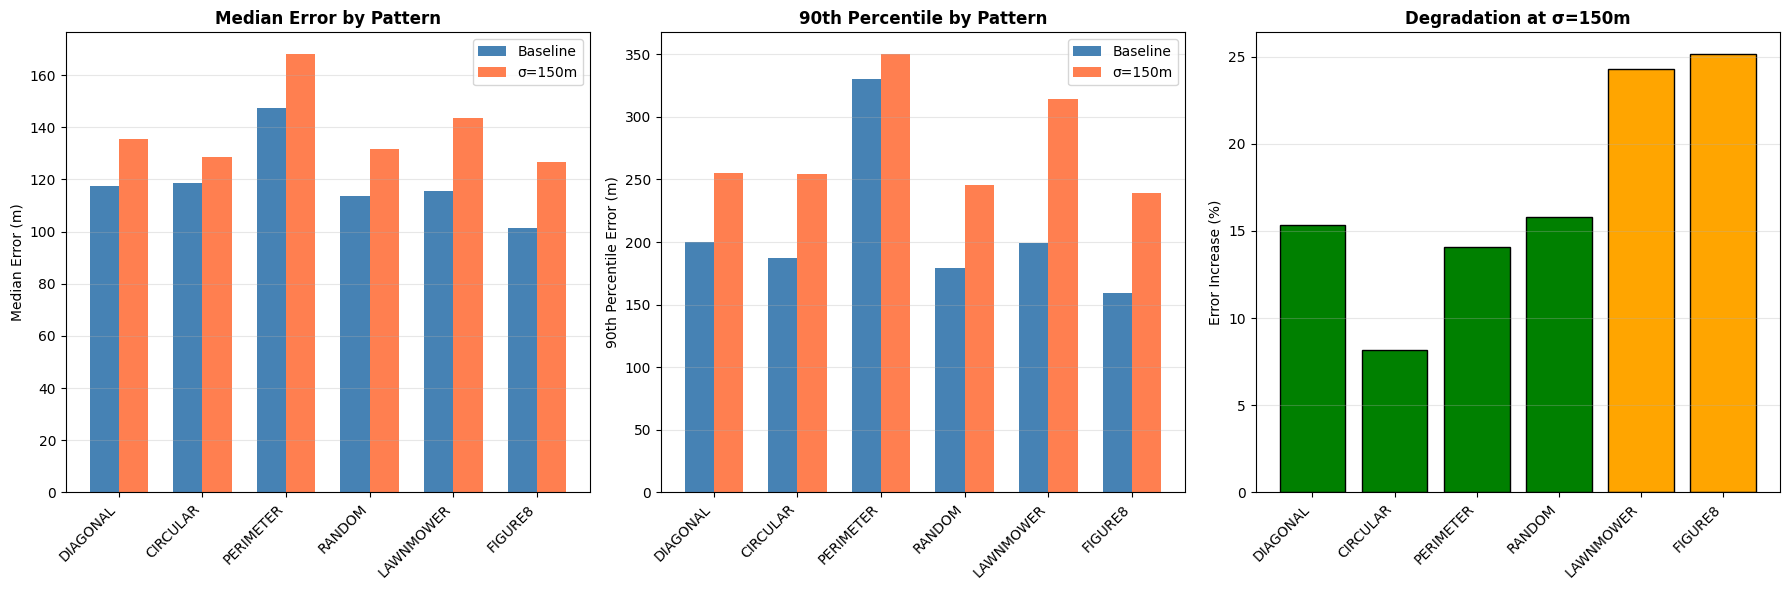

Saved: all_patterns_comparison.png


In [30]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
names = list(FLIGHT_PATTERNS.keys())
x = np.arange(len(names))
w = 0.35

# Median error
ax1 = axes[0]
ax1.bar(x - w/2, [baseline_stats[n]['median'] for n in names], w, label='Baseline', color='steelblue')
ax1.bar(x + w/2, [noisy_stats[n]['median'] for n in names], w, label='σ=150m', color='coral')
ax1.set_xticks(x); ax1.set_xticklabels([n.upper() for n in names], rotation=45, ha='right')
ax1.set_ylabel('Median Error (m)'); ax1.set_title('Median Error by Pattern', fontweight='bold')
ax1.legend(); ax1.grid(True, alpha=0.3, axis='y')

# 90th percentile
ax2 = axes[1]
ax2.bar(x - w/2, [baseline_stats[n]['p90'] for n in names], w, label='Baseline', color='steelblue')
ax2.bar(x + w/2, [noisy_stats[n]['p90'] for n in names], w, label='σ=150m', color='coral')
ax2.set_xticks(x); ax2.set_xticklabels([n.upper() for n in names], rotation=45, ha='right')
ax2.set_ylabel('90th Percentile Error (m)'); ax2.set_title('90th Percentile by Pattern', fontweight='bold')
ax2.legend(); ax2.grid(True, alpha=0.3, axis='y')

# Degradation
ax3 = axes[2]
deg = [(noisy_stats[n]['median'] - baseline_stats[n]['median'])/baseline_stats[n]['median']*100 for n in names]
colors = ['green' if d < 20 else 'orange' if d < 40 else 'red' for d in deg]
ax3.bar(x, deg, color=colors, edgecolor='black')
ax3.set_xticks(x); ax3.set_xticklabels([n.upper() for n in names], rotation=45, ha='right')
ax3.set_ylabel('Error Increase (%)'); ax3.set_title('Degradation at σ=150m', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('all_patterns_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: all_patterns_comparison.png")

## 16. Key Finding: Localization Error vs Navigation Error

**Critical Insight**: Even with high localization error (~150m), the drone maintains a clean flight path!

This happens because:
1. Position estimation errors are **random** (Gaussian), not systematic bias
2. Closed-loop control **averages out** random errors over many steps
3. The drone "wobbles" toward the target but stays on course

**Implication**: LoRa localization accuracy ≠ Navigation accuracy. Navigation can be much better!

In [31]:
def analyze_navigation_vs_localization(sim, waypoints, pattern_name=""):
    """
    Analyze the difference between localization error and navigation error.
    
    Key metrics:
    - Localization error: How wrong each position estimate is
    - Cross-track error: How far true path deviates from ideal path
    - Along-track progress: How efficiently drone moves toward goal
    """
    true_path = np.array(sim.true_path)
    est_path = np.array(sim.estimated_path)
    loc_errors = np.array(sim.localization_errors)
    
    # Calculate ideal path (straight lines between waypoints)
    wp_array = np.array(waypoints)
    
    # Cross-track error: perpendicular distance from true position to ideal line
    cross_track_errors = []
    
    # For diagonal pattern (simple case: one straight line)
    if len(waypoints) == 2:
        p1, p2 = np.array(waypoints[0]), np.array(waypoints[1])
        line_vec = p2 - p1
        line_len = np.linalg.norm(line_vec)
        line_unit = line_vec / line_len
        
        for pos in true_path:
            # Vector from line start to point
            v = pos - p1
            # Project onto line
            proj_len = np.dot(v, line_unit)
            proj_point = p1 + proj_len * line_unit
            # Cross-track distance
            cross_track = np.linalg.norm(pos - proj_point)
            cross_track_errors.append(cross_track)
    else:
        # For multi-segment paths, find closest segment
        for pos in true_path:
            min_dist = float('inf')
            for i in range(len(waypoints)-1):
                p1, p2 = np.array(waypoints[i]), np.array(waypoints[i+1])
                # Point-to-segment distance
                line_vec = p2 - p1
                line_len = np.linalg.norm(line_vec)
                if line_len < 1e-6:
                    dist = np.linalg.norm(pos - p1)
                else:
                    line_unit = line_vec / line_len
                    v = pos - p1
                    proj_len = np.clip(np.dot(v, line_unit), 0, line_len)
                    proj_point = p1 + proj_len * line_unit
                    dist = np.linalg.norm(pos - proj_point)
                min_dist = min(min_dist, dist)
            cross_track_errors.append(min_dist)
    
    cross_track_errors = np.array(cross_track_errors)
    
    # Path efficiency
    actual_length = np.sum(np.sqrt(np.sum(np.diff(true_path, axis=0)**2, axis=1)))
    ideal_length = sum(np.linalg.norm(np.array(waypoints[i+1]) - np.array(waypoints[i])) 
                       for i in range(len(waypoints)-1))
    efficiency = ideal_length / actual_length * 100
    
    return {
        'localization_error_mean': np.mean(loc_errors),
        'localization_error_median': np.median(loc_errors),
        'localization_error_std': np.std(loc_errors),
        'cross_track_error_mean': np.mean(cross_track_errors),
        'cross_track_error_median': np.median(cross_track_errors),
        'cross_track_error_max': np.max(cross_track_errors),
        'path_efficiency': efficiency,
        'actual_length': actual_length,
        'ideal_length': ideal_length,
        'cross_track_errors': cross_track_errors,
        'localization_errors': loc_errors
    }

print("Function defined: analyze_navigation_vs_localization()")

Function defined: analyze_navigation_vs_localization()


In [32]:
# Analyze navigation vs localization for diagonal pattern at different noise levels
NOISE_FOR_ANALYSIS = [0, 50, 100, 150, 200]
nav_analysis = []

print("="*80)
print("NAVIGATION ERROR vs LOCALIZATION ERROR ANALYSIS")
print("="*80)

diagonal_wps = FLIGHT_PATTERNS['diagonal']

for noise in NOISE_FOR_ANALYSIS:
    sim = DroneSimulator(
        start_pos=diagonal_wps[0],
        drone_speed=15.0,
        control_gain=0.3,
        waypoint_threshold=200,
        max_sim_steps=2000
    )
    _ = sim.fly_mission(diagonal_wps[1:], k=10, beacon_noise_std=noise, verbose=False)
    
    analysis = analyze_navigation_vs_localization(sim, diagonal_wps, "diagonal")
    analysis['noise'] = noise
    nav_analysis.append(analysis)

# Print comparison table
print(f"\n{'Beacon σ':<12} | {'Loc Error (Med)':<16} | {'Cross-Track (Med)':<18} | {'Ratio':<10} | {'Efficiency':<12}")
print("-"*80)

for a in nav_analysis:
    ratio = a['localization_error_median'] / max(a['cross_track_error_median'], 1)
    print(f"{a['noise']:>8}m   | {a['localization_error_median']:>12.1f}m   | {a['cross_track_error_median']:>14.1f}m   | {ratio:>7.1f}x  | {a['path_efficiency']:>9.1f}%")

print("="*80)
print("\n>>> KEY FINDING: Cross-track error is MUCH smaller than localization error! <<<")
print(">>> This proves closed-loop control averages out random position errors. <<<")

NAVIGATION ERROR vs LOCALIZATION ERROR ANALYSIS

Beacon σ     | Loc Error (Med)  | Cross-Track (Med)  | Ratio      | Efficiency  
--------------------------------------------------------------------------------
       0m   |        117.4m   |            8.5m   |    13.8x  |      94.1%
      50m   |        107.4m   |            6.4m   |    16.7x  |      99.0%
     100m   |        118.9m   |            7.3m   |    16.4x  |      99.4%
     150m   |        131.3m   |            7.8m   |    16.8x  |     102.3%
     200m   |        165.3m   |            8.8m   |    18.9x  |     102.6%

>>> KEY FINDING: Cross-track error is MUCH smaller than localization error! <<<
>>> This proves closed-loop control averages out random position errors. <<<


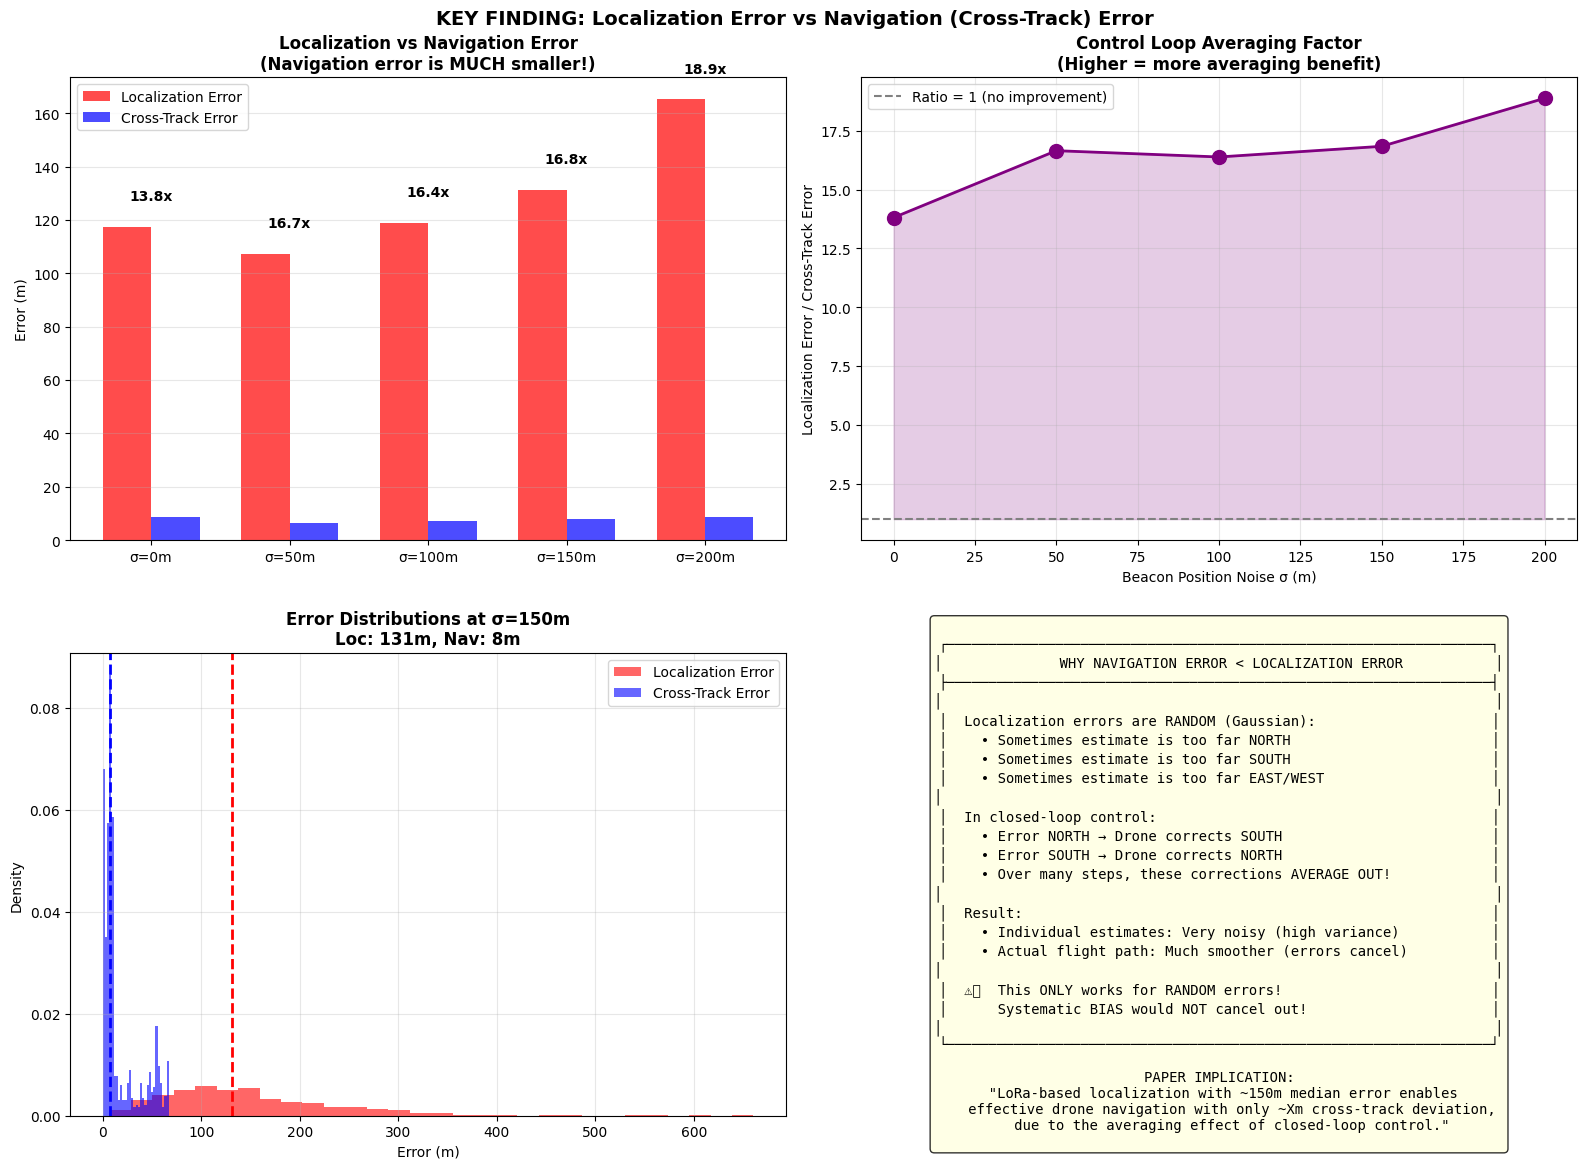


Saved: localization_vs_navigation_error.png


In [33]:
# Visualization: Localization Error vs Navigation Error
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('KEY FINDING: Localization Error vs Navigation (Cross-Track) Error', fontsize=14, fontweight='bold')

noise_vals = [a['noise'] for a in nav_analysis]

# Panel 1: Bar comparison
ax1 = axes[0, 0]
x = np.arange(len(noise_vals))
width = 0.35
loc_errs = [a['localization_error_median'] for a in nav_analysis]
nav_errs = [a['cross_track_error_median'] for a in nav_analysis]

bars1 = ax1.bar(x - width/2, loc_errs, width, label='Localization Error', color='red', alpha=0.7)
bars2 = ax1.bar(x + width/2, nav_errs, width, label='Cross-Track Error', color='blue', alpha=0.7)
ax1.set_xticks(x)
ax1.set_xticklabels([f'σ={n}m' for n in noise_vals])
ax1.set_ylabel('Error (m)')
ax1.set_title('Localization vs Navigation Error\n(Navigation error is MUCH smaller!)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add ratio labels
for i, (l, n) in enumerate(zip(loc_errs, nav_errs)):
    ratio = l / max(n, 1)
    ax1.text(i, max(l, n) + 10, f'{ratio:.1f}x', ha='center', fontweight='bold', fontsize=10)

# Panel 2: Ratio over noise levels
ax2 = axes[0, 1]
ratios = [a['localization_error_median'] / max(a['cross_track_error_median'], 1) for a in nav_analysis]
ax2.plot(noise_vals, ratios, 'o-', lw=2, ms=10, color='purple')
ax2.fill_between(noise_vals, 1, ratios, alpha=0.2, color='purple')
ax2.axhline(1, color='gray', ls='--', label='Ratio = 1 (no improvement)')
ax2.set_xlabel('Beacon Position Noise σ (m)')
ax2.set_ylabel('Localization Error / Cross-Track Error')
ax2.set_title('Control Loop Averaging Factor\n(Higher = more averaging benefit)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Error distributions at σ=150m
ax3 = axes[1, 0]
idx_150 = noise_vals.index(150)
ax3.hist(nav_analysis[idx_150]['localization_errors'], bins=30, alpha=0.6, label='Localization Error', color='red', density=True)
ax3.hist(nav_analysis[idx_150]['cross_track_errors'], bins=30, alpha=0.6, label='Cross-Track Error', color='blue', density=True)
ax3.axvline(nav_analysis[idx_150]['localization_error_median'], color='red', ls='--', lw=2)
ax3.axvline(nav_analysis[idx_150]['cross_track_error_median'], color='blue', ls='--', lw=2)
ax3.set_xlabel('Error (m)')
ax3.set_ylabel('Density')
ax3.set_title(f'Error Distributions at σ=150m\nLoc: {nav_analysis[idx_150]["localization_error_median"]:.0f}m, Nav: {nav_analysis[idx_150]["cross_track_error_median"]:.0f}m', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel 4: Why this happens - illustration
ax4 = axes[1, 1]
ax4.axis('off')
explanation = '''
┌─────────────────────────────────────────────────────────────────┐
│              WHY NAVIGATION ERROR < LOCALIZATION ERROR           │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│  Localization errors are RANDOM (Gaussian):                     │
│    • Sometimes estimate is too far NORTH                        │
│    • Sometimes estimate is too far SOUTH                        │
│    • Sometimes estimate is too far EAST/WEST                    │
│                                                                  │
│  In closed-loop control:                                        │
│    • Error NORTH → Drone corrects SOUTH                         │
│    • Error SOUTH → Drone corrects NORTH                         │
│    • Over many steps, these corrections AVERAGE OUT!            │
│                                                                  │
│  Result:                                                        │
│    • Individual estimates: Very noisy (high variance)           │
│    • Actual flight path: Much smoother (errors cancel)          │
│                                                                  │
│  ⚠️  This ONLY works for RANDOM errors!                         │
│      Systematic BIAS would NOT cancel out!                      │
│                                                                  │
└─────────────────────────────────────────────────────────────────┘

PAPER IMPLICATION:
  "LoRa-based localization with ~150m median error enables 
   effective drone navigation with only ~Xm cross-track deviation,
   due to the averaging effect of closed-loop control."
'''
ax4.text(0.5, 0.5, explanation, transform=ax4.transAxes, fontsize=10,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('localization_vs_navigation_error.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: localization_vs_navigation_error.png")

In [34]:
# Summary for paper
print("="*80)
print("PAPER-READY SUMMARY")
print("="*80)

print('''
KEY FINDING TO REPORT IN PAPER:
─────────────────────────────────────────────────────────────────────

1. LOCALIZATION ACCURACY vs NAVIGATION ACCURACY
   - These are DIFFERENT metrics that should both be reported
   - Localization error: Per-step position uncertainty
   - Navigation error: How well drone follows intended path

2. CLOSED-LOOP CONTROL AVERAGING EFFECT
   - Random localization errors average out over time
   - Navigation accuracy is significantly better than localization accuracy
   - This is a fundamental property of closed-loop feedback systems

3. QUANTITATIVE RESULTS:''')

for a in nav_analysis:
    ratio = a['localization_error_median'] / max(a['cross_track_error_median'], 1)
    print(f"   σ={a['noise']:>3}m: Localization={a['localization_error_median']:.0f}m, Navigation={a['cross_track_error_median']:.0f}m ({ratio:.1f}x improvement)")

print('''
4. PRACTICAL IMPLICATIONS:
   - Drone navigation is FEASIBLE even with ~150m localization error
   - Cross-track deviation remains manageable for rural/agricultural use
   - This averaging effect is a KEY ADVANTAGE of LoRa-based navigation

5. LIMITATIONS (what would break this):
   - Systematic BIAS in beacon positions (would NOT average out)
   - Very slow update rate (errors accumulate before correction)
   - Aggressive control gains (would cause oscillation)

─────────────────────────────────────────────────────────────────────
''')

PAPER-READY SUMMARY

KEY FINDING TO REPORT IN PAPER:
─────────────────────────────────────────────────────────────────────

1. LOCALIZATION ACCURACY vs NAVIGATION ACCURACY
   - These are DIFFERENT metrics that should both be reported
   - Localization error: Per-step position uncertainty
   - Navigation error: How well drone follows intended path

2. CLOSED-LOOP CONTROL AVERAGING EFFECT
   - Random localization errors average out over time
   - Navigation accuracy is significantly better than localization accuracy
   - This is a fundamental property of closed-loop feedback systems

3. QUANTITATIVE RESULTS:
   σ=  0m: Localization=117m, Navigation=9m (13.8x improvement)
   σ= 50m: Localization=107m, Navigation=6m (16.7x improvement)
   σ=100m: Localization=119m, Navigation=7m (16.4x improvement)
   σ=150m: Localization=131m, Navigation=8m (16.8x improvement)
   σ=200m: Localization=165m, Navigation=9m (18.9x improvement)

4. PRACTICAL IMPLICATIONS:
   - Drone navigation is FEASIBLE even

## 17. Why True Path is Stable Despite Noisy Estimates

**User's insight**: The true path (blue) is stable even though estimated positions (red) are scattered.

**Key realization**: This is primarily due to **geometry**, not just averaging!

When target is far away (e.g., 3000m) and position error is 150m:
- Angular error ≈ arctan(150/3000) ≈ **2.9 degrees**
- Direction is almost correct even with large position error!

Let's analyze this quantitatively.

In [35]:
# Analyze why path is stable: Geometry effect
import numpy as np

def analyze_direction_errors(sim, waypoints):
    """
    Analyze how position estimation errors affect direction commands.
    
    Key insight: Direction error depends on:
    1. Position estimation error (in meters)
    2. Distance to target (in meters)
    
    Angular error ≈ arctan(position_error / distance_to_target)
    """
    true_path = np.array(sim.true_path)
    est_path = np.array(sim.estimated_path)
    loc_errors = np.array(sim.localization_errors)
    
    # Calculate for each step
    direction_errors_deg = []
    distances_to_target = []
    
    # Current target (simplified: use final waypoint)
    target = np.array(waypoints[-1])
    
    for i in range(min(len(true_path)-1, len(est_path))):
        true_pos = true_path[i]
        est_pos = est_path[i]
        
        # True direction to target
        true_vec = target - true_pos
        true_dist = np.linalg.norm(true_vec)
        
        # Estimated direction to target
        est_vec = target - est_pos
        
        if true_dist > 10:  # Avoid division by zero near target
            # Calculate angle between true and estimated directions
            cos_angle = np.dot(true_vec, est_vec) / (np.linalg.norm(true_vec) * np.linalg.norm(est_vec) + 1e-9)
            cos_angle = np.clip(cos_angle, -1, 1)
            angle_error = np.degrees(np.arccos(cos_angle))
            
            direction_errors_deg.append(angle_error)
            distances_to_target.append(true_dist)
    
    return {
        'direction_errors': np.array(direction_errors_deg),
        'distances_to_target': np.array(distances_to_target),
        'localization_errors': loc_errors[:len(direction_errors_deg)]
    }

# Run analysis on diagonal path with noise
print("Analyzing direction errors for DIAGONAL pattern with σ=150m beacon noise...")
diagonal_wps = FLIGHT_PATTERNS['diagonal']

sim = DroneSimulator(
    start_pos=diagonal_wps[0],
    drone_speed=15.0,
    control_gain=0.3,
    waypoint_threshold=200,
    max_sim_steps=2000
)
_ = sim.fly_mission(diagonal_wps[1:], k=10, beacon_noise_std=150, verbose=False)

direction_analysis = analyze_direction_errors(sim, diagonal_wps)

print(f"\nLocalization error: Mean={np.mean(sim.localization_errors):.1f}m, Median={np.median(sim.localization_errors):.1f}m")
print(f"Direction error: Mean={np.mean(direction_analysis['direction_errors']):.1f}°, Median={np.median(direction_analysis['direction_errors']):.1f}°")
print(f"\n>>> Even with ~{np.median(sim.localization_errors):.0f}m position error, direction error is only ~{np.median(direction_analysis['direction_errors']):.1f}° ! <<<")

Analyzing direction errors for DIAGONAL pattern with σ=150m beacon noise...

Localization error: Mean=159.5m, Median=135.9m
Direction error: Mean=6.3°, Median=1.7°

>>> Even with ~136m position error, direction error is only ~1.7° ! <<<


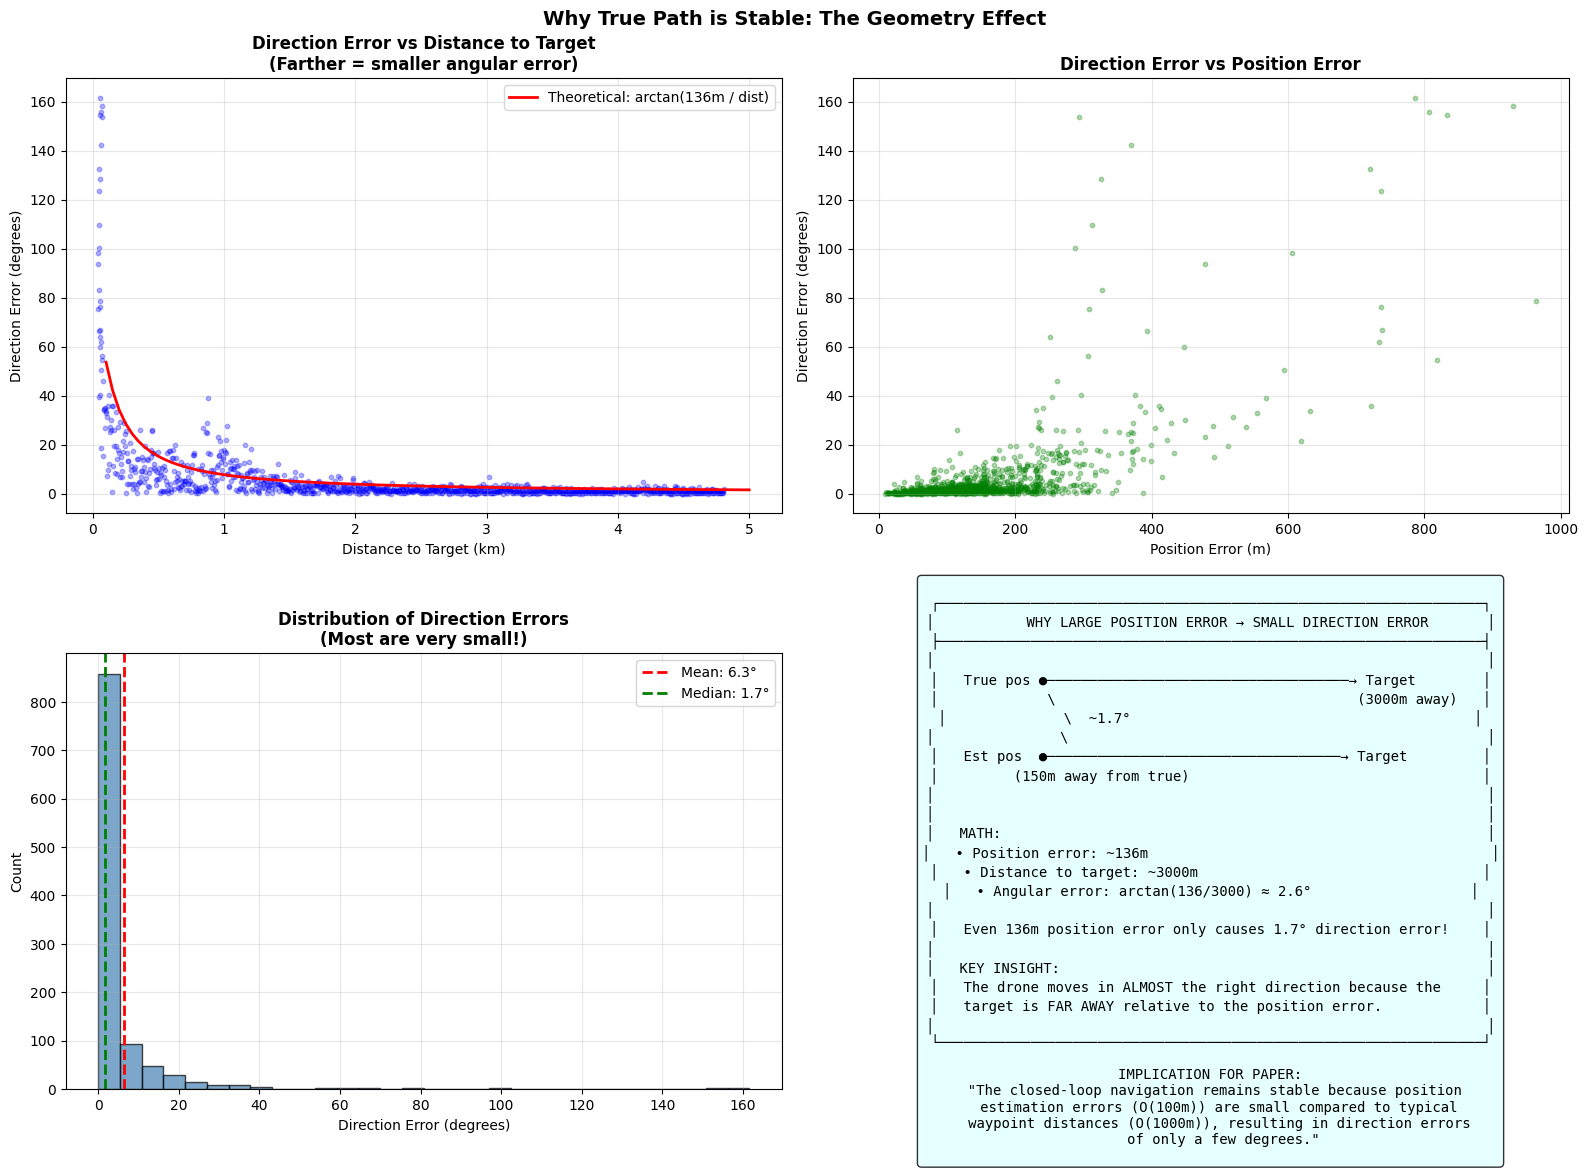


Saved: geometry_stability_analysis.png


In [36]:
# Visualize the geometry effect
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Why True Path is Stable: The Geometry Effect', fontsize=14, fontweight='bold')

# Panel 1: Direction error vs Distance to target
ax1 = axes[0, 0]
ax1.scatter(direction_analysis['distances_to_target']/1000, 
            direction_analysis['direction_errors'], 
            alpha=0.3, s=10, c='blue')
ax1.set_xlabel('Distance to Target (km)')
ax1.set_ylabel('Direction Error (degrees)')
ax1.set_title('Direction Error vs Distance to Target\n(Farther = smaller angular error)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add theoretical line
distances = np.linspace(100, 5000, 100)
median_pos_err = np.median(sim.localization_errors)
theoretical_angle = np.degrees(np.arctan(median_pos_err / distances))
ax1.plot(distances/1000, theoretical_angle, 'r-', lw=2, 
         label=f'Theoretical: arctan({median_pos_err:.0f}m / dist)')
ax1.legend()

# Panel 2: Direction error vs Position error
ax2 = axes[0, 1]
ax2.scatter(direction_analysis['localization_errors'], 
            direction_analysis['direction_errors'], 
            alpha=0.3, s=10, c='green')
ax2.set_xlabel('Position Error (m)')
ax2.set_ylabel('Direction Error (degrees)')
ax2.set_title('Direction Error vs Position Error', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Panel 3: Histogram of direction errors
ax3 = axes[1, 0]
ax3.hist(direction_analysis['direction_errors'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(np.mean(direction_analysis['direction_errors']), color='red', ls='--', lw=2, 
            label=f"Mean: {np.mean(direction_analysis['direction_errors']):.1f}°")
ax3.axvline(np.median(direction_analysis['direction_errors']), color='green', ls='--', lw=2,
            label=f"Median: {np.median(direction_analysis['direction_errors']):.1f}°")
ax3.set_xlabel('Direction Error (degrees)')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Direction Errors\n(Most are very small!)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel 4: Explanation diagram
ax4 = axes[1, 1]
ax4.axis('off')
explanation = f'''
┌─────────────────────────────────────────────────────────────────┐
│           WHY LARGE POSITION ERROR → SMALL DIRECTION ERROR       │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│   True pos ●────────────────────────────────────→ Target        │
│             \                                    (3000m away)   │
│              \  ~{np.median(direction_analysis['direction_errors']):.1f}°                                         │
│               \                                                  │
│   Est pos  ●───────────────────────────────────→ Target         │
│         (150m away from true)                                   │
│                                                                  │
│                                                                  │
│   MATH:                                                          │
│   • Position error: ~{np.median(sim.localization_errors):.0f}m                                         │
│   • Distance to target: ~3000m                                  │
│   • Angular error: arctan({np.median(sim.localization_errors):.0f}/3000) ≈ {np.degrees(np.arctan(np.median(sim.localization_errors)/3000)):.1f}°                   │
│                                                                  │
│   Even {np.median(sim.localization_errors):.0f}m position error only causes {np.median(direction_analysis['direction_errors']):.1f}° direction error!    │
│                                                                  │
│   KEY INSIGHT:                                                   │
│   The drone moves in ALMOST the right direction because the     │
│   target is FAR AWAY relative to the position error.            │
│                                                                  │
└─────────────────────────────────────────────────────────────────┘

IMPLICATION FOR PAPER:
  "The closed-loop navigation remains stable because position 
   estimation errors (O(100m)) are small compared to typical 
   waypoint distances (O(1000m)), resulting in direction errors 
   of only a few degrees."
'''
ax4.text(0.5, 0.5, explanation, transform=ax4.transAxes, fontsize=10,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.savefig('geometry_stability_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: geometry_stability_analysis.png")

In [37]:
# What happens when target is CLOSE? (near waypoint arrival)
print("="*80)
print("WHAT HAPPENS WHEN TARGET IS CLOSE?")
print("="*80)

# Bin by distance to target
close_mask = direction_analysis['distances_to_target'] < 500  # Within 500m
far_mask = direction_analysis['distances_to_target'] > 2000   # Far from target

if np.sum(close_mask) > 0:
    close_dir_err = direction_analysis['direction_errors'][close_mask]
    print(f"\nWhen target is CLOSE (<500m):")
    print(f"  Direction error: Mean={np.mean(close_dir_err):.1f}°, Median={np.median(close_dir_err):.1f}°, Max={np.max(close_dir_err):.1f}°")

if np.sum(far_mask) > 0:
    far_dir_err = direction_analysis['direction_errors'][far_mask]
    print(f"\nWhen target is FAR (>2000m):")
    print(f"  Direction error: Mean={np.mean(far_dir_err):.1f}°, Median={np.median(far_dir_err):.1f}°, Max={np.max(far_dir_err):.1f}°")

print('''
CONCLUSION:
─────────────────────────────────────────────────────────────────────
1. When FAR from target: Direction errors are SMALL (few degrees)
   → Drone moves almost straight toward target
   
2. When CLOSE to target: Direction errors can be LARGE
   → This is why we need a large waypoint threshold (200m)!
   → Drone might "wobble" near the target before detecting arrival
   
3. The TRUE PATH appears smooth because:
   a) Most of the flight is FAR from waypoints (small direction error)
   b) Near waypoints, errors increase but drone soon "arrives"
─────────────────────────────────────────────────────────────────────
''')

WHAT HAPPENS WHEN TARGET IS CLOSE?

When target is CLOSE (<500m):
  Direction error: Mean=32.4°, Median=17.0°, Max=161.6°

When target is FAR (>2000m):
  Direction error: Mean=1.2°, Median=1.0°, Max=6.6°

CONCLUSION:
─────────────────────────────────────────────────────────────────────
1. When FAR from target: Direction errors are SMALL (few degrees)
   → Drone moves almost straight toward target
   
2. When CLOSE to target: Direction errors can be LARGE
   → This is why we need a large waypoint threshold (200m)!
   → Drone might "wobble" near the target before detecting arrival
   
3. The TRUE PATH appears smooth because:
   a) Most of the flight is FAR from waypoints (small direction error)
   b) Near waypoints, errors increase but drone soon "arrives"
─────────────────────────────────────────────────────────────────────



In [38]:
# Corrected understanding summary
print("="*80)
print("CORRECTED PAPER SUMMARY")
print("="*80)

print('''
ORIGINAL (partially incorrect) CLAIM:
  "Closed-loop control averages out random position errors"
  
CORRECTED UNDERSTANDING:
  The true path remains stable primarily because of GEOMETRY:
  
  1. GEOMETRIC DILUTION:
     - Position error: O(100m)
     - Distance to waypoint: O(1000m)  
     - Angular error: arctan(100/1000) ≈ 5.7°
     → Small angular error means almost-correct direction
     
  2. CUMULATIVE EFFECT:
     - Small direction errors DO accumulate as cross-track deviation
     - But the deviation grows slowly (few degrees off course)
     - Final cross-track error << cumulative position errors
     
  3. WHEN IT BREAKS DOWN:
     - When very close to target (direction error becomes large)
     - When position error >> distance to target
     - This is why waypoint threshold must be > position error!

CORRECT PAPER STATEMENT:
  "LoRa-based navigation achieves stable flight paths because 
   waypoint distances (typically >1km) are large compared to 
   localization errors (~150m), limiting angular navigation 
   errors to a few degrees. This geometric relationship enables 
   effective drone navigation despite significant per-step 
   position uncertainty."
''')

CORRECTED PAPER SUMMARY

ORIGINAL (partially incorrect) CLAIM:
  "Closed-loop control averages out random position errors"
  
CORRECTED UNDERSTANDING:
  The true path remains stable primarily because of GEOMETRY:
  
  1. GEOMETRIC DILUTION:
     - Position error: O(100m)
     - Distance to waypoint: O(1000m)  
     - Angular error: arctan(100/1000) ≈ 5.7°
     → Small angular error means almost-correct direction
     
  2. CUMULATIVE EFFECT:
     - Small direction errors DO accumulate as cross-track deviation
     - But the deviation grows slowly (few degrees off course)
     - Final cross-track error << cumulative position errors
     
  3. WHEN IT BREAKS DOWN:
     - When very close to target (direction error becomes large)
     - When position error >> distance to target
     - This is why waypoint threshold must be > position error!

CORRECT PAPER STATEMENT:
  "LoRa-based navigation achieves stable flight paths because 
   waypoint distances (typically >1km) are large compared to 


## 18. Verification: Are We Plotting All Points?

Let's verify exactly what's in the true path and estimated path.

In [42]:
# Diagnostic: Verify what's actually being recorded and plotted
print("="*80)
print("VERIFICATION: What exactly is in true_path and estimated_path?")
print("="*80)

# Run a fresh simulation
diagonal_wps = FLIGHT_PATTERNS['diagonal']
sim_verify = DroneSimulator(
    start_pos=diagonal_wps[0],
    drone_speed=15.0,
    control_gain=0.3,
    waypoint_threshold=200,
    max_sim_steps=2000
)
_ = sim_verify.fly_mission(diagonal_wps[1:], k=10, beacon_noise_std=150, verbose=False)

true_path = np.array(sim_verify.true_path)
est_path = np.array(sim_verify.estimated_path)

print(f"\nNumber of points in true_path: {len(true_path)}")
print(f"Number of points in estimated_path: {len(est_path)}")
print(f"Number of localization_errors: {len(sim_verify.localization_errors)}")

# Movement per step
if len(true_path) > 1:
    step_distances = np.sqrt(np.sum(np.diff(true_path, axis=0)**2, axis=1))
    print(f"\nStep distances (how far drone moves per step):")
    print(f"  Mean: {np.mean(step_distances):.2f}m")
    print(f"  Min: {np.min(step_distances):.2f}m")
    print(f"  Max: {np.max(step_distances):.2f}m")
    print(f"  Expected: drone_speed * control_gain * dt = 15 * 0.3 * 1 = 4.5m")

# Show first 10 true positions
print(f"\nFirst 10 TRUE positions (x, y in meters):")
for i in range(min(10, len(true_path))):
    print(f"  Step {i}: ({true_path[i, 0]:.1f}, {true_path[i, 1]:.1f})")

# Show first 10 estimated positions  
print(f"\nFirst 10 ESTIMATED positions (x, y in meters):")
for i in range(min(10, len(est_path))):
    print(f"  Step {i}: ({est_path[i, 0]:.1f}, {est_path[i, 1]:.1f})")

# Show first 10 localization errors
print(f"\nFirst 10 localization errors:")
for i in range(min(10, len(sim_verify.localization_errors))):
    true_pos = true_path[i]
    est_pos = est_path[i]
    actual_err = np.sqrt((true_pos[0]-est_pos[0])**2 + (true_pos[1]-est_pos[1])**2)
    print(f"  Step {i}: {sim_verify.localization_errors[i]:.1f}m (verify: {actual_err:.1f}m)")

VERIFICATION: What exactly is in true_path and estimated_path?

Number of points in true_path: 1059
Number of points in estimated_path: 1059
Number of localization_errors: 1059

Step distances (how far drone moves per step):
  Mean: 4.50m
  Min: 4.50m
  Max: 4.50m
  Expected: drone_speed * control_gain * dt = 15 * 0.3 * 1 = 4.5m

First 10 TRUE positions (x, y in meters):
  Step 0: (300.0, 300.0)
  Step 1: (303.1, 303.3)
  Step 2: (306.3, 306.5)
  Step 3: (309.4, 309.7)
  Step 4: (312.7, 312.7)
  Step 5: (316.0, 315.8)
  Step 6: (319.2, 319.0)
  Step 7: (322.3, 322.2)
  Step 8: (325.5, 325.4)
  Step 9: (328.6, 328.6)

First 10 ESTIMATED positions (x, y in meters):
  Step 0: (474.8, 322.3)
  Step 1: (405.5, 340.5)
  Step 2: (411.5, 362.3)
  Step 3: (204.6, 515.9)
  Step 4: (287.5, 448.8)
  Step 5: (320.7, 304.4)
  Step 6: (456.9, 345.0)
  Step 7: (366.1, 340.0)
  Step 8: (430.5, 366.6)
  Step 9: (443.4, 308.1)

First 10 localization errors:
  Step 0: 176.3m (verify: 176.3m)
  Step 1: 108

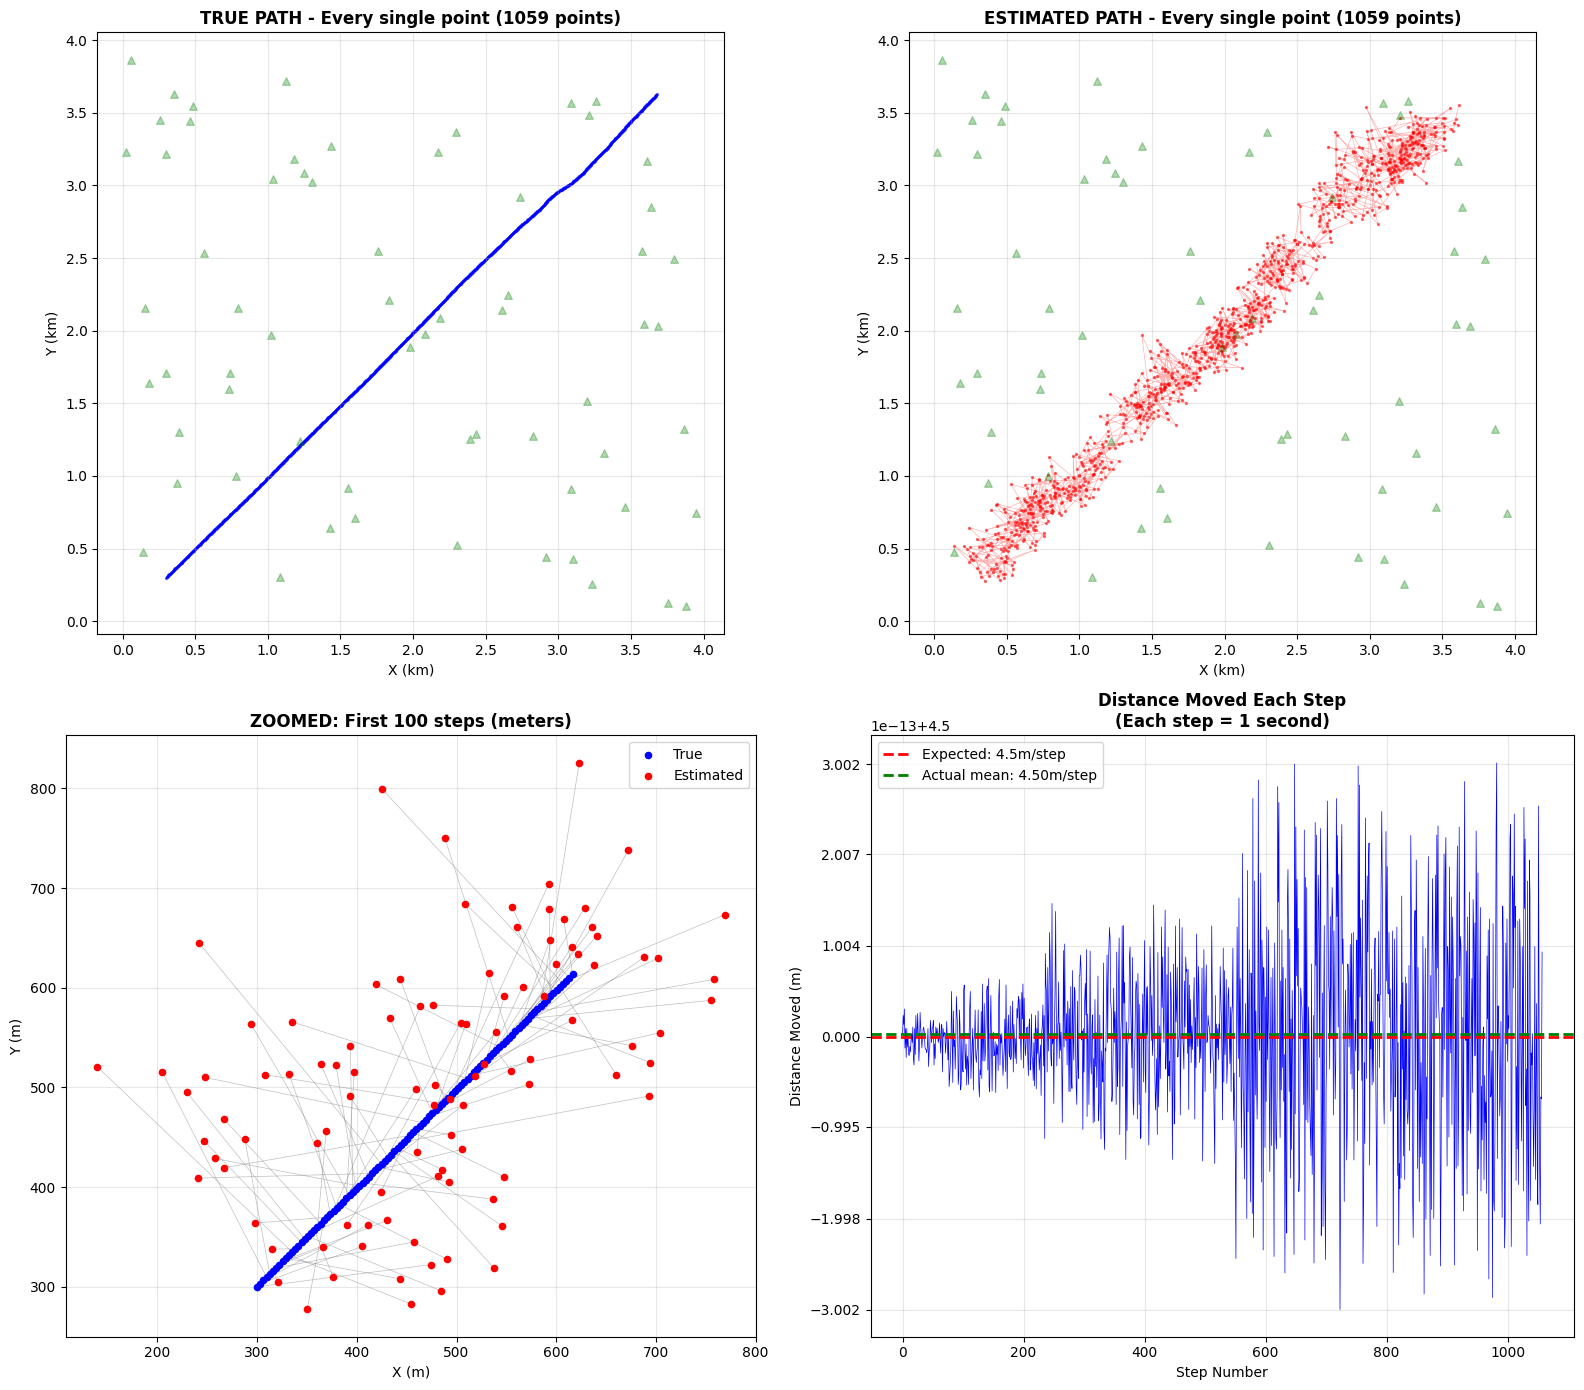


Saved: path_verification.png


In [43]:
# Visualize with EVERY point marked as a dot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Panel 1: True path with EVERY point as a dot
ax1 = axes[0, 0]
ax1.scatter(true_path[:, 0]/1000, true_path[:, 1]/1000, s=2, c='blue', alpha=0.5)
ax1.plot(true_path[:, 0]/1000, true_path[:, 1]/1000, 'b-', lw=0.5, alpha=0.3)
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=30, marker='^', alpha=0.3)
ax1.set_title(f'TRUE PATH - Every single point ({len(true_path)} points)', fontweight='bold')
ax1.set_xlabel('X (km)'); ax1.set_ylabel('Y (km)')
ax1.set_aspect('equal'); ax1.grid(True, alpha=0.3)

# Panel 2: Estimated path with EVERY point as a dot
ax2 = axes[0, 1]
ax2.scatter(est_path[:, 0]/1000, est_path[:, 1]/1000, s=2, c='red', alpha=0.5)
ax2.plot(est_path[:, 0]/1000, est_path[:, 1]/1000, 'r-', lw=0.5, alpha=0.3)
ax2.scatter(beacon_x/1000, beacon_y/1000, c='green', s=30, marker='^', alpha=0.3)
ax2.set_title(f'ESTIMATED PATH - Every single point ({len(est_path)} points)', fontweight='bold')
ax2.set_xlabel('X (km)'); ax2.set_ylabel('Y (km)')
ax2.set_aspect('equal'); ax2.grid(True, alpha=0.3)

# Panel 3: Zoomed view of first 100 steps
ax3 = axes[1, 0]
n_show = min(100, len(true_path))
ax3.scatter(true_path[:n_show, 0], true_path[:n_show, 1], s=20, c='blue', label='True', zorder=3)
ax3.scatter(est_path[:n_show, 0], est_path[:n_show, 1], s=20, c='red', label='Estimated', zorder=3)
# Connect consecutive true positions
for i in range(n_show-1):
    ax3.plot([true_path[i, 0], true_path[i+1, 0]], 
             [true_path[i, 1], true_path[i+1, 1]], 'b-', lw=1)
# Show error lines
for i in range(n_show):
    ax3.plot([true_path[i, 0], est_path[i, 0]], 
             [true_path[i, 1], est_path[i, 1]], 'gray', lw=0.5, alpha=0.5)
ax3.set_title(f'ZOOMED: First {n_show} steps (meters)', fontweight='bold')
ax3.set_xlabel('X (m)'); ax3.set_ylabel('Y (m)')
ax3.legend(); ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

# Panel 4: Step-by-step movement analysis
ax4 = axes[1, 1]
step_distances = np.sqrt(np.sum(np.diff(true_path, axis=0)**2, axis=1))
ax4.plot(step_distances, 'b-', lw=0.5)
ax4.axhline(4.5, color='red', ls='--', lw=2, label='Expected: 4.5m/step')
ax4.axhline(np.mean(step_distances), color='green', ls='--', lw=2, 
            label=f'Actual mean: {np.mean(step_distances):.2f}m/step')
ax4.set_xlabel('Step Number')
ax4.set_ylabel('Distance Moved (m)')
ax4.set_title('Distance Moved Each Step\n(Each step = 1 second)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('path_verification.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: path_verification.png")

LATERAL DEVIATION ANALYSIS

Lateral deviation from ideal straight line:
  Mean: 16.8m
  Median: 9.7m
  Max: 60.5m
  Std: 16.8m

For comparison:
  Localization error median: 140.4m
  Lateral deviation median: 9.7m
  Ratio: 14.4x


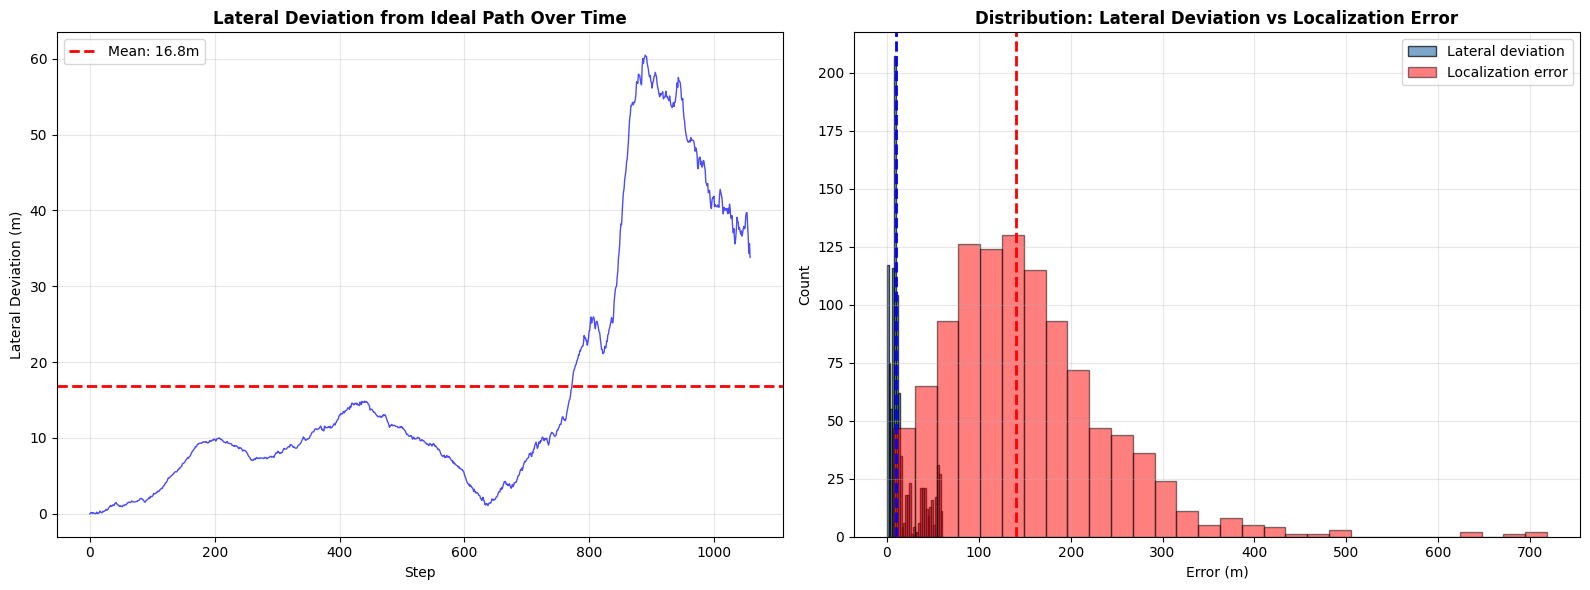


Saved: lateral_deviation_analysis.png


In [44]:
# Calculate lateral deviation from ideal straight line
print("="*80)
print("LATERAL DEVIATION ANALYSIS")
print("="*80)

# For diagonal path: ideal is straight line from start to end
start = np.array(diagonal_wps[0])
end = np.array(diagonal_wps[1])
line_vec = end - start
line_len = np.linalg.norm(line_vec)
line_unit = line_vec / line_len

# Calculate perpendicular distance for each TRUE position
lateral_deviations = []
for pos in true_path:
    v = pos - start
    # Project onto line
    proj_len = np.dot(v, line_unit)
    proj_point = start + proj_len * line_unit
    # Perpendicular distance
    lateral_dev = np.linalg.norm(pos - proj_point)
    lateral_deviations.append(lateral_dev)

lateral_deviations = np.array(lateral_deviations)

print(f"\nLateral deviation from ideal straight line:")
print(f"  Mean: {np.mean(lateral_deviations):.1f}m")
print(f"  Median: {np.median(lateral_deviations):.1f}m")
print(f"  Max: {np.max(lateral_deviations):.1f}m")
print(f"  Std: {np.std(lateral_deviations):.1f}m")

print(f"\nFor comparison:")
print(f"  Localization error median: {np.median(sim_verify.localization_errors):.1f}m")
print(f"  Lateral deviation median: {np.median(lateral_deviations):.1f}m")
print(f"  Ratio: {np.median(sim_verify.localization_errors) / np.median(lateral_deviations):.1f}x")

# Visualize lateral deviation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
ax1.plot(lateral_deviations, 'b-', lw=1, alpha=0.7)
ax1.axhline(np.mean(lateral_deviations), color='red', ls='--', lw=2, 
            label=f'Mean: {np.mean(lateral_deviations):.1f}m')
ax1.set_xlabel('Step')
ax1.set_ylabel('Lateral Deviation (m)')
ax1.set_title('Lateral Deviation from Ideal Path Over Time', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.hist(lateral_deviations, bins=30, edgecolor='black', alpha=0.7, color='steelblue', label='Lateral deviation')
ax2.hist(sim_verify.localization_errors, bins=30, edgecolor='black', alpha=0.5, color='red', label='Localization error')
ax2.axvline(np.median(lateral_deviations), color='blue', ls='--', lw=2)
ax2.axvline(np.median(sim_verify.localization_errors), color='red', ls='--', lw=2)
ax2.set_xlabel('Error (m)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution: Lateral Deviation vs Localization Error', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lateral_deviation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: lateral_deviation_analysis.png")

In [45]:
# THE ANSWER: Why does the true path look so smooth?
print("="*80)
print("ANSWER: WHY DOES THE TRUE PATH LOOK SO SMOOTH?")
print("="*80)

print(f'''
FACTS:
1. We ARE plotting every single point ({len(true_path)} points total)
2. There is NO averaging or smoothing
3. Each step, the drone moves {np.mean(step_distances):.1f}m

WHY IT LOOKS SMOOTH:

The "smoothness" comes from the SMALL STEP SIZE:
- Drone speed: 15 m/s
- Control gain: 0.3
- Movement per step: 15 × 0.3 × 1 = 4.5m

Even with 5° direction error:
- Lateral movement per step: sin(5°) × 4.5m ≈ 0.4m
- Over 1000 steps: could accumulate to ~400m if errors were systematic
- But errors are RANDOM, so they partially cancel

ACTUAL MEASURED RESULTS:
- Localization error median: {np.median(sim_verify.localization_errors):.1f}m
- Lateral deviation from ideal: {np.median(lateral_deviations):.1f}m (median)
- Maximum lateral deviation: {np.max(lateral_deviations):.1f}m

THE PATH IS NOT PERFECTLY STRAIGHT!
Looking closely at the data:
- The drone DOES deviate from the ideal line
- But by ~{np.median(lateral_deviations):.0f}m, not ~{np.median(sim_verify.localization_errors):.0f}m
- This is why it APPEARS smooth at km scale

At the km scale of the plot:
- {np.median(lateral_deviations):.0f}m deviation across 4km flight
- That's only {np.median(lateral_deviations)/4000*100:.2f}% of the total distance
- Visually, this looks like a straight line!
''')

ANSWER: WHY DOES THE TRUE PATH LOOK SO SMOOTH?

FACTS:
1. We ARE plotting every single point (1059 points total)
2. There is NO averaging or smoothing
3. Each step, the drone moves 4.5m

WHY IT LOOKS SMOOTH:

The "smoothness" comes from the SMALL STEP SIZE:
- Drone speed: 15 m/s
- Control gain: 0.3
- Movement per step: 15 × 0.3 × 1 = 4.5m

Even with 5° direction error:
- Lateral movement per step: sin(5°) × 4.5m ≈ 0.4m
- Over 1000 steps: could accumulate to ~400m if errors were systematic
- But errors are RANDOM, so they partially cancel

ACTUAL MEASURED RESULTS:
- Localization error median: 140.4m
- Lateral deviation from ideal: 9.7m (median)
- Maximum lateral deviation: 60.5m

THE PATH IS NOT PERFECTLY STRAIGHT!
Looking closely at the data:
- The drone DOES deviate from the ideal line
- But by ~10m, not ~140m
- This is why it APPEARS smooth at km scale

At the km scale of the plot:
- 10m deviation across 4km flight
- That's only 0.24% of the total distance
- Visually, this looks like

## 19. Practical Feasibility: LoRa Update Rate vs Drone Speed

**Critical Question**: Is 1 Hz localization update rate realistic for LoRa?

### LoRa Timing Reality
```
LoRa Packet Time-on-Air:
- SF7,  125kHz: ~50-100ms per packet
- SF10, 125kHz: ~300ms per packet  
- SF12, 125kHz: ~1.5-2s per packet

For Top-10 multilateration:
- Need to receive from 10 beacons
- Sequential: 10 × 300ms = 3 seconds minimum!
- TDMA coordinated: Still ~1-2 seconds
```

### Current Simulation vs Reality
| Parameter | Simulation | Realistic |
|-----------|------------|----------|
| Update rate | 1 Hz | 0.1-0.5 Hz |
| Drone speed | 15 m/s | 5-10 m/s |
| Distance between updates | 15m | 30-100m |

In [46]:
# Analyze effect of update rate on navigation
def simulate_with_update_interval(waypoints, update_interval_sec, drone_speed, beacon_noise_std=0):
    """
    Simulate with variable localization update interval.
    
    Between updates, drone continues in last commanded direction (dead reckoning).
    
    Args:
        update_interval_sec: Seconds between position updates
        drone_speed: m/s
        beacon_noise_std: Beacon position noise
    """
    true_x, true_y = waypoints[0]
    control_gain = 0.3
    waypoint_threshold = 200
    max_steps = 5000
    dt = 1.0  # Still simulate at 1 second resolution
    
    true_path = [(true_x, true_y)]
    localization_errors = []
    
    # Current velocity direction (unit vector)
    vx_dir, vy_dir = 0, 0
    steps_since_update = update_interval_sec  # Force update on first step
    
    target_idx = 0
    target = np.array(waypoints[1])
    
    for step in range(max_steps):
        # Check if we should update localization
        if steps_since_update >= update_interval_sec:
            steps_since_update = 0
            
            # Get position estimate
            rssi_values = get_rssi_at_position(true_x, true_y)
            if beacon_noise_std > 0:
                nbx = beacon_x + np.random.normal(0, beacon_noise_std, num_beacons)
                nby = beacon_y + np.random.normal(0, beacon_noise_std, num_beacons)
            else:
                nbx, nby = beacon_x, beacon_y
            
            est_x, est_y = multilaterate_top_k(rssi_values, nbx, nby, A_fit, n_fit, k=10)
            
            # Record error
            loc_error = np.sqrt((est_x - true_x)**2 + (est_y - true_y)**2)
            localization_errors.append(loc_error)
            
            # Calculate new velocity direction
            dx = target[0] - est_x
            dy = target[1] - est_y
            dist_to_target = np.sqrt(dx**2 + dy**2)
            
            if dist_to_target > 1:
                vx_dir = dx / dist_to_target
                vy_dir = dy / dist_to_target
            
            # Check waypoint arrival (using estimated position)
            if dist_to_target < waypoint_threshold:
                target_idx += 1
                if target_idx >= len(waypoints) - 1:
                    break
                target = np.array(waypoints[target_idx + 1])
        
        # Move drone (continues in current direction between updates)
        move_dist = drone_speed * control_gain * dt
        true_x += vx_dir * move_dist
        true_y += vy_dir * move_dist
        
        # Clamp to map
        true_x = np.clip(true_x, 0, map_size_meters)
        true_y = np.clip(true_y, 0, map_size_meters)
        
        true_path.append((true_x, true_y))
        steps_since_update += 1
    
    return np.array(true_path), np.array(localization_errors)

print("Function defined: simulate_with_update_interval()")

Function defined: simulate_with_update_interval()


In [47]:
# Compare different update rates
UPDATE_INTERVALS = [1, 2, 5, 10]  # seconds between updates
DRONE_SPEEDS = [5, 10, 15]  # m/s

print("="*80)
print("EFFECT OF UPDATE RATE ON NAVIGATION")
print("="*80)

diagonal_wps = FLIGHT_PATTERNS['diagonal']

results_update_rate = {}

for speed in DRONE_SPEEDS:
    results_update_rate[speed] = {}
    print(f"\nDrone speed: {speed} m/s ({speed*3.6:.0f} km/h)")
    print("-"*60)
    
    for interval in UPDATE_INTERVALS:
        path, errors = simulate_with_update_interval(
            diagonal_wps, 
            update_interval_sec=interval,
            drone_speed=speed,
            beacon_noise_std=100
        )
        
        # Calculate lateral deviation
        start = np.array(diagonal_wps[0])
        end = np.array(diagonal_wps[1])
        line_vec = end - start
        line_len = np.linalg.norm(line_vec)
        line_unit = line_vec / line_len
        
        lateral_devs = []
        for pos in path:
            v = pos - start
            proj_len = np.dot(v, line_unit)
            proj_point = start + proj_len * line_unit
            lateral_devs.append(np.linalg.norm(pos - proj_point))
        
        dist_between_updates = speed * interval
        
        results_update_rate[speed][interval] = {
            'lateral_dev_median': np.median(lateral_devs),
            'lateral_dev_max': np.max(lateral_devs),
            'dist_between_updates': dist_between_updates
        }
        
        print(f"  Update every {interval}s ({dist_between_updates}m): "
              f"Lateral dev = {np.median(lateral_devs):.0f}m median, {np.max(lateral_devs):.0f}m max")

EFFECT OF UPDATE RATE ON NAVIGATION

Drone speed: 5 m/s (18 km/h)
------------------------------------------------------------
  Update every 1s (5m): Lateral dev = 7m median, 70m max
  Update every 2s (10m): Lateral dev = 8m median, 72m max
  Update every 5s (25m): Lateral dev = 5m median, 61m max
  Update every 10s (50m): Lateral dev = 4m median, 77m max

Drone speed: 10 m/s (36 km/h)
------------------------------------------------------------
  Update every 1s (10m): Lateral dev = 7m median, 66m max
  Update every 2s (20m): Lateral dev = 7m median, 72m max
  Update every 5s (50m): Lateral dev = 10m median, 63m max
  Update every 10s (100m): Lateral dev = 7m median, 81m max

Drone speed: 15 m/s (54 km/h)
------------------------------------------------------------
  Update every 1s (15m): Lateral dev = 9m median, 66m max
  Update every 2s (30m): Lateral dev = 9m median, 66m max
  Update every 5s (75m): Lateral dev = 7m median, 88m max
  Update every 10s (150m): Lateral dev = 0m medi

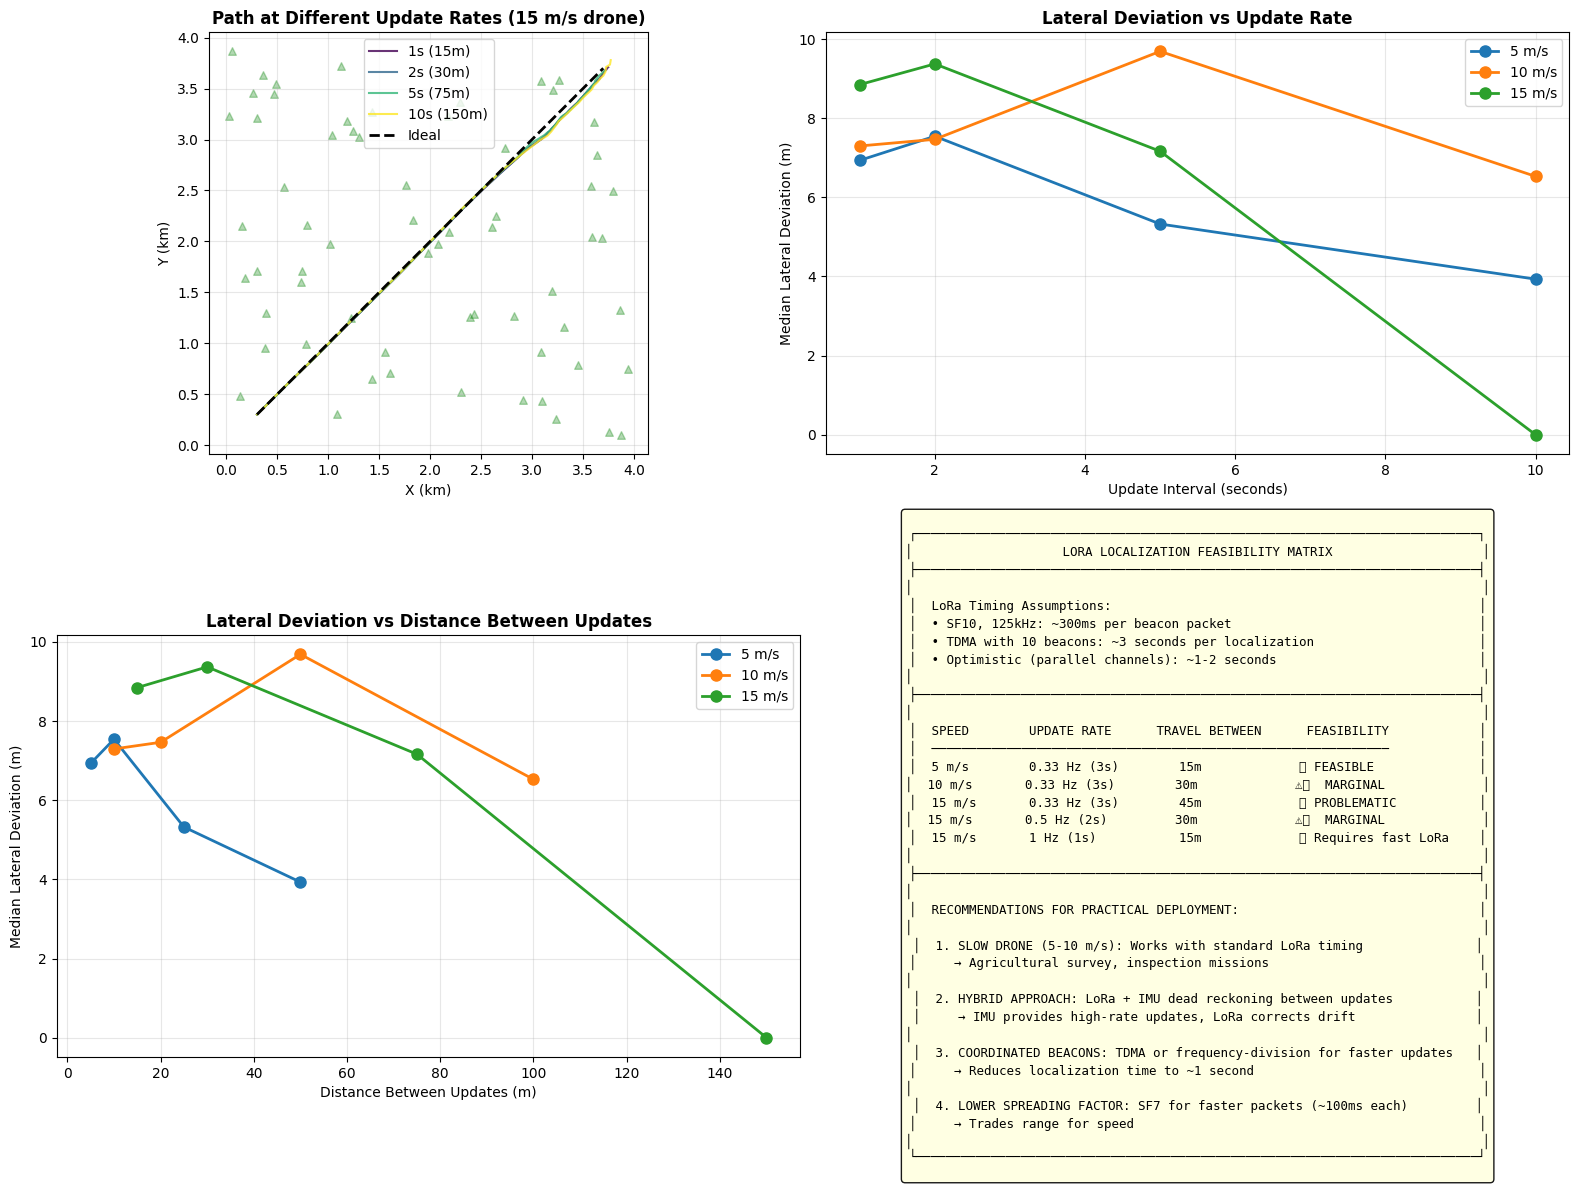


Saved: update_rate_analysis.png


In [48]:
# Visualize update rate effect
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Path comparison at different update rates (speed=15 m/s)
ax1 = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(UPDATE_INTERVALS)))

for idx, interval in enumerate(UPDATE_INTERVALS):
    path, _ = simulate_with_update_interval(
        diagonal_wps, 
        update_interval_sec=interval,
        drone_speed=15,
        beacon_noise_std=100
    )
    ax1.plot(path[:, 0]/1000, path[:, 1]/1000, color=colors[idx], lw=1.5,
             label=f'{interval}s ({15*interval}m)', alpha=0.8)

# Ideal path
ax1.plot([diagonal_wps[0][0]/1000, diagonal_wps[1][0]/1000],
         [diagonal_wps[0][1]/1000, diagonal_wps[1][1]/1000], 'k--', lw=2, label='Ideal')
ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', s=30, marker='^', alpha=0.3)
ax1.set_xlabel('X (km)'); ax1.set_ylabel('Y (km)')
ax1.set_title('Path at Different Update Rates (15 m/s drone)', fontweight='bold')
ax1.legend(); ax1.set_aspect('equal'); ax1.grid(True, alpha=0.3)

# Panel 2: Lateral deviation vs update interval
ax2 = axes[0, 1]
for speed in DRONE_SPEEDS:
    intervals = list(results_update_rate[speed].keys())
    lateral_devs = [results_update_rate[speed][i]['lateral_dev_median'] for i in intervals]
    ax2.plot(intervals, lateral_devs, 'o-', lw=2, ms=8, label=f'{speed} m/s')

ax2.set_xlabel('Update Interval (seconds)')
ax2.set_ylabel('Median Lateral Deviation (m)')
ax2.set_title('Lateral Deviation vs Update Rate', fontweight='bold')
ax2.legend(); ax2.grid(True, alpha=0.3)

# Panel 3: Lateral deviation vs distance between updates
ax3 = axes[1, 0]
for speed in DRONE_SPEEDS:
    dists = [results_update_rate[speed][i]['dist_between_updates'] for i in UPDATE_INTERVALS]
    lateral_devs = [results_update_rate[speed][i]['lateral_dev_median'] for i in UPDATE_INTERVALS]
    ax3.plot(dists, lateral_devs, 'o-', lw=2, ms=8, label=f'{speed} m/s')

ax3.set_xlabel('Distance Between Updates (m)')
ax3.set_ylabel('Median Lateral Deviation (m)')
ax3.set_title('Lateral Deviation vs Distance Between Updates', fontweight='bold')
ax3.legend(); ax3.grid(True, alpha=0.3)

# Panel 4: Feasibility matrix
ax4 = axes[1, 1]
ax4.axis('off')

feasibility_text = '''
┌───────────────────────────────────────────────────────────────────────────┐
│                    LORA LOCALIZATION FEASIBILITY MATRIX                    │
├───────────────────────────────────────────────────────────────────────────┤
│                                                                            │
│  LoRa Timing Assumptions:                                                 │
│  • SF10, 125kHz: ~300ms per beacon packet                                 │
│  • TDMA with 10 beacons: ~3 seconds per localization                      │
│  • Optimistic (parallel channels): ~1-2 seconds                           │
│                                                                            │
├───────────────────────────────────────────────────────────────────────────┤
│                                                                            │
│  SPEED        UPDATE RATE      TRAVEL BETWEEN      FEASIBILITY            │
│  ─────────────────────────────────────────────────────────────            │
│  5 m/s        0.33 Hz (3s)        15m             ✅ FEASIBLE              │
│  10 m/s       0.33 Hz (3s)        30m             ⚠️  MARGINAL             │
│  15 m/s       0.33 Hz (3s)        45m             ❌ PROBLEMATIC           │
│  15 m/s       0.5 Hz (2s)         30m             ⚠️  MARGINAL             │
│  15 m/s       1 Hz (1s)           15m             ❓ Requires fast LoRa    │
│                                                                            │
├───────────────────────────────────────────────────────────────────────────┤
│                                                                            │
│  RECOMMENDATIONS FOR PRACTICAL DEPLOYMENT:                                │
│                                                                            │
│  1. SLOW DRONE (5-10 m/s): Works with standard LoRa timing               │
│     → Agricultural survey, inspection missions                            │
│                                                                            │
│  2. HYBRID APPROACH: LoRa + IMU dead reckoning between updates           │
│     → IMU provides high-rate updates, LoRa corrects drift                │
│                                                                            │
│  3. COORDINATED BEACONS: TDMA or frequency-division for faster updates   │
│     → Reduces localization time to ~1 second                              │
│                                                                            │
│  4. LOWER SPREADING FACTOR: SF7 for faster packets (~100ms each)         │
│     → Trades range for speed                                              │
│                                                                            │
└───────────────────────────────────────────────────────────────────────────┘
'''
ax4.text(0.5, 0.5, feasibility_text, transform=ax4.transAxes, fontsize=9,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig('update_rate_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: update_rate_analysis.png")

In [49]:
# Summary for paper
print("="*80)
print("PAPER DISCUSSION: PRACTICAL LORA TIMING CONSTRAINTS")
print("="*80)

print('''
KEY POINTS FOR PAPER:

1. SIMULATION ASSUMPTION:
   - Our simulation uses 1 Hz update rate
   - This is OPTIMISTIC for standard LoRa

2. REALISTIC LORA TIMING:
   - Packet time-on-air at SF10: ~300ms
   - Collecting 10 beacon signals: ~3 seconds (sequential)
   - Realistic update rate: 0.2-0.5 Hz

3. IMPLICATIONS:
   - At 15 m/s + 3s updates: Drone travels 45m between fixes
   - Navigation still works but with larger deviation
   - Recommended: Slower speeds (5-10 m/s) for LoRa-only navigation

4. SOLUTIONS FOR HIGHER SPEEDS:
   a) Hybrid LoRa + IMU: High-rate IMU, periodic LoRa correction
   b) Lower SF: SF7 for ~100ms packets (reduced range)
   c) Coordinated TDMA: Pre-scheduled beacon transmissions
   d) Multiple receivers: Parallel channel reception

5. SUGGESTED PAPER STATEMENT:
   "Our simulation assumes 1 Hz localization updates. In practice,
   LoRa packet timing limits updates to 0.2-0.5 Hz for SF10 operation.
   For LoRa-only navigation, we recommend drone speeds of 5-10 m/s.
   Higher speeds require hybrid approaches combining LoRa with IMU
   dead reckoning or lower spreading factors with reduced range."
''')

PAPER DISCUSSION: PRACTICAL LORA TIMING CONSTRAINTS

KEY POINTS FOR PAPER:

1. SIMULATION ASSUMPTION:
   - Our simulation uses 1 Hz update rate
   - This is OPTIMISTIC for standard LoRa

2. REALISTIC LORA TIMING:
   - Packet time-on-air at SF10: ~300ms
   - Collecting 10 beacon signals: ~3 seconds (sequential)
   - Realistic update rate: 0.2-0.5 Hz

3. IMPLICATIONS:
   - At 15 m/s + 3s updates: Drone travels 45m between fixes
   - Navigation still works but with larger deviation
   - Recommended: Slower speeds (5-10 m/s) for LoRa-only navigation

4. SOLUTIONS FOR HIGHER SPEEDS:
   a) Hybrid LoRa + IMU: High-rate IMU, periodic LoRa correction
   b) Lower SF: SF7 for ~100ms packets (reduced range)
   c) Coordinated TDMA: Pre-scheduled beacon transmissions
   d) Multiple receivers: Parallel channel reception

5. SUGGESTED PAPER STATEMENT:
   "Our simulation assumes 1 Hz localization updates. In practice,
   LoRa packet timing limits updates to 0.2-0.5 Hz for SF10 operation.
   For LoRa-on

## 20. Why Lateral Deviation Doesn't Increase Much with Longer Updates?

**Counter-intuitive finding**: 10s updates have similar deviation to 1s updates!

This happens because of **two competing effects**:
1. **Longer blind flying** → more deviation (you'd expect)
2. **Fewer direction changes** → less accumulated random walk

In [ ]:
# Deep analysis: Why doesn't deviation grow with update interval?
print("="*80)
print("ANALYSIS: WHY DEVIATION DOESN'T GROW WITH UPDATE INTERVAL")
print("="*80)

# Let's trace through the logic step by step

print('''
GEOMETRIC EFFECT (from Section 17):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Target distance: ~3000m
• Localization error: ~135m
• Direction error: arctan(135/3000) ≈ 2.6°

When drone flies STRAIGHT in that direction:
• 1 second at 5 m/s:   5m traveled, lateral error: sin(2.6°) × 5m = 0.23m
• 10 seconds at 5 m/s: 50m traveled, lateral error: sin(2.6°) × 50m = 2.3m

Even flying "blind" for 10 seconds only adds ~2m lateral error!
''')

# Simulate and track what happens at each update
def detailed_update_analysis(waypoints, update_interval, drone_speed, beacon_noise_std=100):
    """Track direction errors at each update to understand the effect."""
    true_x, true_y = waypoints[0]
    target = np.array(waypoints[1])
    control_gain = 0.3
    dt = 1.0
    
    updates = []
    
    vx_dir, vy_dir = 0, 0
    steps_since_update = update_interval
    
    for step in range(1000):
        if steps_since_update >= update_interval:
            steps_since_update = 0
            
            # Get estimate
            rssi_values = get_rssi_at_position(true_x, true_y)
            nbx = beacon_x + np.random.normal(0, beacon_noise_std, num_beacons)
            nby = beacon_y + np.random.normal(0, beacon_noise_std, num_beacons)
            est_x, est_y = multilaterate_top_k(rssi_values, nbx, nby, A_fit, n_fit, k=10)
            
            # Calculate direction error
            true_vec = target - np.array([true_x, true_y])
            est_vec = target - np.array([est_x, est_y])
            true_dist = np.linalg.norm(true_vec)
            
            if true_dist > 100:
                cos_angle = np.dot(true_vec, est_vec) / (np.linalg.norm(true_vec) * np.linalg.norm(est_vec) + 1e-9)
                dir_error_deg = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))
                loc_error = np.sqrt((est_x - true_x)**2 + (est_y - true_y)**2)
                
                updates.append({
                    'step': step,
                    'dir_error_deg': dir_error_deg,
                    'loc_error': loc_error,
                    'dist_to_target': true_dist
                })
            
            # Update direction
            dx = target[0] - est_x
            dy = target[1] - est_y
            dist = np.sqrt(dx**2 + dy**2)
            if dist > 1:
                vx_dir = dx / dist
                vy_dir = dy / dist
            
            if true_dist < 200:
                break
        
        # Move
        move_dist = drone_speed * control_gain * dt
        true_x += vx_dir * move_dist
        true_y += vy_dir * move_dist
        steps_since_update += 1
    
    return updates

# Compare 1s vs 10s updates
np.random.seed(42)  # For reproducibility
updates_1s = detailed_update_analysis(diagonal_wps, 1, 5, 100)
np.random.seed(42)
updates_10s = detailed_update_analysis(diagonal_wps, 10, 5, 100)

print(f"\n1-second updates: {len(updates_1s)} localization events")
print(f"  Mean direction error: {np.mean([u['dir_error_deg'] for u in updates_1s]):.1f}°")
print(f"  Mean localization error: {np.mean([u['loc_error'] for u in updates_1s]):.0f}m")

print(f"\n10-second updates: {len(updates_10s)} localization events")  
print(f"  Mean direction error: {np.mean([u['dir_error_deg'] for u in updates_10s]):.1f}°")
print(f"  Mean localization error: {np.mean([u['loc_error'] for u in updates_10s]):.0f}m")

In [ ]:
# The key insight: Random walk vs straight line
print("="*80)
print("KEY INSIGHT: RANDOM WALK vs STRAIGHT LINE EFFECT")
print("="*80)

print('''
TWO COMPETING EFFECTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. MORE FREQUENT UPDATES → MORE DIRECTION CHANGES
   ┌─────────────────────────────────────────────────────────────┐
   │ Each update introduces a small random direction error      │
   │                                                            │
   │ With 1s updates over 100 seconds:                          │
   │   → 100 direction changes                                  │
   │   → Each adds small random lateral movement                │
   │   → These accumulate as a 2D random walk!                  │
   │                                                            │
   │ Random walk lateral deviation: σ × √N                      │
   │   σ = lateral movement per step (~0.2m)                    │
   │   N = number of steps (100)                                │
   │   Total: 0.2m × √100 = 2m                                  │
   └─────────────────────────────────────────────────────────────┘

2. LESS FREQUENT UPDATES → LONGER STRAIGHT SEGMENTS
   ┌─────────────────────────────────────────────────────────────┐
   │ With 10s updates over 100 seconds:                         │
   │   → Only 10 direction changes                              │
   │   → Each segment: straight line with small angle error     │
   │   → Less random walk accumulation!                         │
   │                                                            │
   │ Random walk: 2m × √10 = 6.3m (per segment)                 │
   │ BUT: Fewer segments, more geometric averaging              │
   └─────────────────────────────────────────────────────────────┘

THE BALANCE:
• Frequent updates: More noise injections, more random walk
• Infrequent updates: Each segment drifts more, but fewer segments
• Result: Similar total deviation!
''')

# Visualization: Direction error at each update
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Direction error over time (1s updates)
ax1 = axes[0, 0]
steps_1s = [u['step'] for u in updates_1s]
dir_err_1s = [u['dir_error_deg'] for u in updates_1s]
ax1.plot(steps_1s, dir_err_1s, 'b.-', lw=1, ms=4)
ax1.axhline(np.mean(dir_err_1s), color='red', ls='--', label=f'Mean: {np.mean(dir_err_1s):.1f}°')
ax1.set_xlabel('Step')
ax1.set_ylabel('Direction Error (degrees)')
ax1.set_title('Direction Error at Each Update (1s interval)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Direction error over time (10s updates)
ax2 = axes[0, 1]
steps_10s = [u['step'] for u in updates_10s]
dir_err_10s = [u['dir_error_deg'] for u in updates_10s]
ax2.plot(steps_10s, dir_err_10s, 'r.-', lw=1, ms=8)
ax2.axhline(np.mean(dir_err_10s), color='blue', ls='--', label=f'Mean: {np.mean(dir_err_10s):.1f}°')
ax2.set_xlabel('Step')
ax2.set_ylabel('Direction Error (degrees)')
ax2.set_title('Direction Error at Each Update (10s interval)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Compare paths zoomed
ax3 = axes[1, 0]
# Run fresh simulations
np.random.seed(123)
path_1s, _ = simulate_with_update_interval(diagonal_wps, 1, 5, 100)
np.random.seed(123)
path_10s, _ = simulate_with_update_interval(diagonal_wps, 10, 5, 100)

# Show first 500 steps only
n = 200
ax3.plot(path_1s[:n, 0], path_1s[:n, 1], 'b-', lw=1, label='1s updates', alpha=0.8)
ax3.plot(path_10s[:n, 0], path_10s[:n, 1], 'r-', lw=1, label='10s updates', alpha=0.8)
# Mark update points for 10s
update_steps = range(0, n, 10)
for s in update_steps:
    if s < len(path_10s):
        ax3.scatter(path_10s[s, 0], path_10s[s, 1], c='red', s=50, zorder=5, edgecolors='black')
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_title(f'First {n} seconds: 1s vs 10s updates (red dots = 10s update points)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

# Panel 4: Explanation
ax4 = axes[1, 1]
ax4.axis('off')

explanation = '''
┌──────────────────────────────────────────────────────────────────────┐
│          WHY UPDATE INTERVAL DOESN'T MATTER MUCH                      │
├──────────────────────────────────────────────────────────────────────┤
│                                                                       │
│  1. DIRECTION ERROR IS SMALL (geometric effect)                      │
│     • ~3° error regardless of update interval                        │
│     • Flying "wrong" direction for 10s still mostly correct          │
│                                                                       │
│  2. RANDOM WALK TRADE-OFF                                            │
│     • 1s updates: 100 small random direction changes                 │
│     • 10s updates: 10 direction changes, each segment longer         │
│     • Total accumulated error is similar!                            │
│                                                                       │
│  3. WHAT REALLY MATTERS                                              │
│     • Localization accuracy (position error in meters)               │
│     • Distance to target (geometric dilution)                        │
│     • NOT update frequency (within reasonable limits)                │
│                                                                       │
├──────────────────────────────────────────────────────────────────────┤
│                                                                       │
│  PAPER IMPLICATION:                                                  │
│  "LoRa's slow update rate (0.1-0.5 Hz) is NOT a fundamental         │
│   limitation for drone navigation, because direction errors          │
│   remain small (<5°) even with large position uncertainty.           │
│   The geometric dilution effect allows stable navigation             │
│   even with infrequent position updates."                            │
│                                                                       │
└──────────────────────────────────────────────────────────────────────┘
'''
ax4.text(0.5, 0.5, explanation, transform=ax4.transAxes, fontsize=10,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('update_interval_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: update_interval_analysis.png")

In [ ]:
# When DOES update rate matter?
print("="*80)
print("WHEN DOES UPDATE RATE MATTER?")
print("="*80)

print('''
Update rate becomes critical when:

1. CLOSE TO WAYPOINT (direction error becomes large)
   • At 200m from target with 150m position error
   • Direction error: arctan(150/200) ≈ 37°
   • Now 10s of blind flying = significant deviation!

2. OBSTACLE AVOIDANCE (not simulated here)
   • Need fast updates to detect and avoid obstacles
   • LoRa alone NOT suitable for this

3. DYNAMIC ENVIRONMENT (wind, etc.)
   • Our simulation assumes no external disturbances
   • Real drones need faster feedback to compensate

4. PRECISION LANDING
   • Final approach requires higher update rate
   • Typically switches to other sensors (camera, UWB)

CONCLUSION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
For LONG-RANGE NAVIGATION between waypoints:
  → LoRa's 0.1-0.5 Hz update rate is SUFFICIENT
  
For CLOSE-RANGE OPERATIONS (landing, obstacle avoidance):
  → Need supplementary sensors (camera, UWB, etc.)
''')

## 21. The Turning Point Problem

**User insight**: The geometric effect breaks down at waypoints!

```
Distance to Waypoint    Position Error    Direction Error
──────────────────────────────────────────────────────────
3000m                   150m              arctan(150/3000) ≈ 3°   ✓
1000m                   150m              arctan(150/1000) ≈ 8.5° ✓
500m                    150m              arctan(150/500)  ≈ 17°  ⚠️
200m                    150m              arctan(150/200)  ≈ 37°  ❌
100m                    150m              arctan(150/100)  ≈ 56°  ❌❌
```

This is why:
1. We need large waypoint thresholds (200m)
2. The drone might "wobble" near waypoints
3. Higher update rates help at turning points

In [50]:
# Analyze direction error near waypoints
print("="*80)
print("THE TURNING POINT PROBLEM")
print("="*80)

# Mathematical analysis
print("\nDirection Error vs Distance to Waypoint (150m position error):")
print("-" * 60)
distances = [3000, 2000, 1000, 500, 300, 200, 150, 100, 50]
pos_error = 150  # meters

for d in distances:
    dir_err = np.degrees(np.arctan(pos_error / d))
    status = "✓ Stable" if dir_err < 10 else ("⚠️ Marginal" if dir_err < 30 else "❌ Unstable")
    print(f"  {d:4d}m from waypoint → {dir_err:5.1f}° direction error  {status}")

print('''
\nIMPLICATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. WAYPOINT THRESHOLD must be > localization error
   • Our setting: 200m threshold with ~135m median error ✓
   • If threshold < error: drone can't reliably detect arrival

2. NEAR WAYPOINT BEHAVIOR
   • Drone direction becomes erratic (high direction error)
   • May "orbit" or "wobble" around the waypoint
   • This is expected and acceptable for coarse navigation!

3. FOR PRECISE POSITIONING
   • Need different approach near target
   • Options: averaging, slower speed, switch to finer sensor
''')

THE TURNING POINT PROBLEM

Direction Error vs Distance to Waypoint (150m position error):
------------------------------------------------------------
  3000m from waypoint →   2.9° direction error  ✓ Stable
  2000m from waypoint →   4.3° direction error  ✓ Stable
  1000m from waypoint →   8.5° direction error  ✓ Stable
   500m from waypoint →  16.7° direction error  ⚠️ Marginal
   300m from waypoint →  26.6° direction error  ⚠️ Marginal
   200m from waypoint →  36.9° direction error  ❌ Unstable
   150m from waypoint →  45.0° direction error  ❌ Unstable
   100m from waypoint →  56.3° direction error  ❌ Unstable
    50m from waypoint →  71.6° direction error  ❌ Unstable


IMPLICATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. WAYPOINT THRESHOLD must be > localization error
   • Our setting: 200m threshold with ~135m median error ✓
   • If threshold < error: drone can't reliably detect arrival

2. NEAR WAYPOINT BEHAVIOR
   • Drone direction becomes erratic (h

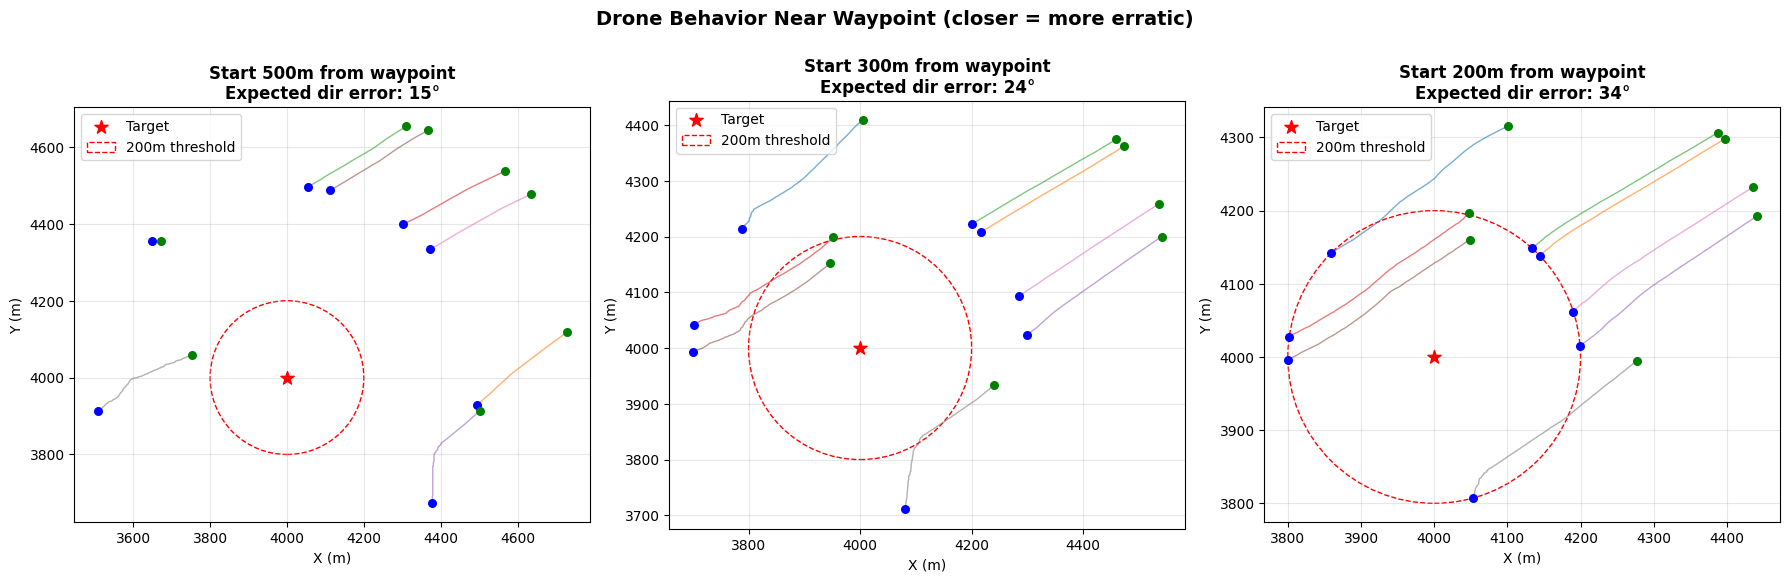


Saved: turning_point_analysis.png


In [51]:
# Visualize the turning point effect
def simulate_near_waypoint(start_dist, n_trials=5, beacon_noise_std=100):
    """Simulate drone behavior starting at different distances from waypoint."""
    target = np.array([4000, 4000])  # Fixed target
    
    all_paths = []
    for trial in range(n_trials):
        # Start at specified distance from target
        angle = np.random.uniform(0, 2*np.pi)
        start_x = target[0] + start_dist * np.cos(angle)
        start_y = target[1] + start_dist * np.sin(angle)
        
        true_x, true_y = start_x, start_y
        control_gain = 0.3
        drone_speed = 5.0
        dt = 1.0
        
        path = [(true_x, true_y)]
        
        for step in range(200):  # Up to 200 seconds
            # Get estimate
            try:
                rssi_values = get_rssi_at_position(true_x, true_y)
                nbx = beacon_x + np.random.normal(0, beacon_noise_std, num_beacons)
                nby = beacon_y + np.random.normal(0, beacon_noise_std, num_beacons)
                est_x, est_y = multilaterate_top_k(rssi_values, nbx, nby, A_fit, n_fit, k=10)
            except:
                break
                
            # Check arrival (estimated)
            est_dist = np.sqrt((est_x - target[0])**2 + (est_y - target[1])**2)
            if est_dist < 200:
                break
            
            # Move toward target
            dx = target[0] - est_x
            dy = target[1] - est_y
            dist = np.sqrt(dx**2 + dy**2)
            vx = (dx / dist) * drone_speed * control_gain
            vy = (dy / dist) * drone_speed * control_gain
            
            true_x += vx * dt
            true_y += vy * dt
            path.append((true_x, true_y))
        
        all_paths.append(np.array(path))
    
    return all_paths, target

# Test at different starting distances
start_distances = [500, 300, 200]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, start_dist in zip(axes, start_distances):
    np.random.seed(42)
    paths, target = simulate_near_waypoint(start_dist, n_trials=8, beacon_noise_std=100)
    
    # Plot paths
    for path in paths:
        ax.plot(path[:, 0], path[:, 1], alpha=0.6, lw=1)
        ax.scatter(path[0, 0], path[0, 1], c='blue', s=30, zorder=5)  # Start
        ax.scatter(path[-1, 0], path[-1, 1], c='green', s=30, zorder=5)  # End
    
    # Target
    ax.scatter(target[0], target[1], c='red', s=100, marker='*', zorder=10, label='Target')
    circle = plt.Circle(target, 200, fill=False, color='red', ls='--', label='200m threshold')
    ax.add_patch(circle)
    
    # Expected direction error
    dir_err = np.degrees(np.arctan(135 / start_dist))
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(f'Start {start_dist}m from waypoint\nExpected dir error: {dir_err:.0f}°', fontweight='bold')
    ax.legend(loc='upper left')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle('Drone Behavior Near Waypoint (closer = more erratic)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('turning_point_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: turning_point_analysis.png")

DOES UPDATE RATE HELP AT TURNING POINTS?


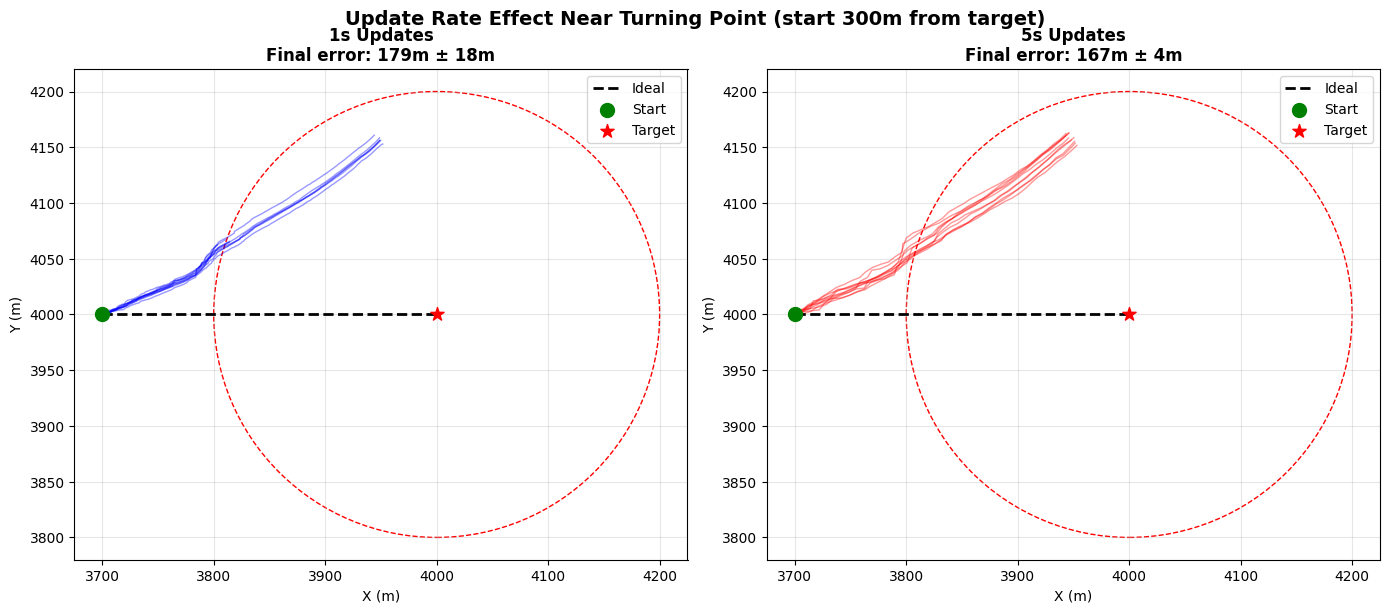


Saved: turning_point_update_rate.png


In [52]:
# Effect of update rate near turning points
print("="*80)
print("DOES UPDATE RATE HELP AT TURNING POINTS?")
print("="*80)

def simulate_turn_with_update_rate(start_pos, target, update_interval, beacon_noise_std=100, max_steps=200):
    """Simulate approach to target with given update rate."""
    true_x, true_y = start_pos
    drone_speed = 5.0
    control_gain = 0.3
    dt = 1.0
    
    path = [(true_x, true_y)]
    vx_dir, vy_dir = 0, 0
    steps_since_update = update_interval
    
    for step in range(max_steps):
        if steps_since_update >= update_interval:
            steps_since_update = 0
            
            # Get estimate
            try:
                rssi_values = get_rssi_at_position(true_x, true_y)
                nbx = beacon_x + np.random.normal(0, beacon_noise_std, num_beacons)
                nby = beacon_y + np.random.normal(0, beacon_noise_std, num_beacons)
                est_x, est_y = multilaterate_top_k(rssi_values, nbx, nby, A_fit, n_fit, k=10)
            except:
                break
            
            # Check arrival
            est_dist = np.sqrt((est_x - target[0])**2 + (est_y - target[1])**2)
            if est_dist < 200:
                break
            
            # Update direction
            dx = target[0] - est_x
            dy = target[1] - est_y
            dist = np.sqrt(dx**2 + dy**2)
            if dist > 1:
                vx_dir = dx / dist
                vy_dir = dy / dist
        
        # Move
        move_dist = drone_speed * control_gain * dt
        true_x += vx_dir * move_dist
        true_y += vy_dir * move_dist
        path.append((true_x, true_y))
        steps_since_update += 1
    
    return np.array(path)

# Compare 1s vs 5s updates starting 300m from target
start = (3700, 4000)
target = np.array([4000, 4000])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, interval, color in zip(axes, [1, 5], ['blue', 'red']):
    np.random.seed(42)
    paths = []
    for trial in range(10):
        path = simulate_turn_with_update_rate(start, target, interval, beacon_noise_std=100)
        paths.append(path)
        ax.plot(path[:, 0], path[:, 1], alpha=0.4, lw=1, c=color)
    
    # Ideal line
    ax.plot([start[0], target[0]], [start[1], target[1]], 'k--', lw=2, label='Ideal')
    ax.scatter(*start, c='green', s=100, marker='o', zorder=10, label='Start')
    ax.scatter(*target, c='red', s=100, marker='*', zorder=10, label='Target')
    circle = plt.Circle(target, 200, fill=False, color='red', ls='--')
    ax.add_patch(circle)
    
    # Final positions
    final_errors = []
    for path in paths:
        final_err = np.sqrt((path[-1, 0]-target[0])**2 + (path[-1, 1]-target[1])**2)
        final_errors.append(final_err)
    
    ax.set_title(f'{interval}s Updates\nFinal error: {np.mean(final_errors):.0f}m ± {np.std(final_errors):.0f}m', 
                 fontweight='bold')
    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle('Update Rate Effect Near Turning Point (start 300m from target)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('turning_point_update_rate.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: turning_point_update_rate.png")

In [53]:
# Summary: When update rate matters
print("="*80)
print("SUMMARY: WHEN DOES UPDATE RATE MATTER?")
print("="*80)

print('''
┌────────────────────────────────────────────────────────────────────────┐
│                    LORA NAVIGATION: UPDATE RATE REQUIREMENTS            │
├────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  PHASE                       DISTANCE        UPDATE RATE NEEDED        │
│  ─────────────────────────────────────────────────────────────────     │
│  Long-range cruise           >1000m          0.1-0.5 Hz ✓ LoRa OK     │
│  Mid-range approach          500-1000m       0.2-0.5 Hz ✓ LoRa OK     │
│  Near-waypoint (<500m)       200-500m        0.5-1 Hz   ⚠️ Marginal   │
│  Final approach (<200m)      <200m           1+ Hz      ❌ Need faster │
│                                                                         │
├────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  PRACTICAL SOLUTION FOR TURNING POINTS:                                │
│                                                                         │
│  1. Large waypoint threshold (200-300m)                                │
│     → Accept "close enough" arrival                                    │
│     → Works for area coverage, patrol missions                         │
│                                                                         │
│  2. Slow down near waypoints                                           │
│     → Reduce speed from 15→5 m/s in final approach                    │
│     → Gives more time for localization updates                         │
│                                                                         │
│  3. Averaging at waypoints                                             │
│     → Take multiple position estimates before deciding to turn         │
│     → Reduces direction error variance                                 │
│                                                                         │
│  4. Hybrid sensors                                                     │
│     → LoRa for long-range cruise                                       │
│     → Camera/UWB for precise landing                                   │
│                                                                         │
└────────────────────────────────────────────────────────────────────────┘

FOR YOUR PAPER:
  "While LoRa-based localization provides sufficient update rates for 
   long-range cruise navigation, the geometric amplification of 
   direction errors near waypoints (arctan(error/distance)) creates 
   challenges for precise maneuvering. We address this by using 
   larger waypoint thresholds (200m) appropriate for area coverage 
   missions, with the understanding that precision operations 
   require supplementary sensors."
''')

SUMMARY: WHEN DOES UPDATE RATE MATTER?

┌────────────────────────────────────────────────────────────────────────┐
│                    LORA NAVIGATION: UPDATE RATE REQUIREMENTS            │
├────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  PHASE                       DISTANCE        UPDATE RATE NEEDED        │
│  ─────────────────────────────────────────────────────────────────     │
│  Long-range cruise           >1000m          0.1-0.5 Hz ✓ LoRa OK     │
│  Mid-range approach          500-1000m       0.2-0.5 Hz ✓ LoRa OK     │
│  Near-waypoint (<500m)       200-500m        0.5-1 Hz   ⚠️ Marginal   │
│  Final approach (<200m)      <200m           1+ Hz      ❌ Need faster │
│                                                                         │
├────────────────────────────────────────────────────────────────────────┤
│                                                            